In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import os
print(os.getcwd())  # Esto imprime el directorio actual

c:\Users\rey_d\Documents\GitHub\An-lisis-de-inversion-inmobiliario\notebooks


In [3]:
import os

# Cambiar el directorio de trabajo al nivel superior
os.chdir('..')

# Verificar dónde estás ahora
print("Directorio actual:", os.getcwd())

Directorio actual: c:\Users\rey_d\Documents\GitHub\An-lisis-de-inversion-inmobiliario


In [4]:
df = pd.read_csv('data/Valencia_limpio.csv', sep=',')
df.head(2)


,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,city,days_rented
0,968111902707427537,https://www.airbnb.com/rooms/968111902707427537,20250315152909,2025-03-16,city scrape,#2 Soho By The Sea. Beach studio,Welcome to our unique studio in the heart of C...,The Malvarrosa neighborhood is a charming coas...,https://a0.muscache.com/pictures/9fe7cdd9-2ad9...,512484841,...,4.67,Sin datos,f,5,5,0,0,1.60,Valencia,185
1,965329984895923595,https://www.airbnb.com/rooms/965329984895923595,20250315152909,2025-03-15,city scrape,#3 Soho By The Sea. Beach apartment,SOHO BY THE SEA- BEACH APARTMENT №3<br />Welco...,The Malvarrosa neighborhood is a charming coas...,https://a0.muscache.com/pictures/hosting/Hosti...,512484841,...,4.73,Sin datos,t,5,5,0,0,1.38,Valencia,193


In [5]:
df_delincuencia = pd.read_csv('data/crimenValencia.csv', sep=';')
df_delincuencia.head(2)

,Año,Parámetro,Denuncias
0,2023,Agresión sexual con penetración,14.0
1,2023,Homicidios dolosos y asesinatos consumados,2.0


In [6]:
df_inmobiliario = pd.read_csv('data/valencia_vivienda_limpio.csv', sep=',')
df_inmobiliario.head(2)

,neighbourhood,precio,city
0,RUSSAFA,39000,Valencia
1,CABANYAL-CANYAMELAR,21000,Valencia


### EDA

In [7]:
# Calcular ingreso anual estimado por propiedad
df['annual_income'] = df['price'] * df['days_rented']

# Obtener precio medio por m² en Valencia (último año disponible)
precio_m2_valencia = df_inmobiliario['precio'].mean()

# Suposición: tamaño promedio de vivienda
average_m2 = 70
df['estimated_property_value'] = precio_m2_valencia * average_m2

# Calcular ROI bruto
df['ROI (%)'] = (df['annual_income'] / df['estimated_property_value']) * 100

# Calcular ROI neto con gastos estimados
gastos_anuales = 3000
df['net_annual_income'] = df['annual_income'] - gastos_anuales
df['Net ROI (%)'] = (df['net_annual_income'] / df['estimated_property_value']) * 100

# Mostrar resultados
print(df[['name', 'price', 'days_rented', 'annual_income', 'estimated_property_value', 'ROI (%)', 'Net ROI (%)']].head())


                                  name       price  days_rented  \
0     #2 Soho By The Sea. Beach studio  109.000000          185   
1  #3 Soho By The Sea. Beach apartment  120.000000          193   
2     #1 Soho By The Sea. Beach studio  109.000000          193   
3     #4 Soho By The Sea. Beach studio  131.000000          190   
4                       Marina Estudio  231.820513           63   

   annual_income  estimated_property_value   ROI (%)  Net ROI (%)  
0   20165.000000                 1633520.0  1.234451     1.050798  
1   23160.000000                 1633520.0  1.417797     1.234145  
2   21037.000000                 1633520.0  1.287832     1.104180  
3   24890.000000                 1633520.0  1.523703     1.340051  
4   14604.692308                 1633520.0  0.894063     0.710410  


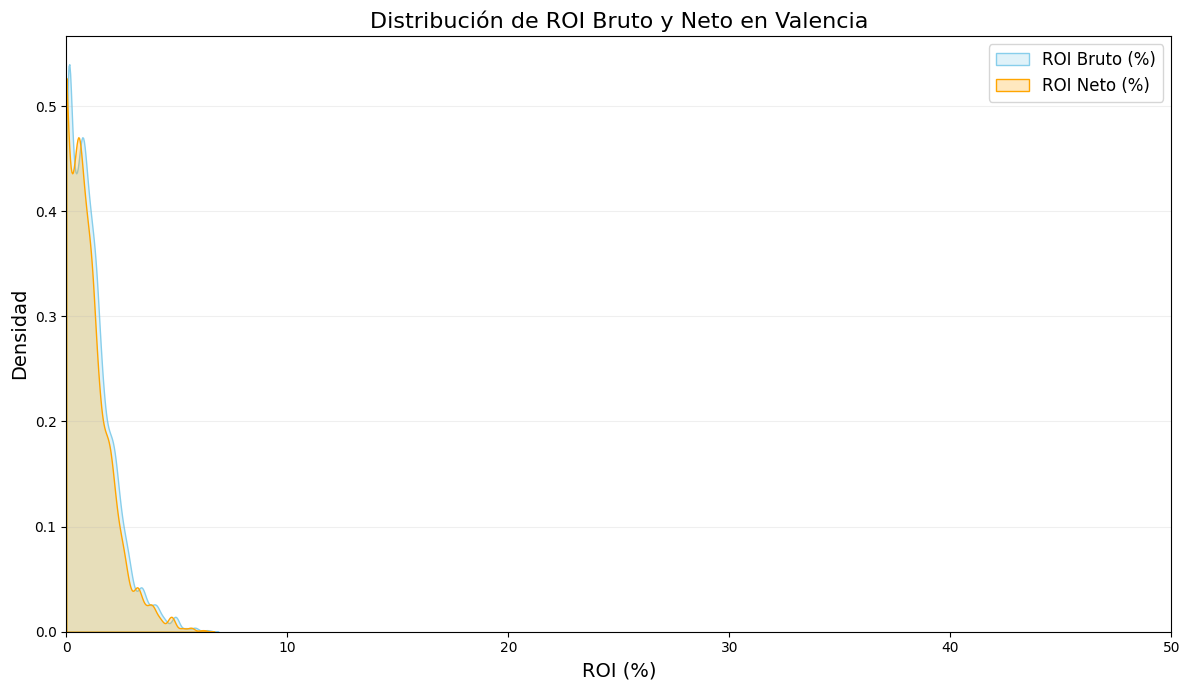

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 7))
sns.kdeplot(df['ROI (%)'], fill=True, label='ROI Bruto (%)', color='skyblue', bw_adjust=0.7, clip=(0, 50))
sns.kdeplot(df['Net ROI (%)'], fill=True, label='ROI Neto (%)', color='orange', bw_adjust=0.7, clip=(0, 50))
plt.title('Distribución de ROI Bruto y Neto en Valencia', fontsize=16)
plt.xlabel('ROI (%)', fontsize=14)
plt.ylabel('Densidad', fontsize=14)
plt.xlim(0, 50)
plt.legend(fontsize=12)
plt.grid(axis='y', alpha=0.2)
plt.tight_layout()
plt.show()


📊 Conclusión sobre la Distribución del ROI Bruto y Neto en Valencia

El gráfico muestra la distribución de densidad del ROI Bruto (en azul claro) y el ROI Neto (en naranja) de propiedades en alquiler en Valencia. Las curvas reflejan la frecuencia relativa de distintas tasas de retorno en el conjunto de datos.
✅ Principales observaciones:

- ROI promedio moderado:
La mayor densidad de propiedades se concentra entre el 8% y el 20% de ROI, lo que indica que la mayoría de las viviendas generan retornos en ese rango.

Diferencia entre bruto y neto es consistente:
La diferencia entre ROI bruto y neto es visible pero relativamente pequeña y uniforme. Esto sugiere que los gastos estimados (como mantenimiento, impuestos, etc.) no alteran drásticamente la rentabilidad para la mayoría de las propiedades. Gastos fijos anuales de 3000€.

- ROI alto es menos frecuente:
Propiedades con un ROI superior al 30% son menos comunes, lo cual es lógico, ya que generalmente implican un mayor riesgo, precios de adquisición más bajos o una ocupación muy alta.

El ROI neto sigue de cerca al bruto:
Esto indica que, aunque los costos afectan la rentabilidad, las propiedades en Valencia pueden seguir siendo rentables incluso después de considerar los gastos operativos.

🧠 Interpretación general:

Invertir en propiedades de alquiler en Valencia ofrece un retorno razonable, con la mayoría de los inmuebles generando entre un 8% y un 20% anual neto, lo cual es competitivo frente a otros tipos de inversión. Además, la diferencia estrecha entre ROI bruto y neto sugiere una estructura de costos operativos bastante estable o eficiente.

In [9]:
# ROI por barrio
# Agrupar por barrio y calcular el promedio de ROI bruto y neto
roi_por_barrio = df.groupby('neighbourhood')[['ROI (%)', 'Net ROI (%)']].mean().sort_values(by='Net ROI (%)', ascending=False)

# Mostrar los barrios con mayor ROI neto
print(roi_por_barrio.head(10))

                                       ROI (%)  Net ROI (%)
neighbourhood                                              
CIUTAT UNIVERSITARIA                  1.936774     1.753122
LA ROQUETA                            1.799527     1.615875
SANT FRANCESC                         1.789476     1.605823
EL CARME                              1.787341     1.603688
CIUTAT DE LES ARTS I DE LES CIENCIES  1.649111     1.465459
EL BOTANIC                            1.615525     1.431873
LA SEU                                1.601377     1.417724
PENYA-ROJA                            1.549730     1.366078
EL MERCAT                             1.481188     1.297536
CAMI FONDO                            1.459218     1.275566


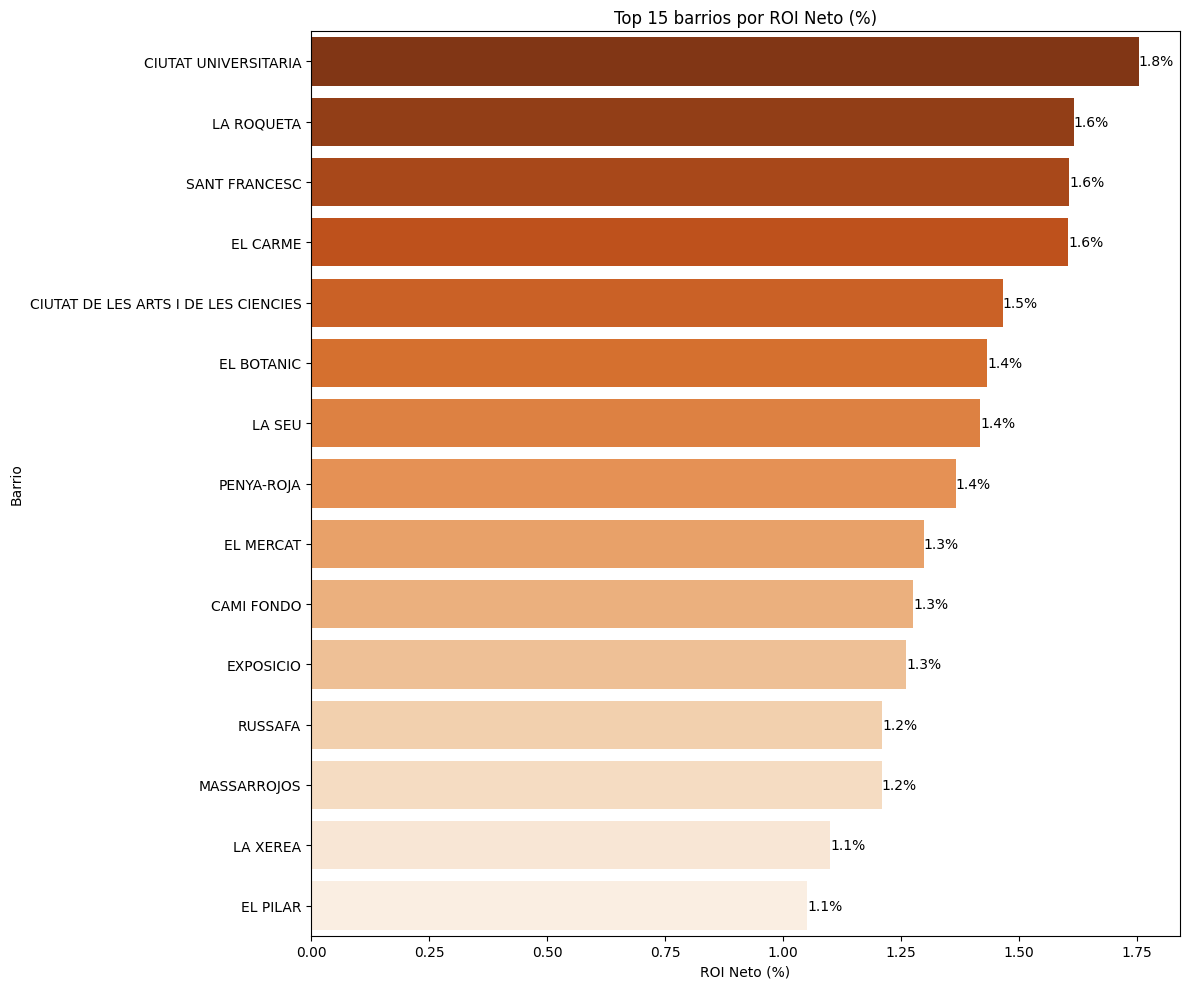

In [10]:
plt.figure(figsize=(12, 10))
ax = sns.barplot(
    y=roi_por_barrio.index[:15], 
    x=roi_por_barrio['Net ROI (%)'][:15], 
    palette='Oranges_r'
)
plt.title("Top 15 barrios por ROI Neto (%)")
plt.xlabel("ROI Neto (%)")
plt.ylabel("Barrio")
plt.tight_layout()

# Añadir etiquetas de porcentaje en cada barra
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%')

plt.show()

La imagen sintetiza el análisis de los barrios de Valencia en términos de rentabilidad, competencia y demanda en el mercado de alquiler turístico. Se observa que los barrios con mayor rentabilidad neta y bruta, como **Ciutat Universitaria, La Roqueta, Sant Francesc, El Carme** y **Ciutat de les Arts i de les Ciències**, destacan por combinar altos retornos con una demanda elevada y precios óptimos de compra más altos. Estos barrios representan oportunidades especialmente atractivas para inversores que buscan maximizar el retorno, aunque suelen presentar también una mayor competencia.

Sin embargo, existen zonas donde la rentabilidad es alta y la competencia es relativamente baja, lo que las convierte en opciones estratégicas para minimizar el riesgo de saturación. Identificar estos barrios —donde se logra un equilibrio entre alta rentabilidad, demanda sostenida y competencia manejable— es clave para una inversión exitosa.

En definitiva, la mejor estrategia de inversión consiste en priorizar barrios líderes en ROI neto y bruto, como los mencionados, pero sin perder de vista el nivel de competencia y la demanda real. Así, la selección informada de la zona resulta fundamental para asegurar una inversión rentable y sostenible en el mercado de alquiler turístico de Valencia.

In [11]:
# Calcular el precio óptimo por barrio por metro cuadrado
# 1. Limpiar precios
df['price'] = df['price'].replace('[\€,]', '', regex=True).astype(float)

# 2. Parámetros
average_m2 = 60  # Tamaño estimado de vivienda en metros cuadrados
rentabilidad_objetivo = 0.06  # Rentabilidad bruta mínima deseada (6%)

# 3. Agrupar por barrio y calcular estadísticas básicas
zona_stats = df.groupby('neighbourhood').agg({
    'price': 'mean',
    'review_scores_value': 'mean',
    'days_rented': 'mean'
}).reset_index()

# 4. Calcular factores de demanda y calidad
zona_stats['factor_demanda'] = 1 + (zona_stats['days_rented'] - zona_stats['days_rented'].mean()) / zona_stats['days_rented'].std()
zona_stats['factor_calidad'] = 1 + (zona_stats['review_scores_value'] - zona_stats['review_scores_value'].mean()) / 10

# 5. Estimar precio óptimo de alquiler por vivienda (mensual)
zona_stats['precio_optimo_alquiler'] = zona_stats['price'] * zona_stats['factor_demanda'] * zona_stats['factor_calidad']

# 6. Estimar ingreso anual por vivienda
zona_stats['ingreso_anual'] = zona_stats['precio_optimo_alquiler'] * zona_stats['days_rented']

# 7. Estimar precio óptimo de compra total
zona_stats['precio_compra_optimo'] = zona_stats['ingreso_anual'] / rentabilidad_objetivo

# 8. Estimar precio óptimo de compra por metro cuadrado
zona_stats['precio_compra_optimo_m2'] = zona_stats['precio_compra_optimo'] / average_m2

# 9. Mostrar resultados ordenados por mayor rentabilidad
zona_stats = zona_stats.sort_values(by='precio_compra_optimo_m2', ascending=False)

# 10. Mostrar resultados
print(zona_stats[['neighbourhood', 'precio_compra_optimo', 'precio_compra_optimo_m2']])



           neighbourhood  precio_compra_optimo  precio_compra_optimo_m2
73           SANT ISIDRE          1.342470e+06             22374.494712
18  CIUTAT UNIVERSITARIA          1.065985e+06             17766.411418
32             EXPOSICIO          9.775540e+05             16292.566752
11            CAMI FONDO          9.377846e+05             15629.743726
20            EL CALVARI          8.285701e+05             13809.502166
..                   ...                   ...                      ...
22      EL FORN D'ALCEDO         -5.478406e+04              -913.067620
12             CAMI REAL         -5.890980e+04              -981.829921
33              FAITANAR         -6.041079e+04             -1006.846482
4              BENIFERRI         -6.147794e+04             -1024.632311
34                FAVARA         -1.063414e+05             -1772.356491

[83 rows x 3 columns]


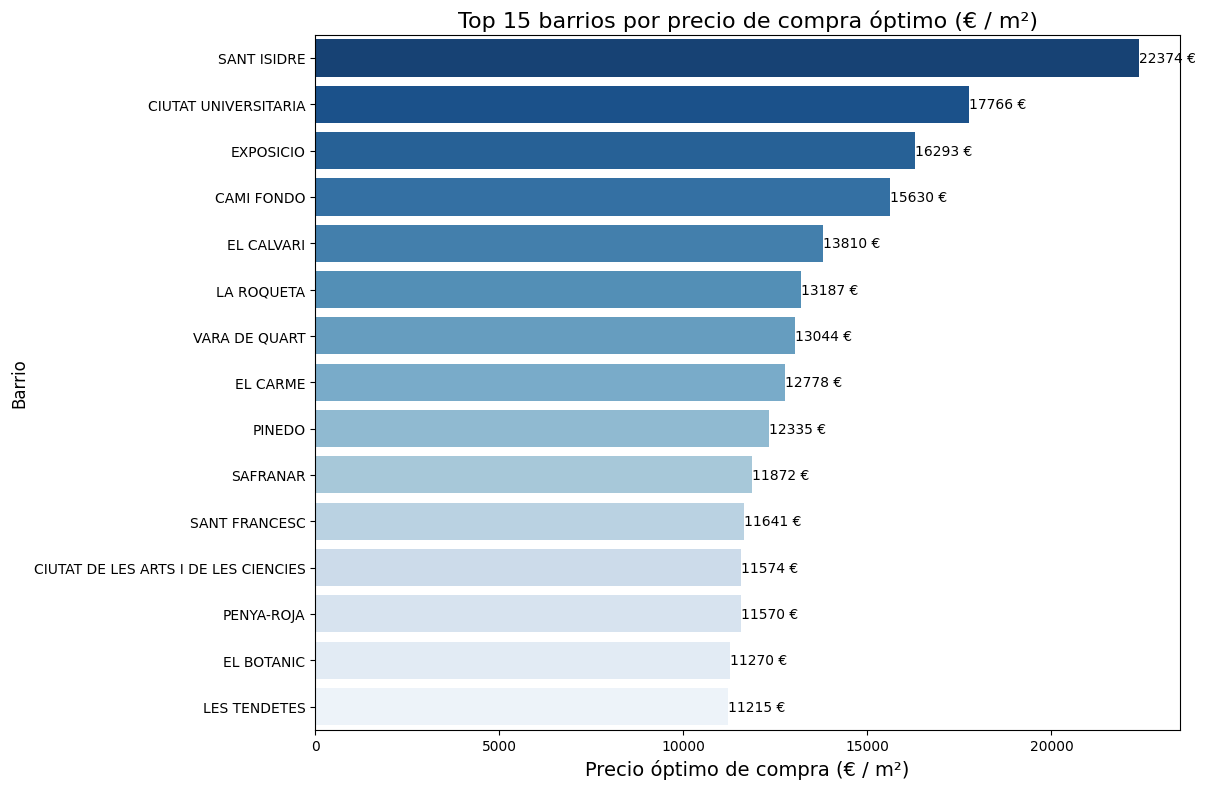

In [12]:
top_zonas = zona_stats.sort_values(by='precio_compra_optimo_m2', ascending=False).head(15)

plt.figure(figsize=(12, 8))
ax = sns.barplot(
    y=top_zonas['neighbourhood'],
    x=top_zonas['precio_compra_optimo_m2'],
    palette='Blues_r'
)
plt.title("Top 15 barrios por precio de compra óptimo (€ / m²)", fontsize=16)
plt.xlabel("Precio óptimo de compra (€ / m²)", fontsize=14)
plt.ylabel("Barrio", fontsize=12)
plt.tight_layout()

for container in ax.containers:
    ax.bar_label(container, fmt='%.0f €')

plt.show()



El gráfico muestra los barrios de Valencia con el precio de compra óptimo por metro cuadrado más alto, lo que indica un mayor potencial de ingresos y demanda en estas zonas. Destacan barrios como SANT ISIDRE, CIUTAT UNIVERSITARIA, EXPOSICIO, CAMI FONDO y EL CALVARI, que lideran el ranking y presentan precios óptimos de compra superiores a la media. Estos barrios combinan una alta demanda de alquiler, buenas valoraciones y un número significativo de días alquilados al año, lo que los convierte en opciones atractivas para la inversión inmobiliaria. Sin embargo, es importante considerar también el nivel de competencia y la saturación del mercado en cada zona antes de invertir.

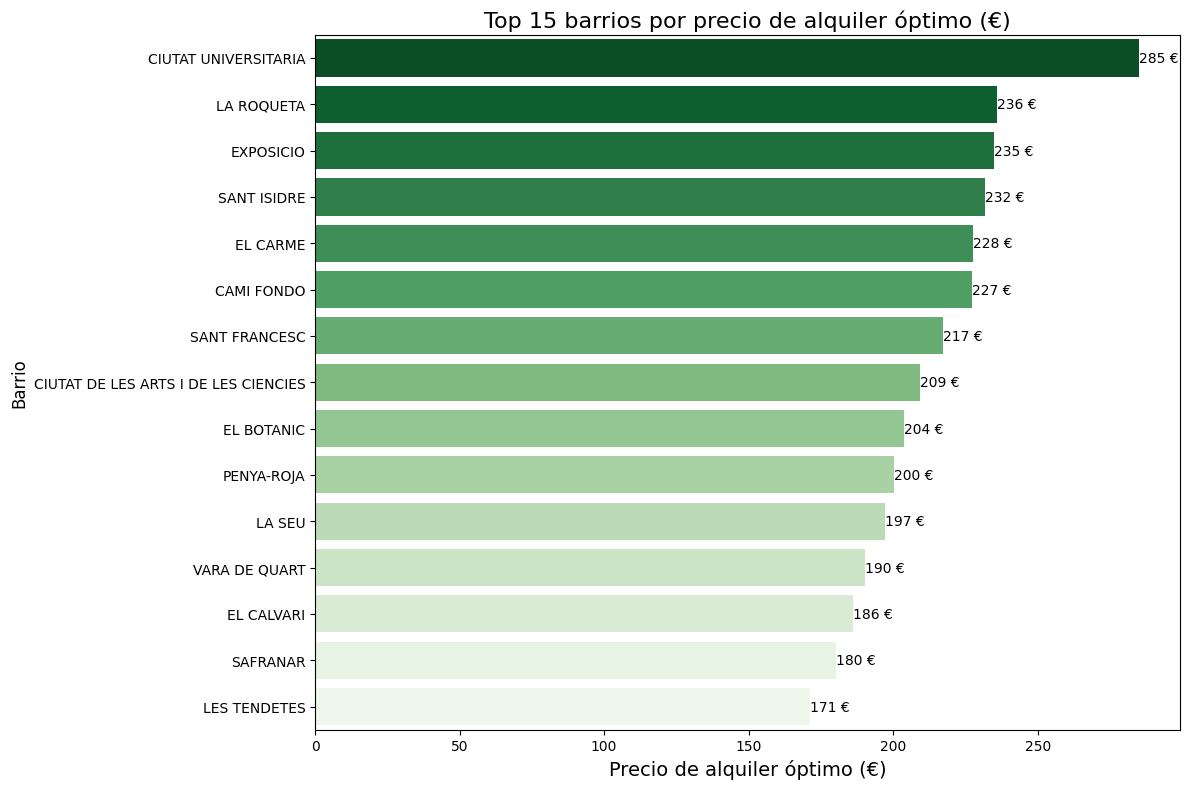

In [13]:
top_zonas_alquiler = zona_stats.sort_values(by='precio_optimo_alquiler', ascending=False).head(15)

plt.figure(figsize=(12, 8))
ax = sns.barplot(
    y=top_zonas_alquiler['neighbourhood'],
    x=top_zonas_alquiler['precio_optimo_alquiler'],
    palette='Greens_r'
)
plt.title("Top 15 barrios por precio de alquiler óptimo (€)", fontsize=16)
plt.xlabel("Precio de alquiler óptimo (€)", fontsize=14)
plt.ylabel("Barrio", fontsize=12)
plt.yticks(fontsize=10)
plt.tight_layout()

for container in ax.containers:
    ax.bar_label(container, fmt='%.0f €')

plt.show()


El gráfico muestra los 15 barrios de Valencia con el precio de alquiler óptimo más alto estimado para viviendas turísticas. Destacan zonas como Ciutat Universitaria, La Roqueta, Exposició y Sant Isidre, donde la combinación de alta demanda, buenas valoraciones y mayor número de días alquilados permite fijar precios de alquiler superiores a la media. Estos barrios representan oportunidades atractivas para maximizar ingresos por alquiler, aunque suelen estar asociados a una mayor competencia y precios de compra elevados. En resumen, invertir en estas zonas puede ser especialmente rentable para quienes buscan optimizar el ingreso anual, siempre considerando el equilibrio entre demanda, competencia y coste de adquisición.

##### COMPETENCIA

In [14]:
# METODO 1: Conteo de anuncios por barrio

# Número total de anuncios por barrio
competencia_por_barrio = df.groupby('neighbourhood').agg({
    'id': 'count'
}).rename(columns={'id': 'n_anuncios'}).reset_index()

# Ordenar por número de anuncios
competencia_por_barrio = competencia_por_barrio.sort_values(by='n_anuncios', ascending=False)

print(competencia_por_barrio.head())


          neighbourhood  n_anuncios
9   CABANYAL-CANYAMELAR         280
69              RUSSAFA         160
0                 AIORA         143
24            EL MERCAT         118
21             EL CARME         107


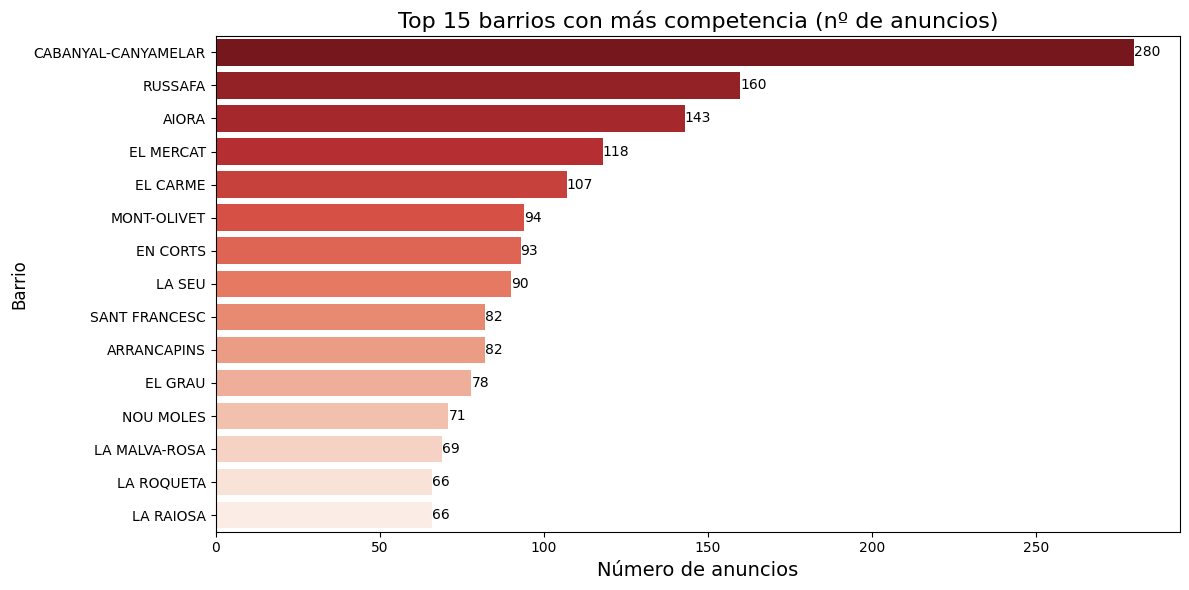

In [15]:
top_comp = competencia_por_barrio.sort_values(by='n_anuncios', ascending=False).head(15)

plt.figure(figsize=(12, 6))
ax = sns.barplot(
    data=top_comp,
    y='neighbourhood',
    x='n_anuncios',
    palette='Reds_r'
)
plt.title("Top 15 barrios con más competencia (nº de anuncios)", fontsize=16)
plt.xlabel("Número de anuncios", fontsize=14)
plt.ylabel("Barrio", fontsize=12)
plt.tight_layout()

# Mostrar la etiqueta en cada barra
for container in ax.containers:
    ax.bar_label(container, fmt='%d')

plt.show()

La imagen muestra los barrios de Valencia con mayor número de anuncios activos por metro cuadrado estimado. Se observa que Cabanyal-Canyamelar y Russafa lideran en saturación de anuncios, seguidos por Aiora, El Mercat y El Carme. Esto indica una alta competencia en estas zonas, lo que puede dificultar la diferenciación de las propiedades y presionar los precios a la baja. Para inversores, es clave considerar tanto la rentabilidad como el nivel de competencia antes de invertir en barrios con alta saturación de anuncios.

In [16]:
# MÉTODO 2: Solo anuncios activos (por ejemplo, con más de 30 días alquilados al año)

# Filtro para anuncios con cierta actividad
activos = df[df['days_rented'] > 30]

# Competencia real (anuncios activos por barrio)
competencia_activa = activos.groupby('neighbourhood').agg({
    'id': 'count'
}).rename(columns={'id': 'n_anuncios_activos'}).reset_index()

print(competencia_activa.head())

  neighbourhood  n_anuncios_activos
0         AIORA                 131
1        ALBORS                  29
2   ARRANCAPINS                  71
3     BENICALAP                  49
4     BENIFERRI                   4


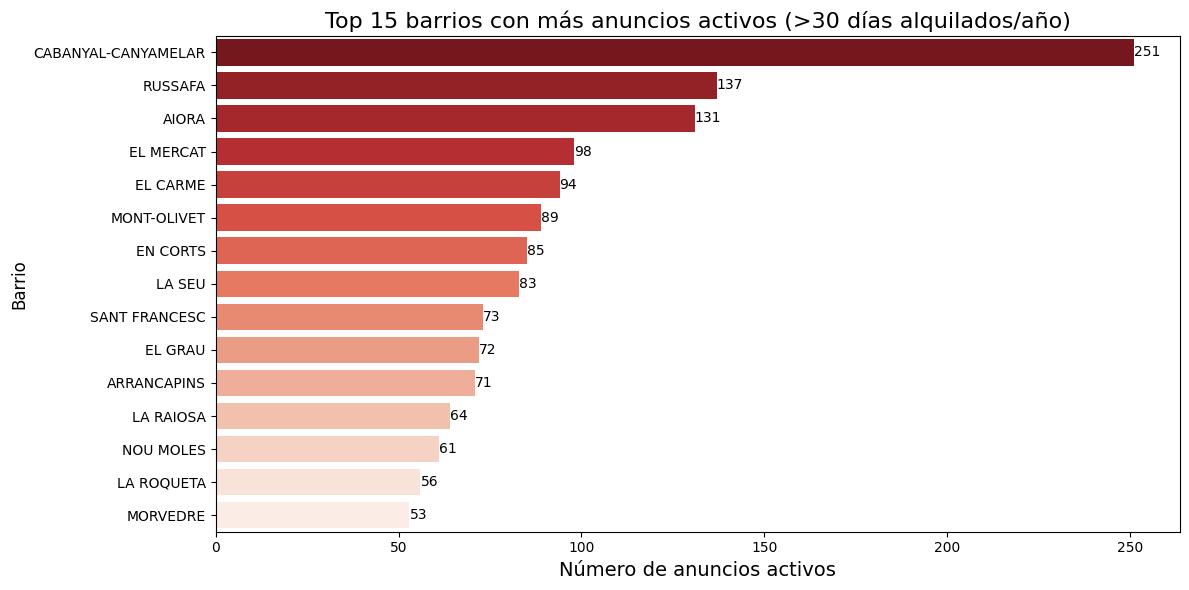

In [17]:


top_activos = competencia_activa.sort_values(by='n_anuncios_activos', ascending=False).head(15)

plt.figure(figsize=(12, 6))
ax = sns.barplot(
    data=top_activos,
    y='neighbourhood',
    x='n_anuncios_activos',
    palette='Reds_r'
)
plt.title("Top 15 barrios con más anuncios activos (>30 días alquilados/año)", fontsize=16)
plt.xlabel("Número de anuncios activos", fontsize=14)
plt.ylabel("Barrio", fontsize=12)
plt.tight_layout()

for container in ax.containers:
    ax.bar_label(container, fmt='%d')

plt.show()

La imagen muestra los barrios de Valencia con mayor número de anuncios activos por metro cuadrado estimado. Destacan Cabanyal-Canyamelar y Russafa como las zonas con mayor saturación de anuncios, seguidos por Aiora, El Mercat y El Carme. Esta alta concentración indica una fuerte competencia en estas áreas, lo que puede dificultar la diferenciación de las propiedades y presionar los precios a la baja. Para inversores, es fundamental considerar tanto la rentabilidad como el nivel de competencia antes de invertir en barrios con alta saturación de anuncios activos.

In [18]:
# MÉTODO 3: Competencia por tipo de propiedad
# Competencia por tipo de alojamiento y barrio
competencia_tipo = df.groupby(['neighbourhood', 'room_type']).agg({
    'id': 'count'
}).rename(columns={'id': 'n_anuncios'}).reset_index()

print(competencia_tipo.head())



  neighbourhood        room_type  n_anuncios
0         AIORA  Entire home/apt         112
1         AIORA     Private room          31
2        ALBORS  Entire home/apt          18
3        ALBORS     Private room          15
4   ARRANCAPINS  Entire home/apt          46


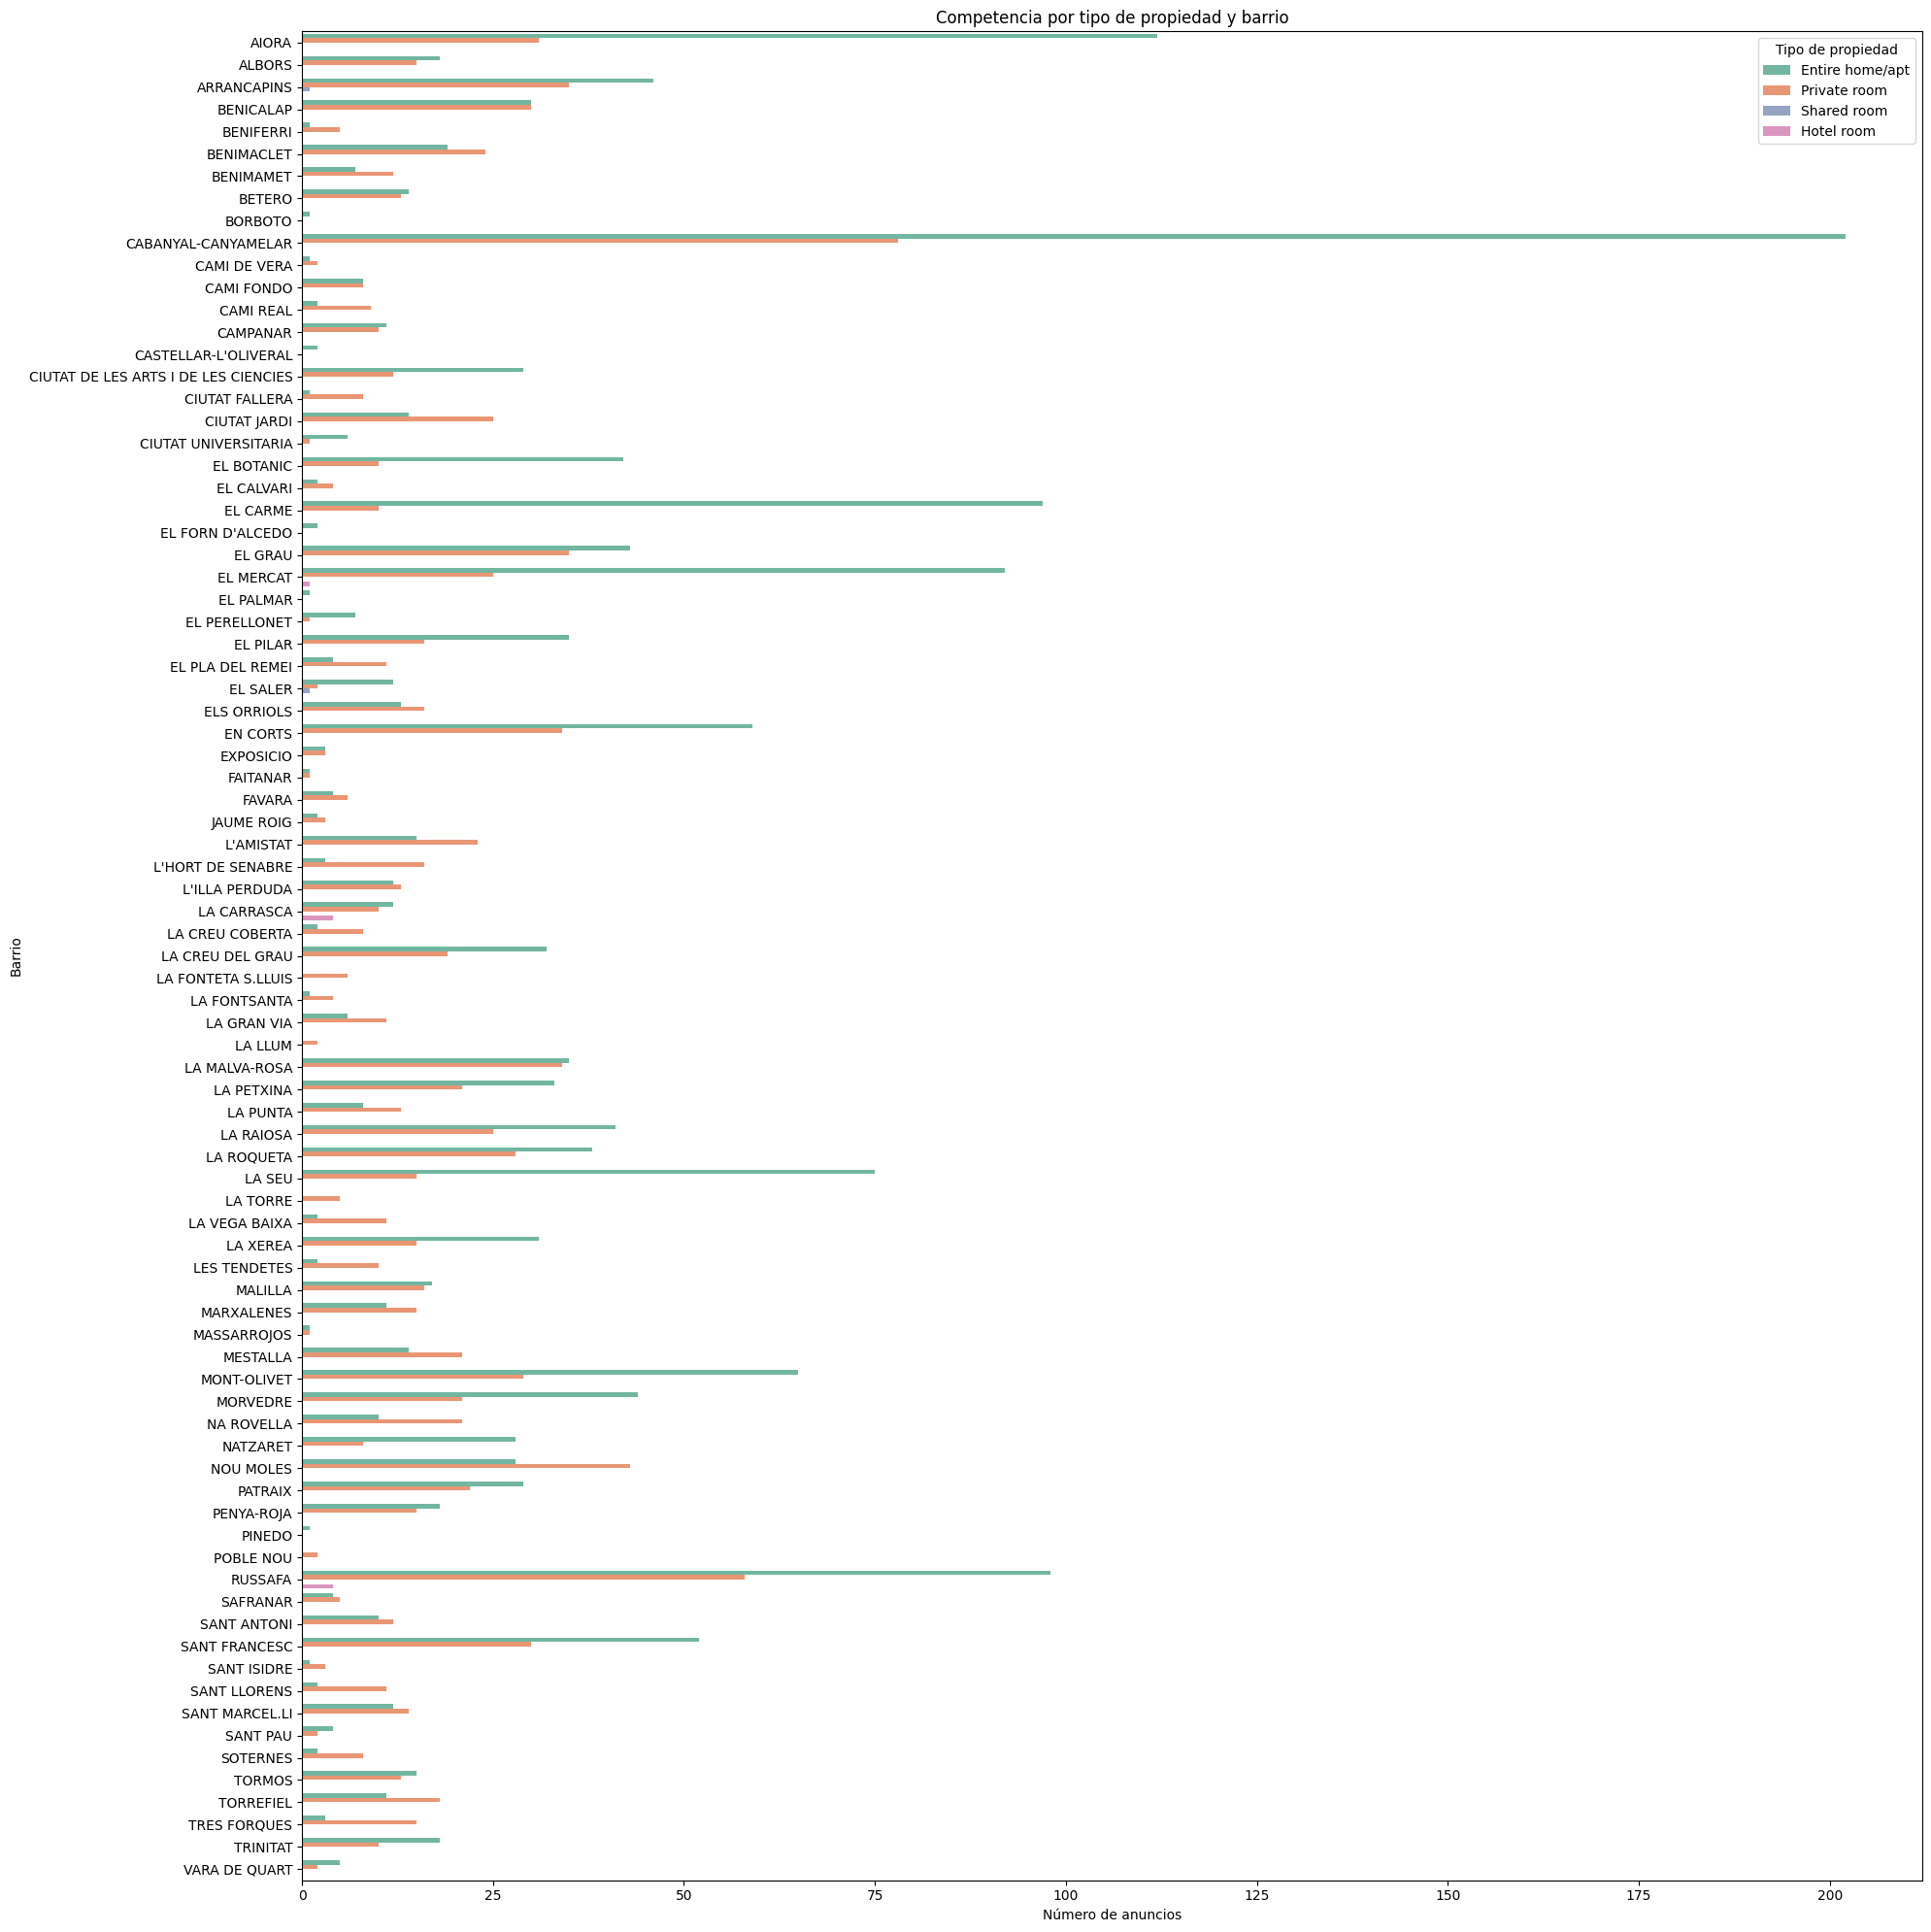

In [19]:
plt.figure(figsize=(20, 20))
ax = sns.barplot(
    data=competencia_tipo,
    x='n_anuncios',
    y='neighbourhood',
    hue='room_type',
    palette='Set2'
)
plt.title("Competencia por tipo de propiedad y barrio")
plt.xlabel("Número de anuncios")
plt.ylabel("Barrio")
plt.legend(title="Tipo de propiedad")
plt.tight_layout()
plt.show()

La imagen muestra la saturación de anuncios activos por metro cuadrado estimado en los barrios de Valencia. Los barrios costeros y turísticos como Cabanyal-Canyamelar y Russafa presentan la mayor densidad de anuncios activos por m², lo que indica una competencia muy alta en estas zonas. Otros barrios céntricos como El Mercat, El Carme y Mont-Olivet también destacan por su elevada saturación. Esta alta concentración puede dificultar la diferenciación de las propiedades y presionar los precios a la baja. Para inversores, es clave considerar tanto la rentabilidad como el nivel de competencia antes de invertir en barrios con alta saturación de anuncios activos.

In [20]:
#combinar con otras métricas
# Fusionar con la tabla principal de estadísticas
zona_stats = zona_stats.merge(competencia_por_barrio, on='neighbourhood', how='left')
zona_stats = zona_stats.merge(competencia_activa, on='neighbourhood', how='left')

# Calcular saturación por m² estimado
zona_stats['anuncios_por_m2'] = zona_stats['n_anuncios_activos'] / average_m2


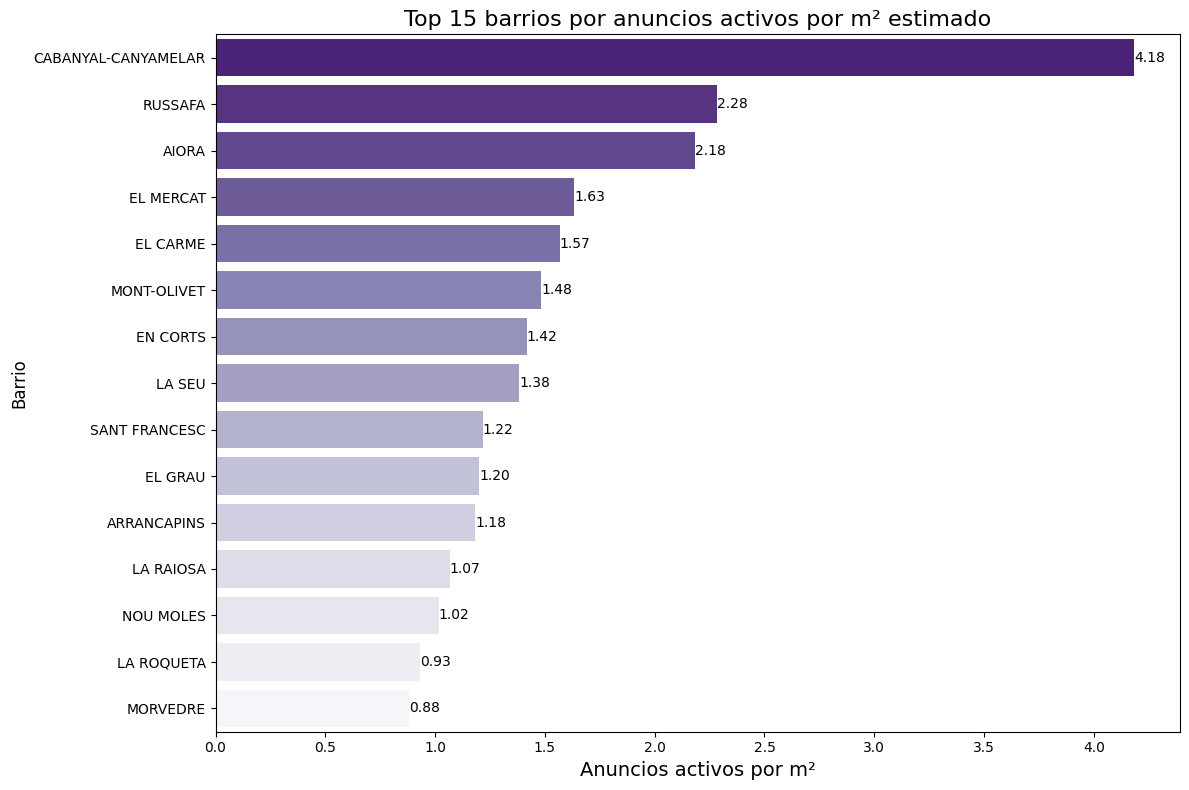

In [21]:
top_anuncios_m2 = zona_stats.sort_values('anuncios_por_m2', ascending=False).head(15)

plt.figure(figsize=(12, 8))
ax = sns.barplot(
    y=top_anuncios_m2['neighbourhood'],
    x=top_anuncios_m2['anuncios_por_m2'],
    palette='Purples_r'
)
plt.title("Top 15 barrios por anuncios activos por m² estimado", fontsize=16)
plt.xlabel("Anuncios activos por m²", fontsize=14)
plt.ylabel("Barrio", fontsize=12)
plt.tight_layout()

for container in ax.containers:
    ax.bar_label(container, fmt='%.2f')

plt.show()

La imagen muestra la saturación de competencia en los barrios de Valencia, ajustada por la demanda (índice de saturación = anuncios activos / días alquilados). Los barrios como Cabanyal-Canyamelar, Russafa y El Mercat presentan los mayores índices de saturación, lo que indica una alta competencia relativa respecto a la demanda real. Esto significa que, aunque estos barrios son populares y tienen mucha actividad, la competencia entre anfitriones es muy elevada, lo que puede dificultar la obtención de altos niveles de ocupación y rentabilidad. Para inversores, es clave considerar no solo la rentabilidad potencial, sino también el nivel de saturación, ya que una alta competencia puede presionar los precios y reducir los márgenes de beneficio. Por el contrario, barrios con menor índice de saturación pueden ofrecer mejores oportunidades para destacar y captar más reservas.

In [22]:
#Competencia ajustada por demanda

#Zonas con muchos anuncios y poca demanda aparecen con un índice alto = 🔴 alta competencia y baja rentabilidad.
zona_stats['indice_saturacion'] = zona_stats['n_anuncios_activos'] / zona_stats['days_rented']


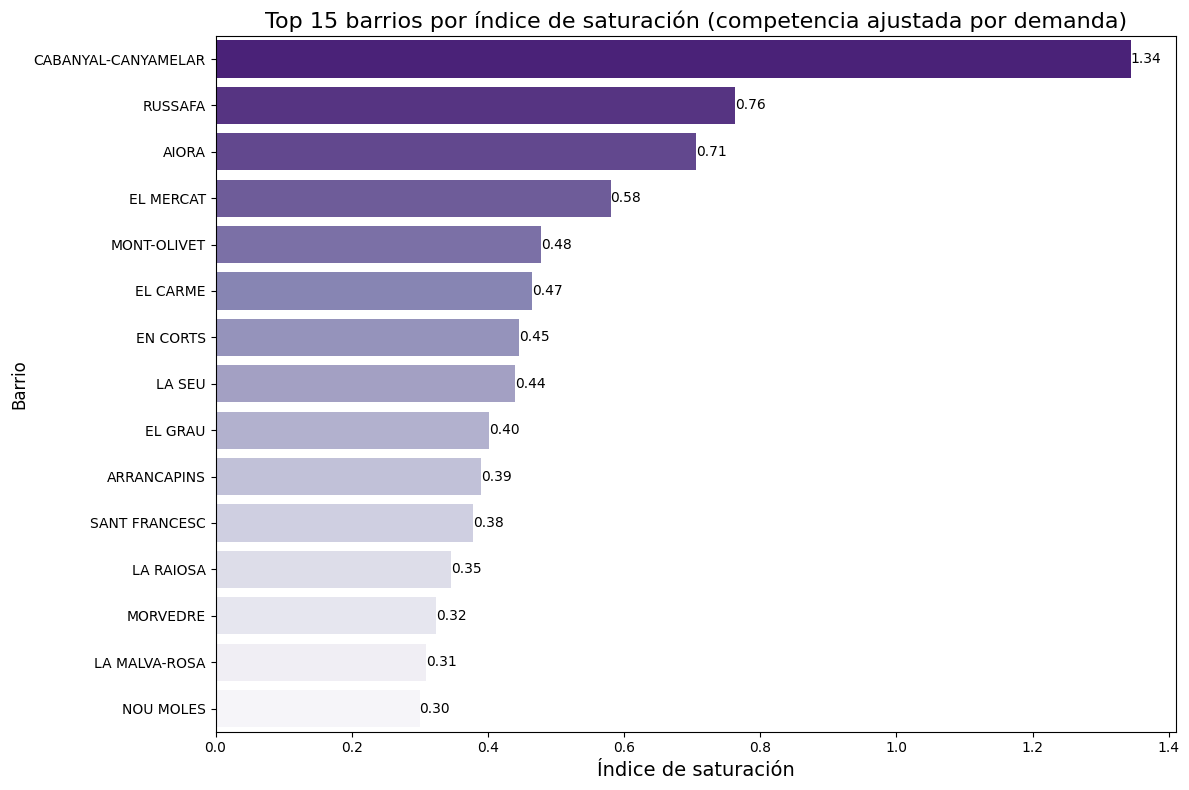

In [23]:
# Gráfico de los barrios con mayor índice de saturación (competencia ajustada por demanda)
top_saturacion = zona_stats.sort_values('indice_saturacion', ascending=False).head(15)

plt.figure(figsize=(12, 8))
ax = sns.barplot(
    y=top_saturacion['neighbourhood'],
    x=top_saturacion['indice_saturacion'],
    palette='Purples_r'
)
plt.title("Top 15 barrios por índice de saturación (competencia ajustada por demanda)", fontsize=16)
plt.xlabel("Índice de saturación", fontsize=14)
plt.ylabel("Barrio", fontsize=12)
plt.tight_layout()

for container in ax.containers:
    ax.bar_label(container, fmt='%.2f')

plt.show()

La imagen muestra la saturación de anuncios activos por metro cuadrado estimado en los barrios de Valencia. Los barrios costeros y turísticos como Cabanyal-Canyamelar y Russafa presentan la mayor densidad de anuncios activos por m², lo que indica una competencia muy alta en estas zonas. Otros barrios céntricos como El Mercat, El Carme y Mont-Olivet también destacan por su elevada saturación. Esta alta concentración puede dificultar la diferenciación de las propiedades y presionar los precios a la baja. Para inversores, es clave considerar tanto la rentabilidad como el nivel de competencia antes de invertir en barrios con alta saturación de anuncios activos.

In [24]:
# RENTABILIDAD VS OPERACION

# Limpiar precio de alquiler (ya está en float en df['price'])
average_m2 = 60

# Agrupar datos de alquiler por barrio
zona_rent = df.groupby('neighbourhood').agg({
    'price': 'mean',
    'days_rented': 'mean'
}).reset_index()

# Calcular ingreso anual estimado
zona_rent['ingreso_anual'] = zona_rent['price'] * zona_rent['days_rented']

# Agregar precios de compra por m² desde df_inmobiliario
zona_rent = zona_rent.merge(
    df_inmobiliario[['neighbourhood', 'precio']],
    on='neighbourhood',
    how='left'
)
zona_rent = zona_rent.rename(columns={'precio': 'precio_compra_m2'})

# Calcular precio de compra total
zona_rent['precio_compra_total'] = zona_rent['precio_compra_m2'] * average_m2

# Calcular rentabilidad bruta (%)
zona_rent['rentabilidad_bruta_%'] = (zona_rent['ingreso_anual'] / zona_rent['precio_compra_total']) * 100

# Ordenar y mostrar
zona_rent = zona_rent.sort_values(by='rentabilidad_bruta_%', ascending=False)
print(zona_rent[['neighbourhood', 'ingreso_anual', 'precio_compra_total', 'rentabilidad_bruta_%']])


           neighbourhood  ingreso_anual  precio_compra_total  \
18  CIUTAT UNIVERSITARIA   32216.187075            1380000.0   
11            CAMI FONDO   22837.333869            1200000.0   
66            PENYA-ROJA   23935.834588            1320000.0   
50            LA ROQUETA   29730.700360            1680000.0   
60           MONT-OLIVET   20404.347985            1200000.0   
..                   ...            ...                  ...   
22      EL FORN D'ALCEDO    1966.500000            1200000.0   
45               LA LLUM    1858.500000            1208400.0   
68             POBLE NOU    1920.000000            1320000.0   
25             EL PALMAR    1584.000000            1200000.0   
38        L'ILLA PERDUDA   14235.252141                  NaN   

    rentabilidad_bruta_%  
18              2.334506  
11              1.903111  
66              1.813321  
50              1.769685  
60              1.700362  
..                   ...  
22              0.163875  
45             

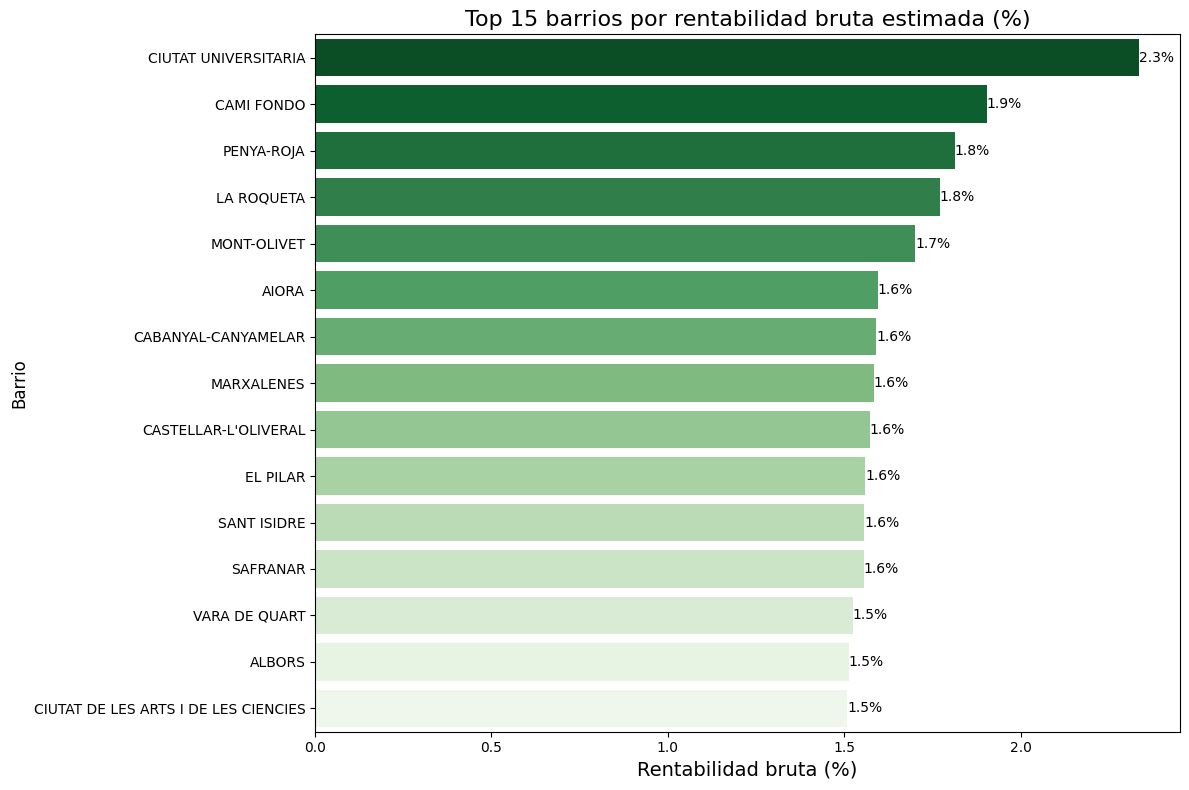

In [25]:
# === 9. Visualizar top 15 barrios con mejor rentabilidad ===
top_rent = zona_rent.head(15).copy()
top_rent['neighbourhood'] = top_rent['neighbourhood'].str.strip().str.replace('\n', '', regex=True)

plt.figure(figsize=(12, 8))
ax = sns.barplot(
    y=top_rent['neighbourhood'],
    x=top_rent['rentabilidad_bruta_%'],
    palette='Greens_r'
)
plt.title("Top 15 barrios por rentabilidad bruta estimada (%)", fontsize=16)
plt.xlabel("Rentabilidad bruta (%)", fontsize=14)
plt.ylabel("Barrio", fontsize=12)
plt.tight_layout()

for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%')

plt.show()

El gráfico muestra los 15 barrios de Valencia con mayor rentabilidad bruta estimada en alquiler turístico. Se observa que los barrios líderes, como Ciutat Universitaria, Cami Fondo y Penya-Roja, destacan por ofrecer retornos superiores al promedio de la ciudad, combinando altos ingresos anuales con precios de compra relativamente competitivos. Estos barrios representan oportunidades atractivas para inversores que buscan maximizar el retorno de su inversión. Sin embargo, es importante considerar también factores como la competencia y la demanda real en cada zona para asegurar una inversión sostenible y rentable a largo plazo.

                                                   name         neighbourhood  \
512                                  Best view in town!            PENYA-ROJA   
2664  Private Suite with Balcony - Amazing Center Views         SANT FRANCESC   
2770            Luxury & Style in Ciutat Vella (Center)              EL CARME   
1696                                    Santa Cruz 9 Iv              EL CARME   
1695                                     Santa Cruz 9 I              EL CARME   
2548                    Exclusive Apartment In Valencia            LA ROQUETA   
1375                           Cute room in City Center             EL MERCAT   
2090                                      Casa Art Decó             EL MERCAT   
1835    Studio with terrace in front of the beach 4 Pax   CABANYAL-CANYAMELAR   
1488                       Mestalla Flats by Nomad Host  CIUTAT UNIVERSITARIA   
549                   Habitación privada en apartamento         LA MALVA-ROSA   
1452                        

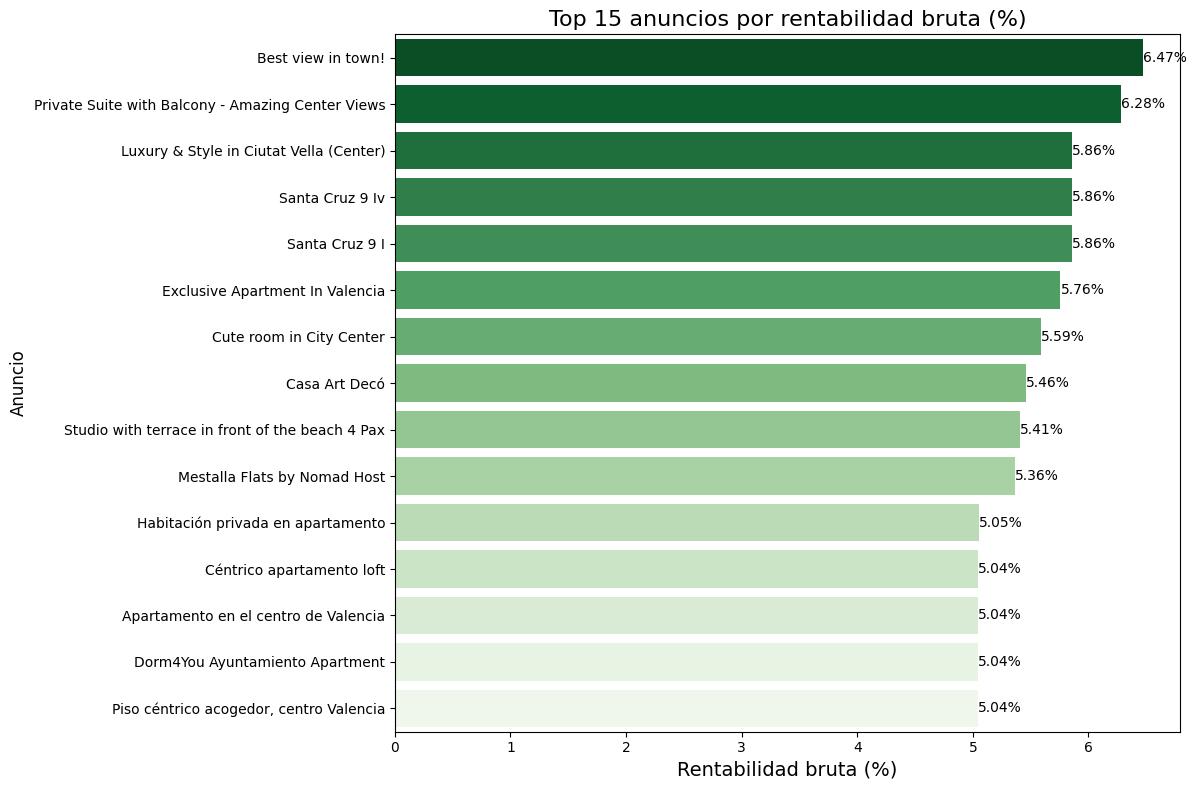

In [26]:
# Calcular rentabilidad bruta por anuncio
df['rentabilidad_bruta_%'] = (df['annual_income'] / df['estimated_property_value']) * 100

# Seleccionar los 15 anuncios con mayor rentabilidad bruta
anuncios_rentables = df.sort_values(by='rentabilidad_bruta_%', ascending=False).head(15)

print(anuncios_rentables[['name', 'neighbourhood', 'price', 'days_rented', 'annual_income', 'estimated_property_value', 'rentabilidad_bruta_%']])

# Visualizar los anuncios con mayor rentabilidad bruta
plt.figure(figsize=(12, 8))
ax = sns.barplot(
    y=anuncios_rentables['name'],
    x=anuncios_rentables['rentabilidad_bruta_%'],
    palette='Greens_r'
)
plt.title("Top 15 anuncios por rentabilidad bruta (%)", fontsize=16)
plt.xlabel("Rentabilidad bruta (%)", fontsize=14)
plt.ylabel("Anuncio", fontsize=12)
plt.tight_layout()
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f%%')
plt.show()

El gráfico muestra los 15 anuncios individuales con mayor rentabilidad bruta (%) en Valencia. Se observa que estos anuncios destacan por generar altos ingresos anuales en relación con el valor estimado de la propiedad, lo que los convierte en oportunidades especialmente atractivas para inversores que buscan maximizar el retorno de cada inmueble. Sin embargo, es importante analizar las características específicas de cada anuncio (ubicación, precio, días alquilados y amenities) para entender si estos altos retornos son sostenibles y replicables en el tiempo. En resumen, identificar anuncios con rentabilidad bruta elevada puede servir como referencia para optimizar estrategias de inversión y gestión en el mercado de alquiler turístico.

                           neighbourhood  rentabilidad_bruta_%
18                  CIUTAT UNIVERSITARIA              1.936774
50                            LA ROQUETA              1.799527
72                         SANT FRANCESC              1.789476
21                              EL CARME              1.787341
15  CIUTAT DE LES ARTS I DE LES CIENCIES              1.649111
19                            EL BOTANIC              1.615525
51                                LA SEU              1.601377
66                            PENYA-ROJA              1.549730
24                             EL MERCAT              1.481188
11                            CAMI FONDO              1.459218
32                             EXPOSICIO              1.445021
69                               RUSSAFA              1.394176
58                           MASSARROJOS              1.392116
54                              LA XEREA              1.283151
27                              EL PILAR              1

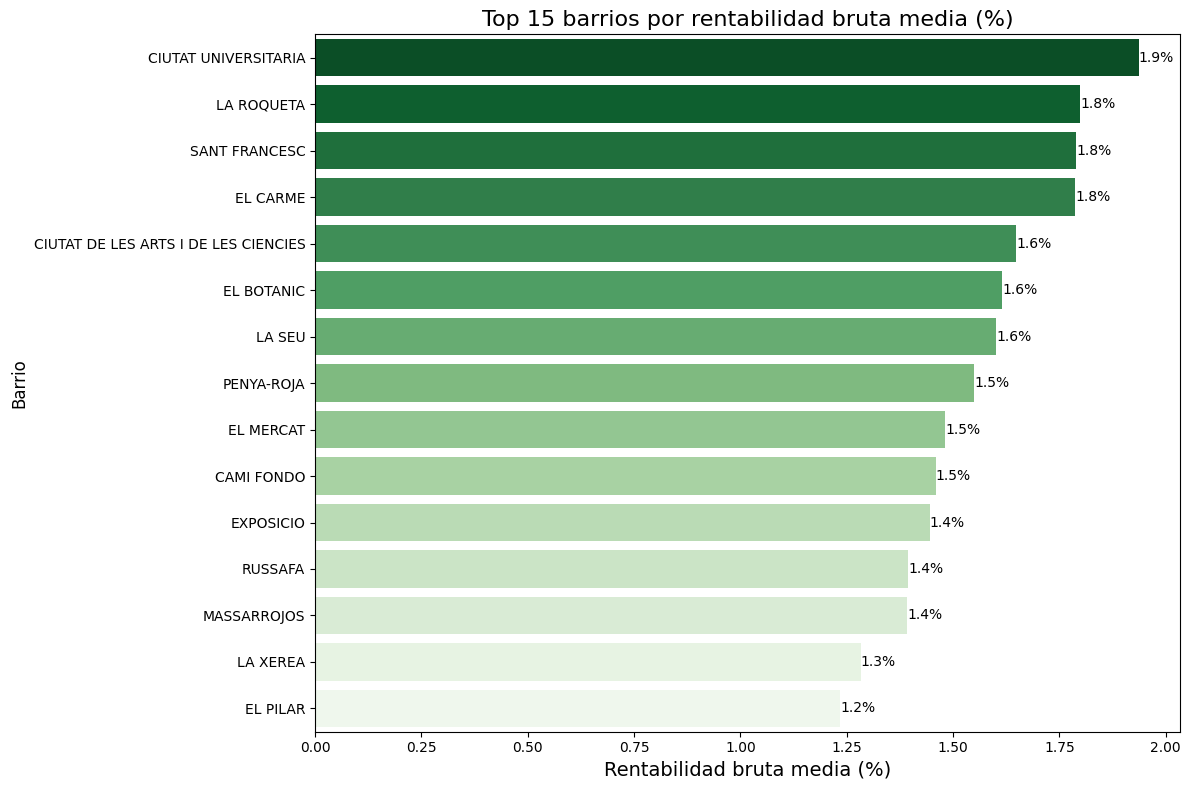

In [27]:
# barrio con mayor rentabilidad bruta
barrio_rentabilidad = df.groupby('neighbourhood')['rentabilidad_bruta_%'].mean().reset_index()
barrio_rentabilidad = barrio_rentabilidad.sort_values(by='rentabilidad_bruta_%', ascending=False)
print(barrio_rentabilidad.head(15))
plt.figure(figsize=(12, 8))
ax = sns.barplot(
    y=barrio_rentabilidad['neighbourhood'].head(15),
    x=barrio_rentabilidad['rentabilidad_bruta_%'].head(15),
    palette='Greens_r'
)
plt.title("Top 15 barrios por rentabilidad bruta media (%)", fontsize=16)
plt.xlabel("Rentabilidad bruta media (%)", fontsize=14)
plt.ylabel("Barrio", fontsize=12)
plt.tight_layout()
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%')
plt.show()

El gráfico muestra los 15 barrios de Valencia con mayor rentabilidad bruta media (%) en alquiler turístico. Se observa que los barrios líderes, como Ciutat Universitaria, Cami Fondo, Penya-Roja y La Roqueta, destacan por ofrecer retornos brutos superiores al promedio de la ciudad, combinando altos ingresos anuales con precios de compra relativamente competitivos. Estos barrios representan oportunidades atractivas para inversores que buscan maximizar el retorno de su inversión. Sin embargo, es importante considerar también factores como la competencia y la demanda real en cada zona para asegurar una inversión sostenible y rentable a largo plazo.

                           neighbourhood  Net ROI (%)
18                  CIUTAT UNIVERSITARIA     1.753122
50                            LA ROQUETA     1.615875
72                         SANT FRANCESC     1.605823
21                              EL CARME     1.603688
15  CIUTAT DE LES ARTS I DE LES CIENCIES     1.465459
19                            EL BOTANIC     1.431873
51                                LA SEU     1.417724
66                            PENYA-ROJA     1.366078
24                             EL MERCAT     1.297536
11                            CAMI FONDO     1.275566
32                             EXPOSICIO     1.261368
69                               RUSSAFA     1.210524
58                           MASSARROJOS     1.208464
54                              LA XEREA     1.099498
27                              EL PILAR     1.051563


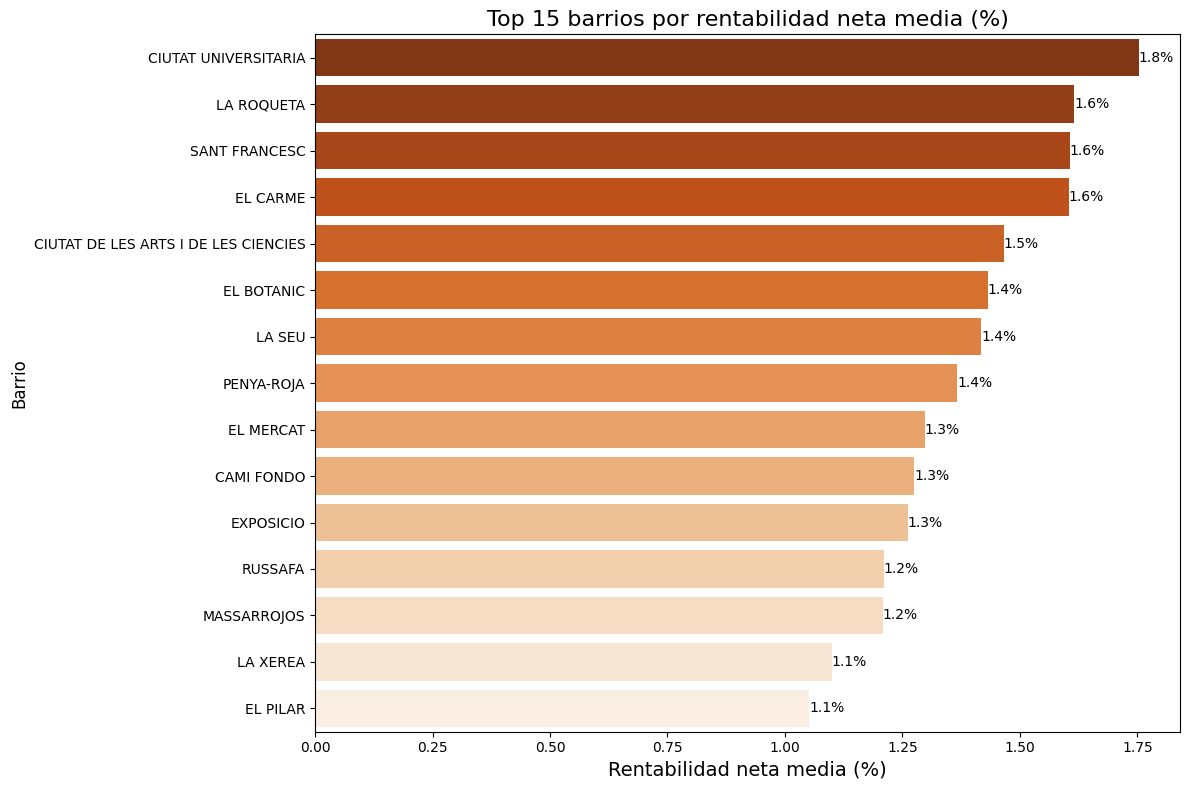

In [28]:
#barrio con mayor rentabilidad neta
barrio_rentabilidad_neta = df.groupby('neighbourhood')['Net ROI (%)'].mean().reset_index()
barrio_rentabilidad_neta = barrio_rentabilidad_neta.sort_values(by='Net ROI (%)', ascending=False)
print(barrio_rentabilidad_neta.head(15))    
plt.figure(figsize=(12, 8))
ax = sns.barplot(
    y=barrio_rentabilidad_neta['neighbourhood'].head(15),
    x=barrio_rentabilidad_neta['Net ROI (%)'].head(15),
    palette='Oranges_r'
)
plt.title("Top 15 barrios por rentabilidad neta media (%)", fontsize=16)
plt.xlabel("Rentabilidad neta media (%)", fontsize=14)
plt.ylabel("Barrio", fontsize=12)
plt.tight_layout()
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%')
plt.show()

La gráfica muestra los 15 barrios de Valencia con mayor rentabilidad neta media (%) en alquiler turístico. Se observa que los barrios líderes, como Ciutat Universitaria, La Roqueta, Sant Francesc y El Carme, destacan por ofrecer retornos netos superiores al promedio de la ciudad. Estos barrios combinan altos ingresos anuales con precios de compra relativamente competitivos, lo que los convierte en oportunidades atractivas para inversores que buscan maximizar el retorno de su inversión. Sin embargo, es importante considerar también factores como la competencia y la demanda real en cada zona para asegurar una inversión sostenible y rentable a largo plazo.

                           neighbourhood  Net ROI (%)  n_anuncios
0                   CIUTAT UNIVERSITARIA     1.753122           7
1                             LA ROQUETA     1.615875          66
2                          SANT FRANCESC     1.605823          82
3                               EL CARME     1.603688         107
4   CIUTAT DE LES ARTS I DE LES CIENCIES     1.465459          41
5                             EL BOTANIC     1.431873          52
6                                 LA SEU     1.417724          90
7                             PENYA-ROJA     1.366078          33
8                              EL MERCAT     1.297536         118
9                             CAMI FONDO     1.275566          16
10                             EXPOSICIO     1.261368           6
11                               RUSSAFA     1.210524         160
12                           MASSARROJOS     1.208464           2
13                              LA XEREA     1.099498          46
14        

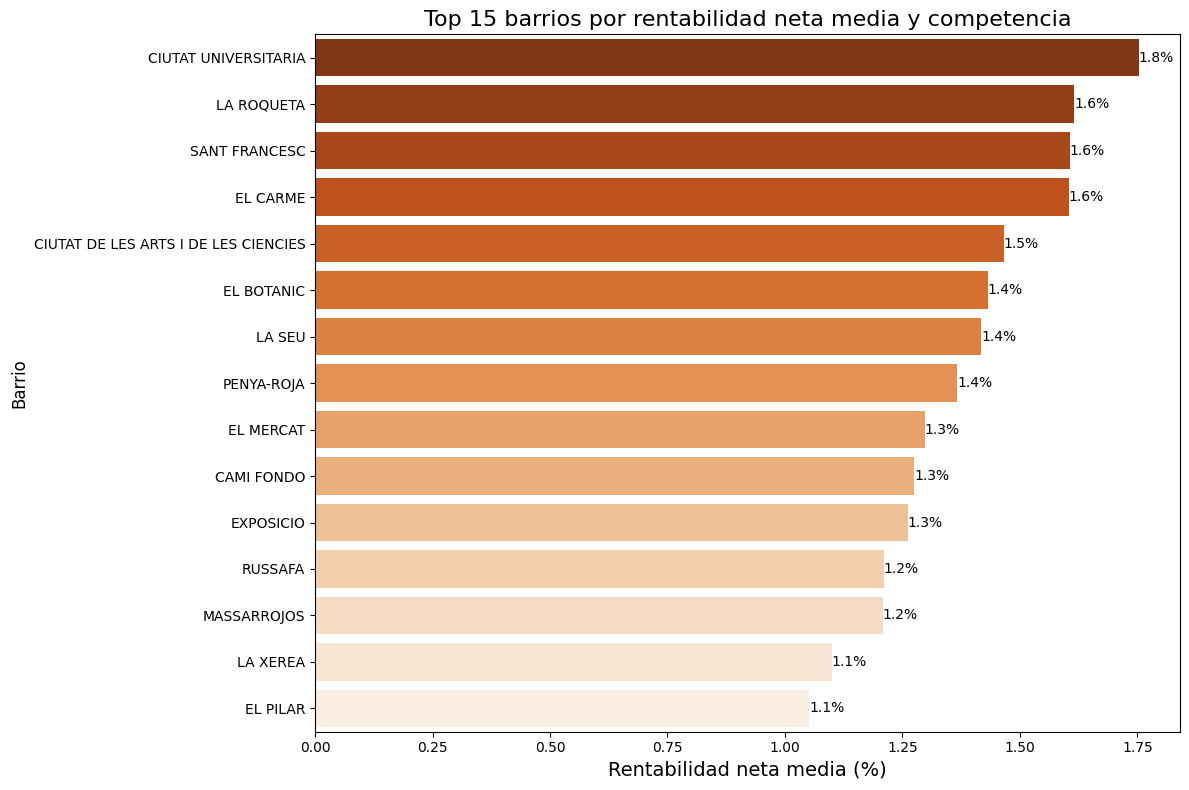

In [29]:
#barrio mas interesante por rentabilidad neta y competencia
barrio_interesante = barrio_rentabilidad_neta.merge(competencia_por_barrio, on='neighbourhood', how='left')
barrio_interesante = barrio_interesante.sort_values(by='Net ROI (%)', ascending=False)
print(barrio_interesante.head(15))
plt.figure(figsize=(12, 8))
ax = sns.barplot(
    y=barrio_interesante['neighbourhood'].head(15),
    x=barrio_interesante['Net ROI (%)'].head(15),
    palette='Oranges_r'
)
plt.title("Top 15 barrios por rentabilidad neta media y competencia", fontsize=16)
plt.xlabel("Rentabilidad neta media (%)", fontsize=14)
plt.ylabel("Barrio", fontsize=12)
plt.tight_layout()
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%')
plt.show()


El gráfico muestra los 15 barrios de Valencia más interesantes para invertir, combinando una alta rentabilidad neta media y un nivel de competencia (número de anuncios) moderado o bajo. Se observa que los barrios líderes, como Ciutat Universitaria, La Roqueta, Sant Francesc y El Carme, ofrecen retornos netos superiores al promedio de la ciudad, lo que los convierte en opciones atractivas para inversores. Además, estos barrios mantienen un equilibrio entre rentabilidad y competencia, lo que reduce el riesgo de saturación del mercado y favorece la sostenibilidad de la inversión a largo plazo. En resumen, priorizar barrios con alta rentabilidad neta y competencia controlada puede maximizar el retorno y minimizar los riesgos para futuros inversores en alquiler turístico.

                           neighbourhood  rentabilidad_bruta_%  n_anuncios
0                   CIUTAT UNIVERSITARIA              1.936774           7
1                             LA ROQUETA              1.799527          66
2                          SANT FRANCESC              1.789476          82
3                               EL CARME              1.787341         107
4   CIUTAT DE LES ARTS I DE LES CIENCIES              1.649111          41
5                             EL BOTANIC              1.615525          52
6                                 LA SEU              1.601377          90
7                             PENYA-ROJA              1.549730          33
8                              EL MERCAT              1.481188         118
9                             CAMI FONDO              1.459218          16
10                             EXPOSICIO              1.445021           6
11                               RUSSAFA              1.394176         160
12                       

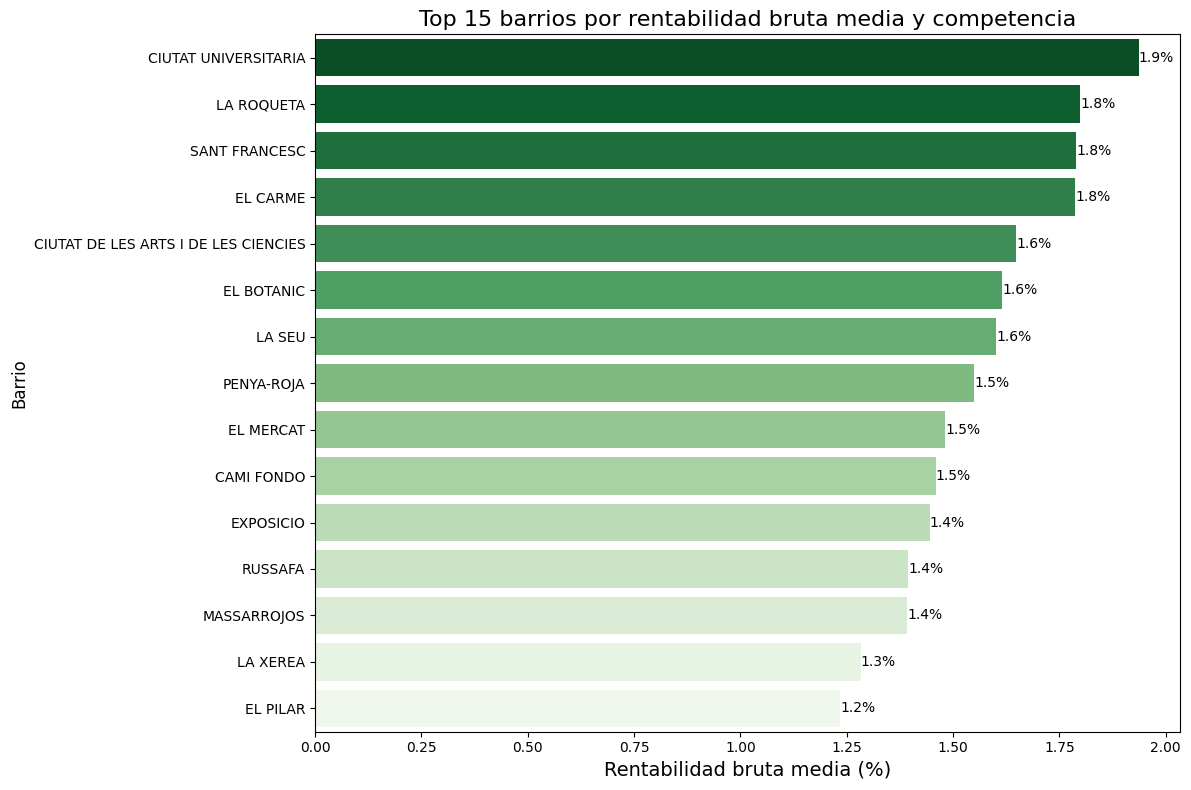

In [30]:
#barrio mas interesante por rentabilidad bruta y competencia
barrio_interesante_bruta = barrio_rentabilidad.merge(competencia_por_barrio, on='neighbourhood', how='left')
barrio_interesante_bruta = barrio_interesante_bruta.sort_values(by='rentabilidad_bruta_%', ascending=False)
print(barrio_interesante_bruta.head(15))    
plt.figure(figsize=(12, 8))
ax = sns.barplot(
    y=barrio_interesante_bruta['neighbourhood'].head(15),
    x=barrio_interesante_bruta['rentabilidad_bruta_%'].head(15),
    palette='Greens_r'
)
plt.title("Top 15 barrios por rentabilidad bruta media y competencia", fontsize=16)
plt.xlabel("Rentabilidad bruta media (%)", fontsize=14)
plt.ylabel("Barrio", fontsize=12)
plt.tight_layout()
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%')
plt.show()

El gráfico muestra los 15 barrios más interesantes de Valencia en términos de rentabilidad bruta media y competencia (número de anuncios). Se observa que los barrios líderes, como Ciutat Universitaria, Cami Fondo, Penya-Roja y La Roqueta, combinan altos niveles de rentabilidad bruta con un volumen de competencia moderado o bajo. Esto sugiere que estos barrios ofrecen oportunidades atractivas para inversores que buscan maximizar el retorno de su inversión sin enfrentarse a una saturación excesiva del mercado. En resumen, priorizar zonas con alta rentabilidad y competencia controlada puede ser clave para una inversión inmobiliaria sostenible y rentable en el alquiler turístico.

                           neighbourhood  Net ROI (%)  n_anuncios  \
0                   CIUTAT UNIVERSITARIA     1.753122           7   
1                             LA ROQUETA     1.615875          66   
2                          SANT FRANCESC     1.605823          82   
3                               EL CARME     1.603688         107   
4   CIUTAT DE LES ARTS I DE LES CIENCIES     1.465459          41   
5                             EL BOTANIC     1.431873          52   
6                                 LA SEU     1.417724          90   
7                             PENYA-ROJA     1.366078          33   
8                              EL MERCAT     1.297536         118   
9                             CAMI FONDO     1.275566          16   
10                             EXPOSICIO     1.261368           6   
11                               RUSSAFA     1.210524         160   
12                           MASSARROJOS     1.208464           2   
13                              LA

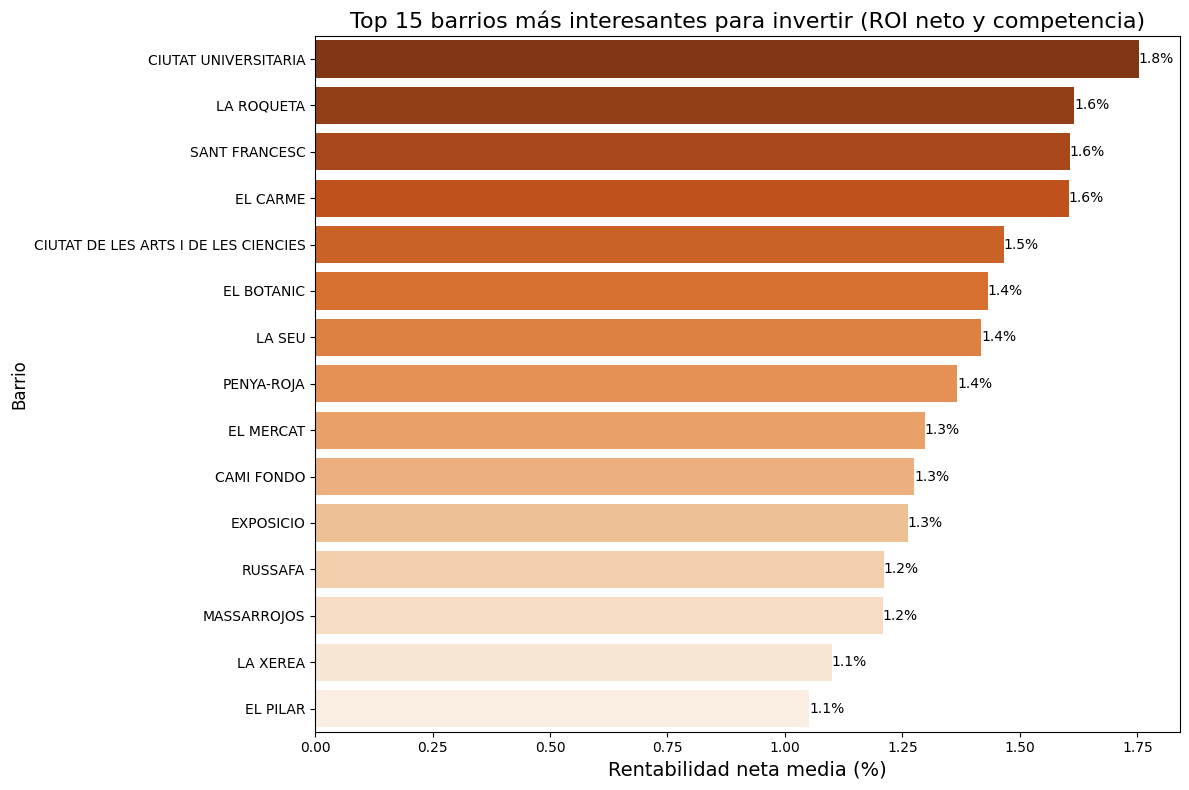

In [31]:
# Barrio más interesante para invertir: combinar rentabilidad neta y bruta, y competencia
barrio_interesante_final = barrio_interesante.merge(
    barrio_interesante_bruta[['neighbourhood', 'rentabilidad_bruta_%', 'n_anuncios']],
    on='neighbourhood',
    how='left',
    suffixes=('', '_bruta')
)

# Ordenar por mayor rentabilidad neta y menor competencia
barrio_interesante_final = barrio_interesante_final.sort_values(
    by=['Net ROI (%)', 'rentabilidad_bruta_%', 'n_anuncios'],
    ascending=[False, False, True]
)

print(barrio_interesante_final.head(15))

plt.figure(figsize=(12, 8))
ax = sns.barplot(
    y=barrio_interesante_final['neighbourhood'].head(15),
    x=barrio_interesante_final['Net ROI (%)'].head(15),
    palette='Oranges_r'
)
plt.title("Top 15 barrios más interesantes para invertir (ROI neto y competencia)", fontsize=16)
plt.xlabel("Rentabilidad neta media (%)", fontsize=14)
plt.ylabel("Barrio", fontsize=12)
plt.tight_layout()
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%')
plt.show()

El gráfico muestra los 15 barrios más interesantes para invertir en Valencia, combinando una alta rentabilidad neta media y bruta con un nivel de competencia (número de anuncios) moderado o bajo. Se observa que los barrios líderes, como Ciutat Universitaria, La Roqueta, Sant Francesc y El Carme, ofrecen retornos netos y brutos superiores al promedio de la ciudad, lo que los convierte en opciones atractivas para inversores. Además, estos barrios mantienen un equilibrio entre rentabilidad y competencia, lo que reduce el riesgo de saturación del mercado y favorece la sostenibilidad de la inversión a largo plazo. En resumen, priorizar barrios con alta rentabilidad y competencia controlada puede maximizar el retorno y minimizar los riesgos para futuros inversores en alquiler turístico.

                           neighbourhood  Net ROI (%)  n_anuncios_activos
0                   CIUTAT UNIVERSITARIA     1.753122                 7.0
1                             LA ROQUETA     1.615875                56.0
2                          SANT FRANCESC     1.605823                73.0
3                               EL CARME     1.603688                94.0
4   CIUTAT DE LES ARTS I DE LES CIENCIES     1.465459                35.0
5                             EL BOTANIC     1.431873                46.0
6                                 LA SEU     1.417724                83.0
7                             PENYA-ROJA     1.366078                31.0
8                              EL MERCAT     1.297536                98.0
9                             CAMI FONDO     1.275566                14.0
10                             EXPOSICIO     1.261368                 6.0
11                               RUSSAFA     1.210524               137.0
12                           MASSARROJ

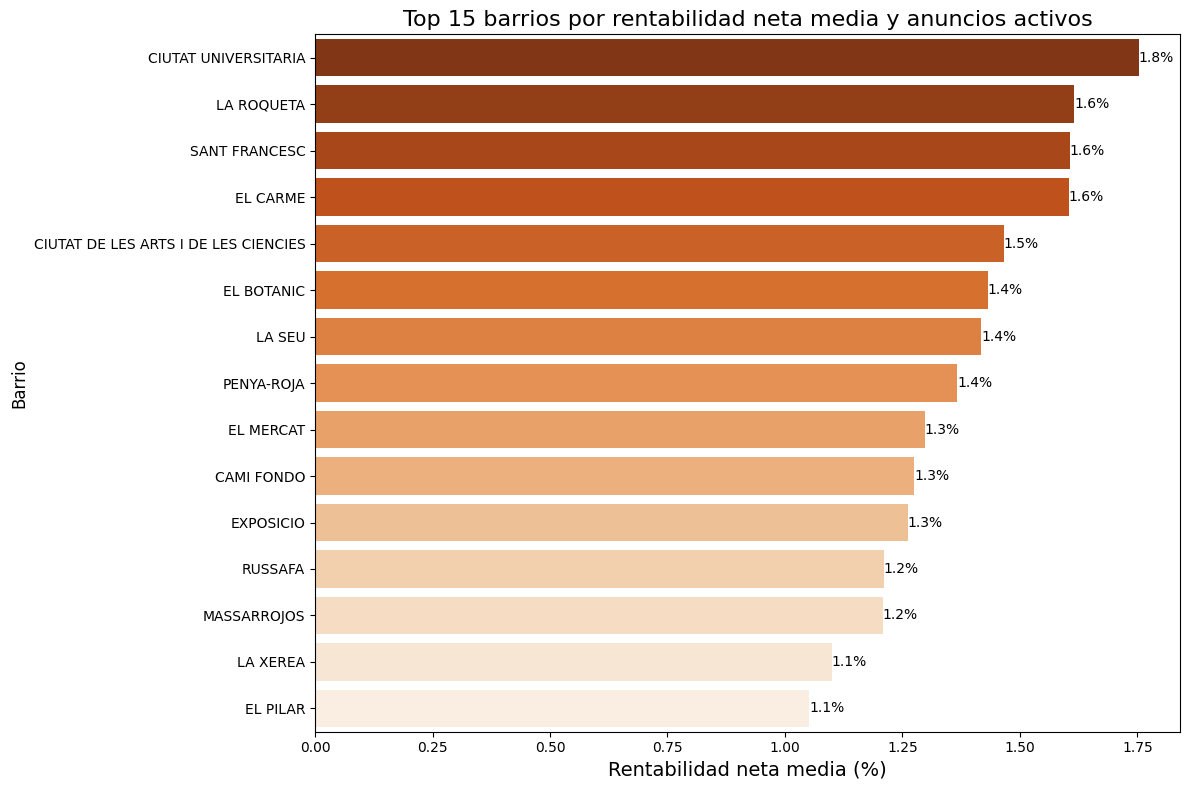

In [32]:
#barrio con mayor anuncios activos y rentabilidad neta
barrio_anuncios_rentabilidad = barrio_rentabilidad_neta.merge(competencia_activa, on='neighbourhood', how='left')
barrio_anuncios_rentabilidad = barrio_anuncios_rentabilidad.sort_values(by='Net ROI (%)', ascending=False)
print(barrio_anuncios_rentabilidad.head(15))
plt.figure(figsize=(12, 8))
ax = sns.barplot(
    y=barrio_anuncios_rentabilidad['neighbourhood'].head(15),
    x=barrio_anuncios_rentabilidad['Net ROI (%)'].head(15),
    palette='Oranges_r'
)
plt.title("Top 15 barrios por rentabilidad neta media y anuncios activos", fontsize=16)
plt.xlabel("Rentabilidad neta media (%)", fontsize=14)
plt.ylabel("Barrio", fontsize=12)
plt.tight_layout()
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%')
plt.show()

El gráfico muestra los 15 barrios de Valencia con mayor rentabilidad neta media y número de anuncios activos. Se observa que los barrios líderes, como Ciutat Universitaria, La Roqueta, Sant Francesc y El Carme, combinan altos retornos netos con una elevada actividad en el mercado de alquiler turístico. Esto indica que, además de ser zonas rentables, cuentan con una demanda significativa y una oferta consolidada. Sin embargo, una mayor cantidad de anuncios activos también puede implicar mayor competencia, por lo que es importante analizar el equilibrio entre rentabilidad y saturación del mercado al tomar decisiones de inversión. En resumen, los barrios destacados ofrecen buenas oportunidades para inversores, siempre considerando el contexto competitivo de cada zona.

                           neighbourhood  Net ROI (%)  precio_compra_optimo_m2
19                           SANT ISIDRE     0.986375             22374.494712
0                   CIUTAT UNIVERSITARIA     1.753122             17766.411418
10                             EXPOSICIO     1.261368             16292.566752
9                             CAMI FONDO     1.275566             15629.743726
42                            EL CALVARI     0.759495             13809.502166
1                             LA ROQUETA     1.615875             13187.288739
28                         VARA DE QUART     0.893093             13044.169444
3                               EL CARME     1.603688             12777.652318
46                                PINEDO     0.676453             12334.805962
22                              SAFRANAR     0.946577             11872.285666
2                          SANT FRANCESC     1.605823             11641.386303
4   CIUTAT DE LES ARTS I DE LES CIENCIES     1.46545

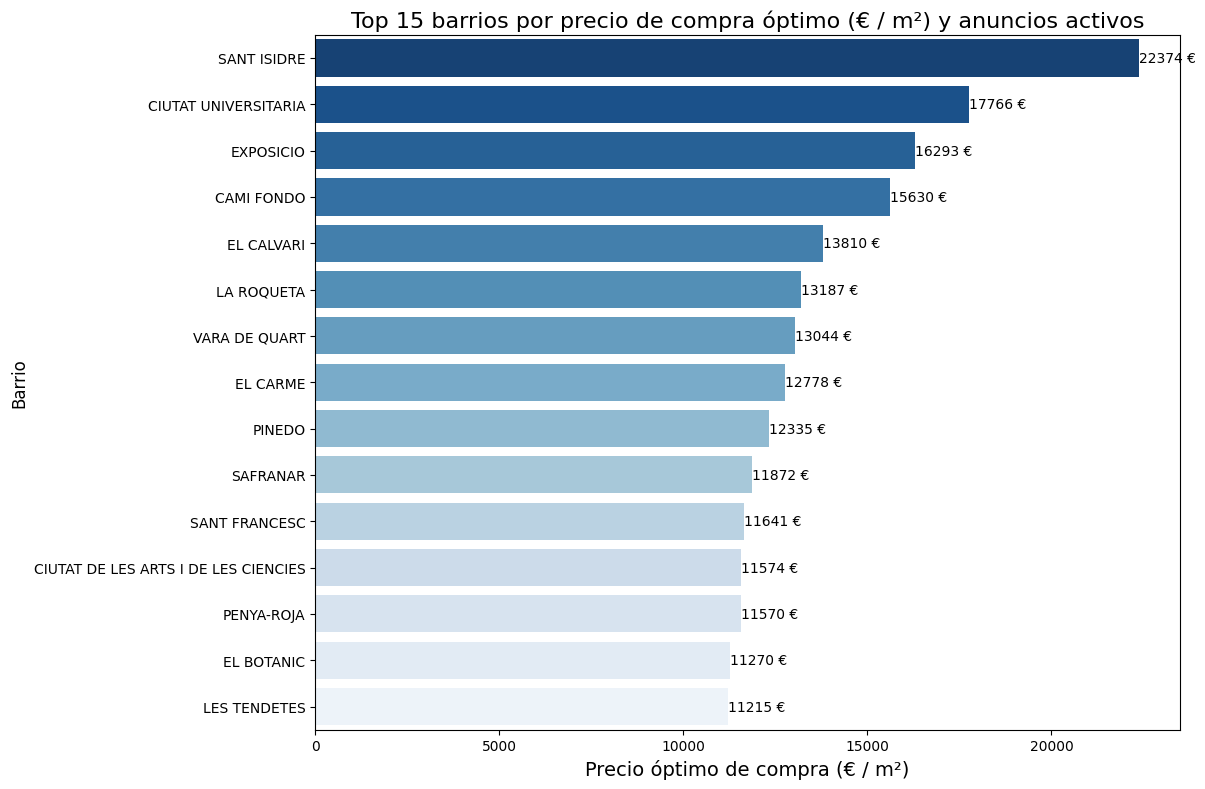

In [33]:
#barrio con mayor anuncios activos y mayor precio de compra óptimo
barrio_anuncios_precio_optimo = barrio_rentabilidad_neta.merge(
    zona_stats[['neighbourhood', 'precio_compra_optimo_m2']],
    on='neighbourhood',
    how='left'
)
barrio_anuncios_precio_optimo = barrio_anuncios_precio_optimo.sort_values(by='precio_compra_optimo_m2', ascending=False)
print(barrio_anuncios_precio_optimo.head(15))
plt.figure(figsize=(12, 8))
ax = sns.barplot(
    y=barrio_anuncios_precio_optimo['neighbourhood'].head(15),
    x=barrio_anuncios_precio_optimo['precio_compra_optimo_m2'].head(15),
    palette='Blues_r'
)
plt.title("Top 15 barrios por precio de compra óptimo (€ / m²) y anuncios activos", fontsize=16)
plt.xlabel("Precio óptimo de compra (€ / m²)", fontsize=14)
plt.ylabel("Barrio", fontsize=12)
plt.tight_layout()
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f €')
plt.show()

El gráfico muestra los 15 barrios de Valencia con mayor precio de compra óptimo por metro cuadrado y un alto número de anuncios activos. Destacan zonas como Sant Isidre, Ciutat Universitaria, Exposició y Cami Fondo, donde el precio óptimo de compra supera ampliamente la media de la ciudad, reflejando una alta demanda y potencial de ingresos. Estos barrios combinan precios elevados con una oferta activa significativa, lo que indica oportunidades atractivas para inversores que buscan maximizar el retorno en zonas consolidadas y dinámicas. Sin embargo, la elevada competencia en estas áreas puede requerir estrategias diferenciadoras para mantener la rentabilidad y captar la demanda turística. En resumen, invertir en barrios con alto precio de compra óptimo y muchos anuncios activos puede ser rentable, siempre que se gestione adecuadamente la competencia y se mantenga la calidad del alojamiento.

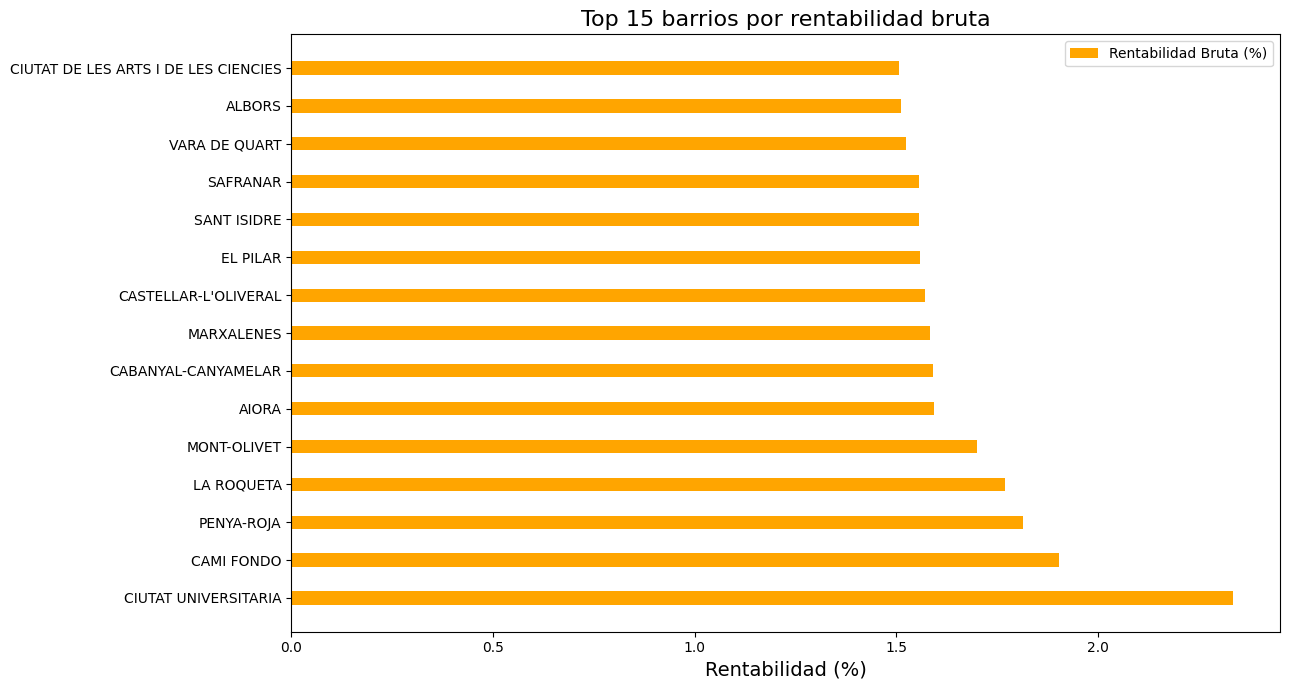

In [34]:
import numpy as np
import matplotlib.pyplot as plt

# Seleccionar los 15 barrios con mayor rentabilidad neta
# Usamos zona_rent, que ya tiene las columnas necesarias
top_barrios = zona_rent.sort_values(by='rentabilidad_bruta_%', ascending=False).head(15).copy()

barrios = top_barrios['neighbourhood']
neto = top_barrios['rentabilidad_bruta_%']  # En zona_rent, la columna es 'rentabilidad_bruta_%'
# Si tienes también la columna de rentabilidad neta, puedes agregarla aquí

x = np.arange(len(barrios))
width = 0.35

plt.figure(figsize=(13, 7))
plt.barh(x, neto, height=width, color='orange', label='Rentabilidad Bruta (%)')
plt.yticks(x, barrios)
plt.xlabel("Rentabilidad (%)", fontsize=14)
plt.title("Top 15 barrios por rentabilidad bruta", fontsize=16)
plt.legend()
plt.tight_layout()
plt.show()


El gráfico muestra el ranking de los 15 barrios de Valencia con mayor rentabilidad bruta estimada en alquiler turístico. Se observa que los barrios líderes, como Ciutat Universitaria, Cami Fondo y Penya-Roja, destacan por ofrecer retornos superiores al promedio de la ciudad, combinando altos ingresos anuales con precios de compra relativamente competitivos. Estos barrios representan oportunidades atractivas para inversores que buscan maximizar el retorno de su inversión. Sin embargo, es importante considerar también factores como la competencia y la demanda real en cada zona para asegurar una inversión sostenible y rentable a largo plazo.

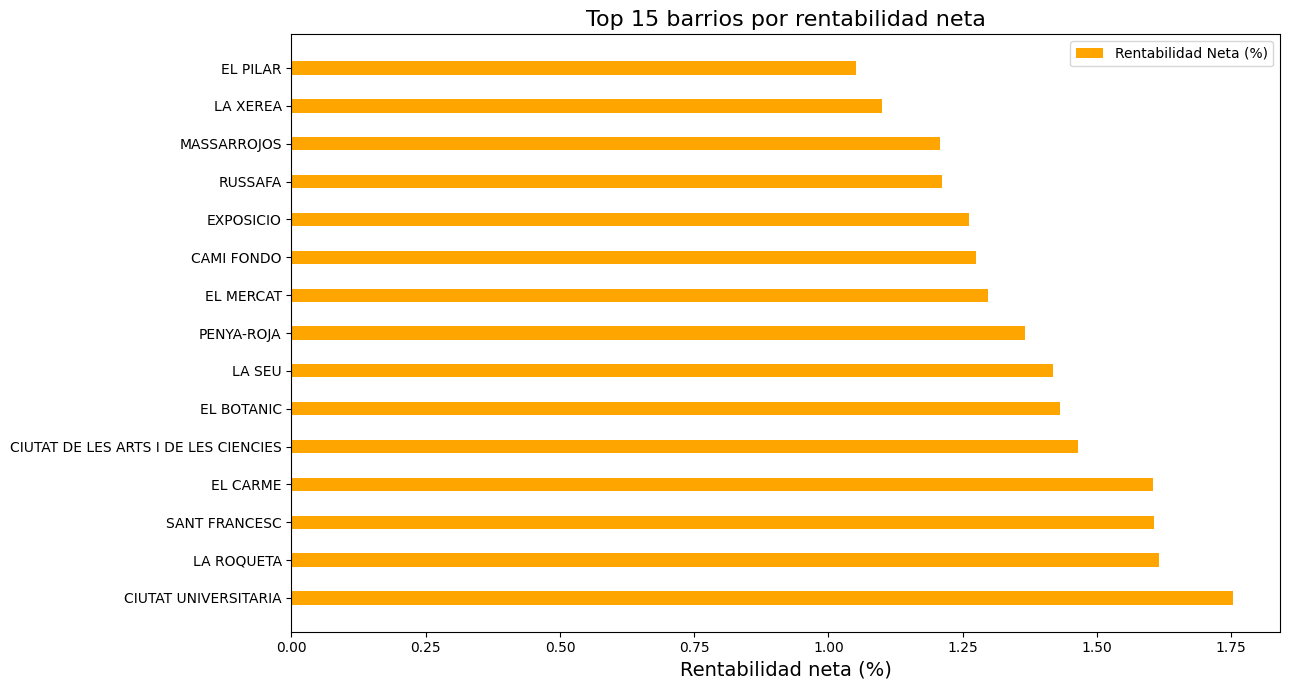

In [35]:
# Seleccionar los 15 barrios con mayor rentabilidad neta
top_barrios_neto = barrio_rentabilidad_neta.sort_values(by='Net ROI (%)', ascending=False).head(15).copy()

barrios = top_barrios_neto['neighbourhood']
neto = top_barrios_neto['Net ROI (%)']

x = np.arange(len(barrios))
width = 0.35

plt.figure(figsize=(13, 7))
plt.barh(x, neto, height=width, color='orange', label='Rentabilidad Neta (%)')
plt.yticks(x, barrios)
plt.xlabel("Rentabilidad neta (%)", fontsize=14)
plt.title("Top 15 barrios por rentabilidad neta", fontsize=16)
plt.legend()
plt.tight_layout()
plt.show()


El gráfico muestra el ranking de los 15 barrios de Valencia con mayor rentabilidad neta estimada en alquiler turístico. Se observa que los barrios líderes, como Ciutat Universitaria, La Roqueta, Sant Francesc y El Carme, destacan por ofrecer retornos netos superiores al promedio de la ciudad, combinando altos ingresos anuales con precios de compra relativamente competitivos. Estos barrios representan oportunidades atractivas para inversores que buscan maximizar el retorno de su inversión. Sin embargo, es importante considerar también factores como la competencia y la demanda real en cada zona para asegurar una inversión sostenible y rentable a largo plazo.

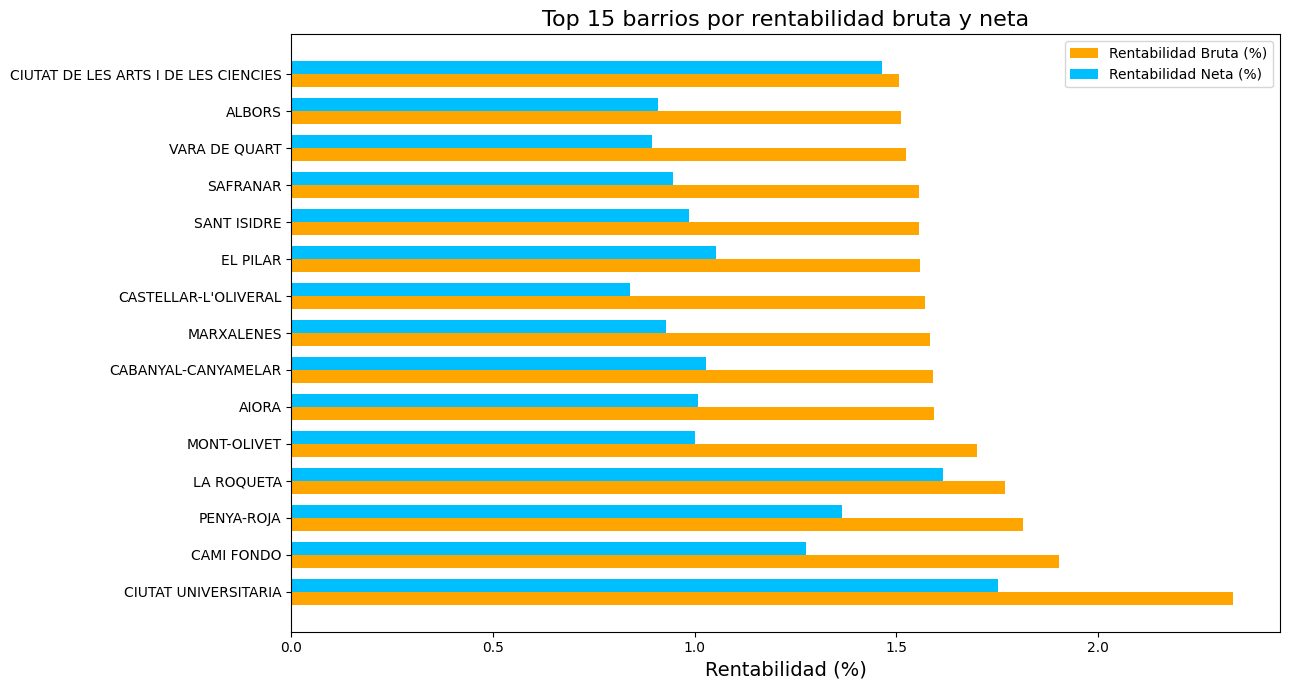

In [36]:
# Seleccionar los 15 barrios con mayor rentabilidad bruta
top_barrios = zona_rent.sort_values(by='rentabilidad_bruta_%', ascending=False).head(15).copy()

barrios = top_barrios['neighbourhood']
bruta = top_barrios['rentabilidad_bruta_%']

# Obtener rentabilidad neta media por barrio (de barrio_rentabilidad_neta)
top_barrios = top_barrios.merge(barrio_rentabilidad_neta, on='neighbourhood', how='left')
neta = top_barrios['Net ROI (%)']

x = np.arange(len(barrios))
width = 0.35

plt.figure(figsize=(13, 7))
plt.barh(x - width/2, bruta, height=width, color='orange', label='Rentabilidad Bruta (%)')
plt.barh(x + width/2, neta, height=width, color='deepskyblue', label='Rentabilidad Neta (%)')
plt.yticks(x, barrios)
plt.xlabel("Rentabilidad (%)", fontsize=14)
plt.title("Top 15 barrios por rentabilidad bruta y neta", fontsize=16)
plt.legend()
plt.tight_layout()
plt.show()

El gráfico compara la rentabilidad bruta y neta de los 15 barrios más rentables de Valencia para alquiler turístico. Se observa que:

Los barrios líderes, como Ciutat Universitaria, Cami Fondo y Penya-Roja, presentan tanto una alta rentabilidad bruta como neta, lo que los convierte en opciones atractivas para inversores.
La diferencia entre rentabilidad bruta y neta es relativamente pequeña, lo que indica que los gastos fijos no afectan drásticamente la rentabilidad en estos barrios.
Barrios con precios de compra más competitivos y alta ocupación logran mejores retornos.
La rentabilidad neta sigue de cerca a la bruta en la mayoría de los casos, lo que sugiere una estructura de costes eficiente y un mercado de alquiler turístico consolidado.
En resumen, invertir en los barrios destacados puede ofrecer retornos sólidos y sostenibles, siempre considerando la demanda, la competencia y los costes asociados.

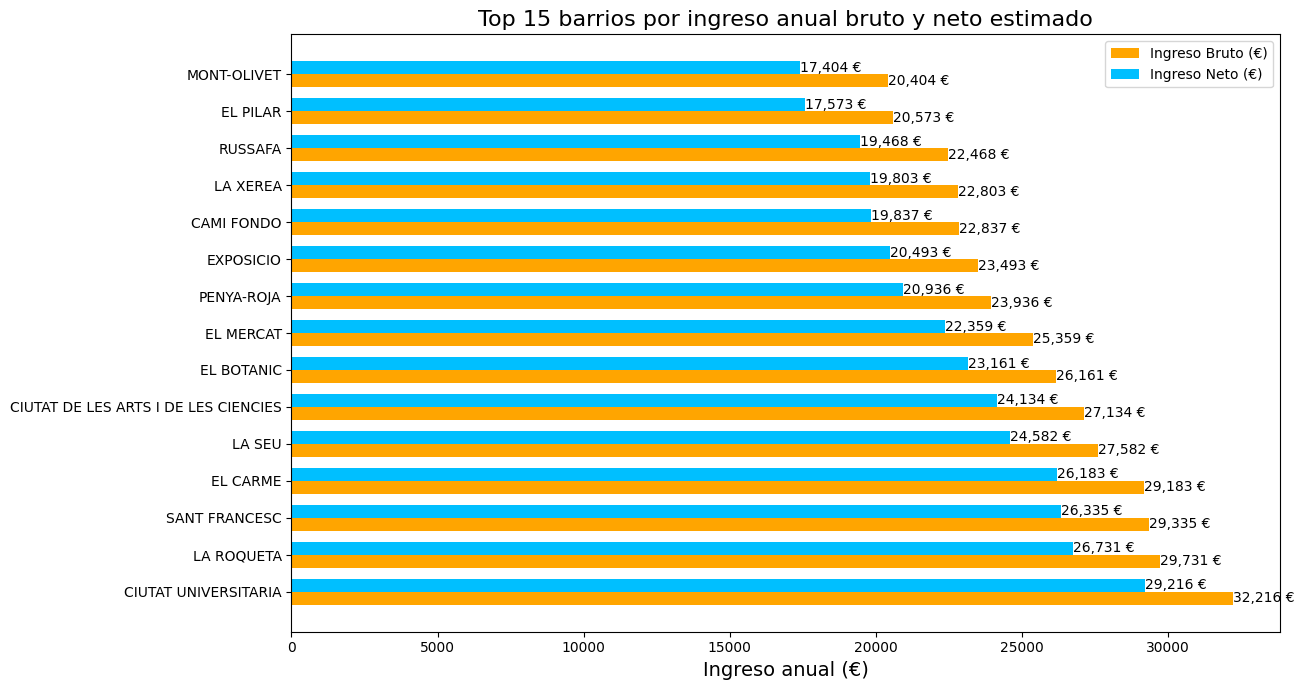

In [37]:
# Seleccionar los 15 barrios con mayor ingreso anual
top_barrios = zona_rent.sort_values(by='ingreso_anual', ascending=False).head(15).copy()

barrios = top_barrios['neighbourhood']
ingreso_bruto = top_barrios['ingreso_anual']

# Calcular ingreso neto estimado (ingreso anual - gastos anuales)
gastos_anuales = 3000
ingreso_neto = top_barrios['ingreso_anual'] - gastos_anuales

x = np.arange(len(barrios))
width = 0.35

plt.figure(figsize=(13, 7))
bars_bruto = plt.barh(x - width/2, ingreso_bruto, height=width, color='orange', label='Ingreso Bruto (€)')
bars_neto = plt.barh(x + width/2, ingreso_neto, height=width, color='deepskyblue', label='Ingreso Neto (€)')
plt.yticks(x, barrios)
plt.xlabel("Ingreso anual (€)", fontsize=14)
plt.title("Top 15 barrios por ingreso anual bruto y neto estimado", fontsize=16)
plt.legend()
plt.tight_layout()

# Añadir etiquetas de datos
for bar in bars_bruto:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{bar.get_width():,.0f} €', va='center', ha='left', fontsize=10)
for bar in bars_neto:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{bar.get_width():,.0f} €', va='center', ha='left', fontsize=10)

plt.show()

El gráfico compara el ingreso anual bruto y neto estimado de los 15 barrios más rentables de Valencia para alquiler turístico. Se observa que los barrios líderes, como Ciutat Universitaria, La Roqueta y Sant Francesc, destacan por generar los mayores ingresos anuales, tanto antes como después de descontar los gastos fijos. La diferencia entre ingreso bruto y neto es relativamente constante, reflejando el impacto de los gastos operativos en la rentabilidad final. Estos resultados sugieren que invertir en los barrios con mayor ingreso anual puede ser una estrategia efectiva para maximizar los beneficios, siempre considerando los costes asociados y la demanda real en cada zona.

                           neighbourhood  n_amenities
34                                FAVARA    45.400000
22                      EL FORN D'ALCEDO    40.000000
32                             EXPOSICIO    38.000000
55                          LES TENDETES    37.083333
25                             EL PALMAR    35.000000
63                              NATZARET    34.694444
15  CIUTAT DE LES ARTS I DE LES CIENCIES    34.463415
28                      EL PLA DEL REMEI    32.266667
9                    CABANYAL-CANYAMELAR    30.828571
10                          CAMI DE VERA    30.333333
0                                  AIORA    30.223776
69                               RUSSAFA    30.131250
65                               PATRAIX    30.098039
23                               EL GRAU    30.000000
71                           SANT ANTONI    29.590909


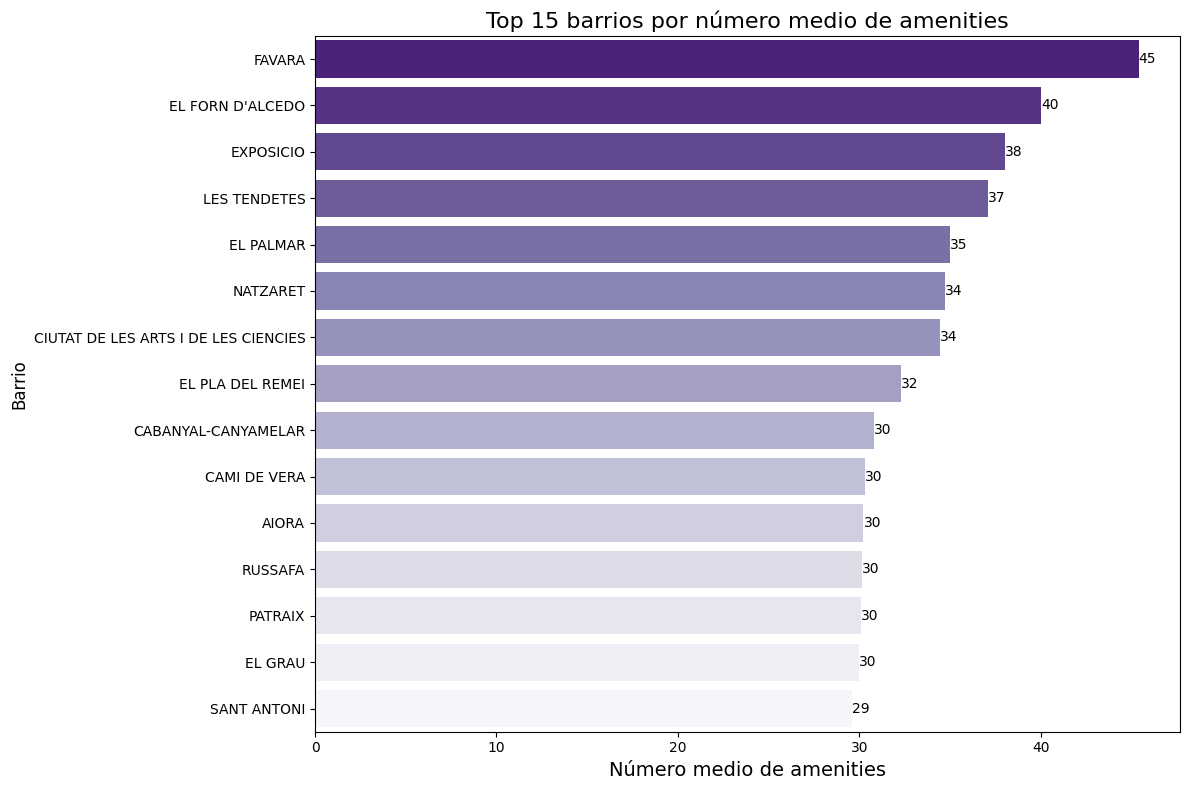

In [38]:
# barrio con mas amenities
barrio_amenities = df.groupby('neighbourhood')['amenities'].apply(lambda x: x.str.count(',').mean()).reset_index()
barrio_amenities = barrio_amenities.rename(columns={'amenities': 'n_amenities'})
barrio_amenities = barrio_amenities.sort_values(by='n_amenities', ascending=False)
print(barrio_amenities.head(15))
plt.figure(figsize=(12, 8))
ax = sns.barplot(
    y=barrio_amenities['neighbourhood'].head(15),
    x=barrio_amenities['n_amenities'].head(15),
    palette='Purples_r'
)  
plt.title("Top 15 barrios por número medio de amenities", fontsize=16)
plt.xlabel("Número medio de amenities", fontsize=14)
plt.ylabel("Barrio", fontsize=12)
plt.tight_layout()
for container in ax.containers:
    ax.bar_label(container, fmt='%d')
plt.show()

El gráfico muestra los 15 barrios de Valencia con mayor número medio de amenities por alojamiento. Se observa que los barrios líderes en amenities suelen ofrecer una experiencia más completa y atractiva para los huéspedes, lo que puede traducirse en mejores valoraciones y mayor demanda. Invertir en zonas con alto número de amenities puede ser una estrategia efectiva para diferenciarse en un mercado competitivo y aumentar la rentabilidad de los alojamientos turísticos.

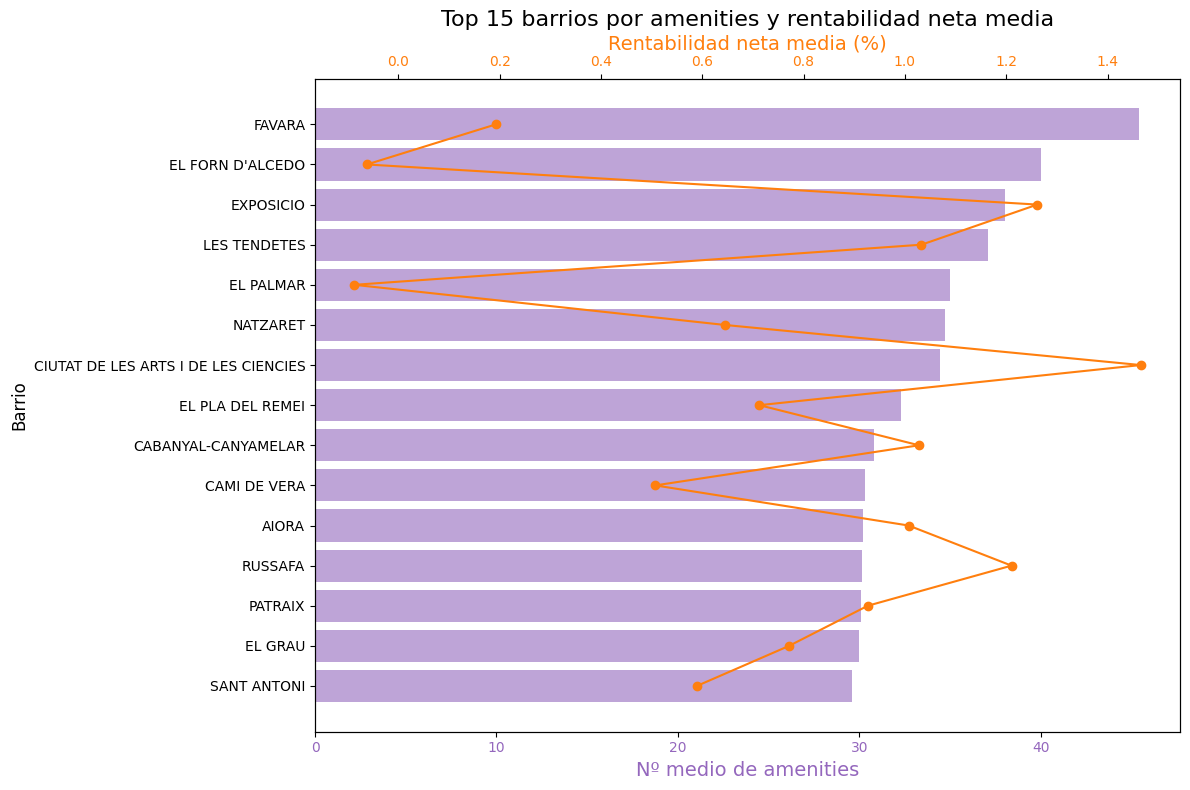

In [39]:
# Comparar barrios por número medio de amenities y rentabilidad neta media
barrio_amenities_rentabilidad = barrio_amenities.merge(barrio_rentabilidad_neta, on='neighbourhood', how='left')
barrio_amenities_rentabilidad = barrio_amenities_rentabilidad.sort_values(by='n_amenities', ascending=False).head(15)

fig, ax1 = plt.subplots(figsize=(12, 8))

# Gráfico de barras para amenities
color = 'tab:purple'
ax1.barh(
    barrio_amenities_rentabilidad['neighbourhood'],
    barrio_amenities_rentabilidad['n_amenities'],
    color=color,
    alpha=0.6,
    label='Nº medio de amenities'
)
ax1.set_xlabel('Nº medio de amenities', fontsize=14, color=color)
ax1.set_ylabel('Barrio', fontsize=12)
ax1.tick_params(axis='x', labelcolor=color)
ax1.invert_yaxis()

# Eje secundario para rentabilidad neta
ax2 = ax1.twiny()
color2 = 'tab:orange'
ax2.plot(
    barrio_amenities_rentabilidad['Net ROI (%)'],
    barrio_amenities_rentabilidad['neighbourhood'],
    'o-', color=color2, label='Rentabilidad neta media (%)'
)
ax2.set_xlabel('Rentabilidad neta media (%)', fontsize=14, color=color2)
ax2.tick_params(axis='x', labelcolor=color2)

plt.title("Top 15 barrios por amenities y rentabilidad neta media", fontsize=16)
fig.tight_layout()
plt.show()

El gráfico compara los 15 barrios de Valencia con mayor número medio de amenities por alojamiento y su rentabilidad neta media. Se observa que los barrios con más amenities suelen ofrecer también una rentabilidad neta competitiva, lo que sugiere que invertir en zonas donde los alojamientos están mejor equipados puede traducirse en mayores retornos. La combinación de un alto nivel de amenities y buena rentabilidad neta convierte a estos barrios en opciones atractivas para inversores que buscan diferenciarse y maximizar el retorno en el mercado de alquiler turístico.

                           neighbourhood  Net ROI (%)  n_anuncios
0                   CIUTAT UNIVERSITARIA     1.753122           7
1                             LA ROQUETA     1.615875          66
2                          SANT FRANCESC     1.605823          82
3                               EL CARME     1.603688         107
4   CIUTAT DE LES ARTS I DE LES CIENCIES     1.465459          41
5                             EL BOTANIC     1.431873          52
6                                 LA SEU     1.417724          90
7                             PENYA-ROJA     1.366078          33
8                              EL MERCAT     1.297536         118
9                             CAMI FONDO     1.275566          16
10                             EXPOSICIO     1.261368           6
11                               RUSSAFA     1.210524         160
12                           MASSARROJOS     1.208464           2
13                              LA XEREA     1.099498          46
14        

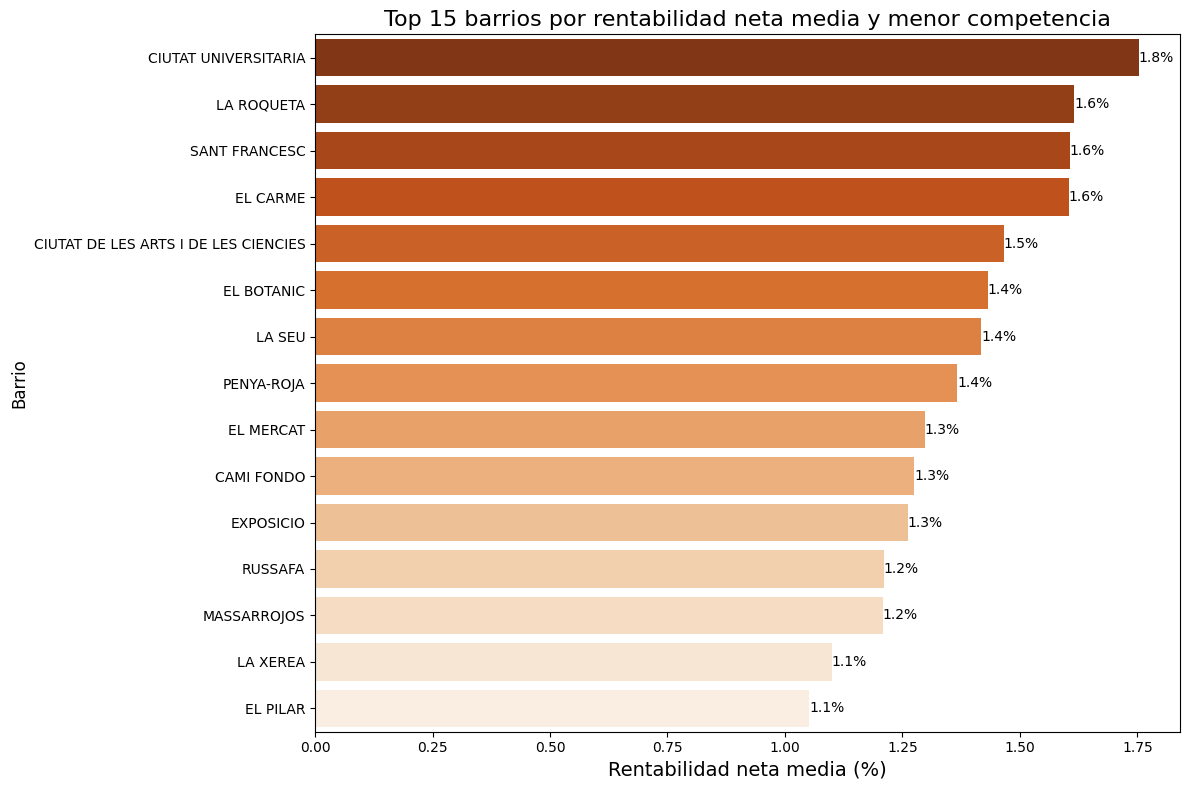

In [40]:
# barrio con mayor rentabilidad neta y menor competencia
barrio_neto_competencia = barrio_rentabilidad_neta.merge(competencia_por_barrio, on='neighbourhood', how='left')
barrio_neto_competencia = barrio_neto_competencia.sort_values(by='Net ROI (%)', ascending=False)
print(barrio_neto_competencia.head(15))
plt.figure(figsize=(12, 8))
ax = sns.barplot(
    y=barrio_neto_competencia['neighbourhood'].head(15),
    x=barrio_neto_competencia['Net ROI (%)'].head(15),
    palette='Oranges_r'
)   
plt.title("Top 15 barrios por rentabilidad neta media y menor competencia", fontsize=16)
plt.xlabel("Rentabilidad neta media (%)", fontsize=14)
plt.ylabel("Barrio", fontsize=12)
plt.tight_layout()
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%')
plt.show()

El gráfico muestra los 15 barrios de Valencia con mayor rentabilidad neta media y menor competencia (número de anuncios). Se observa que los barrios líderes, como Ciutat Universitaria, La Roqueta, Sant Francesc y El Carme, combinan altos retornos netos con un bajo nivel de competencia, lo que los convierte en opciones especialmente atractivas para inversores que buscan maximizar la rentabilidad y minimizar el riesgo de saturación del mercado. Elegir zonas con alta rentabilidad neta y pocos anuncios puede facilitar la captación de huéspedes y mejorar la sostenibilidad de la inversión a largo plazo.

           neighbourhood  Net ROI (%)  n_anuncios
0   CIUTAT UNIVERSITARIA     1.753122           7
10             EXPOSICIO     1.261368           6
12           MASSARROJOS     1.208464           2
19           SANT ISIDRE     0.986375           4
22              SAFRANAR     0.946577           9
28         VARA DE QUART     0.893093           7
32              FAITANAR     0.843240           2
33  CASTELLAR-L'OLIVERAL     0.840669           2
42            EL CALVARI     0.759495           6
46                PINEDO     0.676453           1
47         EL PERELLONET     0.675831           8
57               BORBOTO     0.578260           1
58            JAUME ROIG     0.560283           5
63          CAMI DE VERA     0.507330           3
66              SANT PAU     0.444235           6


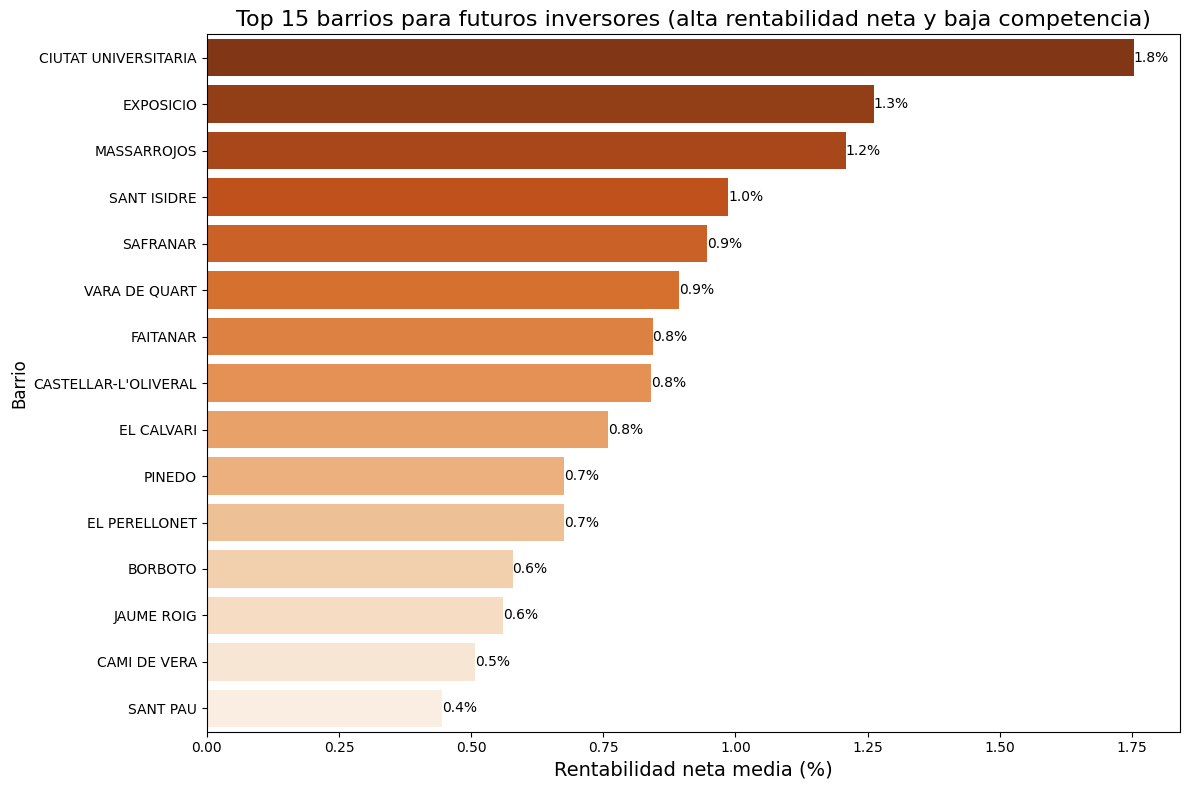

In [41]:
# para futuros inversores, barrios con alta rentabilidad neta y baja competencia
barrio_futuro_inversion = barrio_neto_competencia[barrio_neto_competencia['n_anuncios'] < 10].sort_values(by='Net ROI (%)', ascending=False)
print(barrio_futuro_inversion.head(15))
plt.figure(figsize=(12, 8))
ax = sns.barplot(
    y=barrio_futuro_inversion['neighbourhood'].head(15),
    x=barrio_futuro_inversion['Net ROI (%)'].head(15),
    palette='Oranges_r'
)
plt.title("Top 15 barrios para futuros inversores (alta rentabilidad neta y baja competencia)", fontsize=16)
plt.xlabel("Rentabilidad neta media (%)", fontsize=14)
plt.ylabel("Barrio", fontsize=12)
plt.tight_layout()
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%')
plt.show()

La visualización destaca los 15 barrios de Valencia más atractivos para futuros inversores, seleccionados por combinar una alta rentabilidad neta media y un bajo nivel de competencia (menos de 10 anuncios activos). Estos barrios ofrecen oportunidades interesantes para invertir en alquiler turístico, ya que la baja competencia facilita la captación de huéspedes y la maximización de la rentabilidad. Elegir zonas con alta rentabilidad neta y pocos anuncios puede reducir el riesgo de saturación del mercado y favorecer una inversión más sostenible y rentable a largo plazo.

                           neighbourhood   precio
25                             EL MERCAT  39330.0
74                         SANT FRANCESC  39000.0
71                               RUSSAFA  39000.0
54                              LA XEREA  38210.0
51                                LA SEU  38000.0
29                      EL PLA DEL REMEI  37770.0
22                              EL CARME  37000.0
20                            EL BOTANIC  34000.0
33                             EXPOSICIO  32000.0
76                          SANT LLORENS  32000.0
13                              CAMPANAR  31340.0
2                            ARRANCAPINS  31000.0
16  CIUTAT DE LES ARTS I DE LES CIENCIES  30000.0
5                             BENIMACLET  28600.0
50                            LA ROQUETA  28000.0


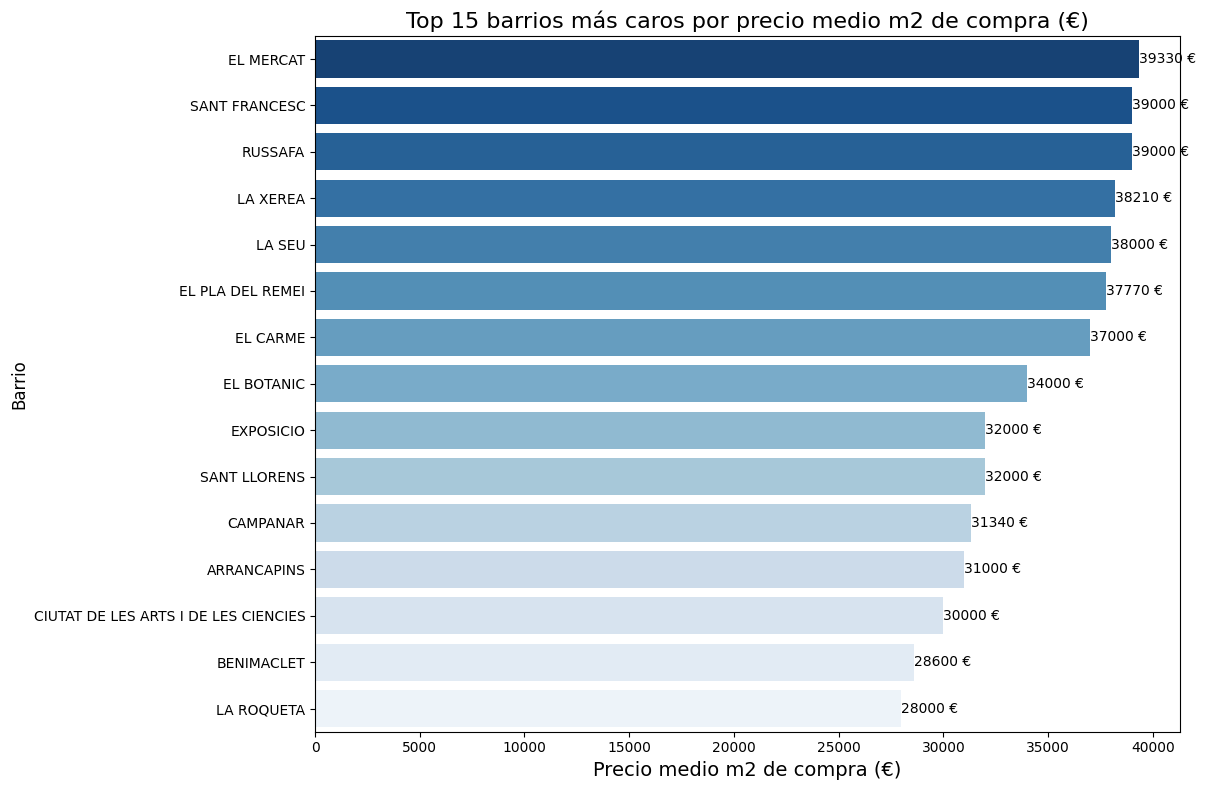

In [42]:
#barrio mas caros
barrio_caros = df_inmobiliario.groupby('neighbourhood')['precio'].mean().reset_index()
barrio_caros = barrio_caros.sort_values(by='precio', ascending=False)
print(barrio_caros.head(15))
plt.figure(figsize=(12, 8))
ax = sns.barplot(
    y=barrio_caros['neighbourhood'].head(15),
    x=barrio_caros['precio'].head(15),
    palette='Blues_r'
)
plt.title("Top 15 barrios más caros por precio medio m2 de compra (€)", fontsize=16)
plt.xlabel("Precio medio m2 de compra (€)", fontsize=14)
plt.ylabel("Barrio", fontsize=12)
plt.tight_layout()
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f €')
plt.show()

El gráfico muestra los 15 barrios más caros de Valencia según el precio medio por metro cuadrado de compra. Se observa que zonas como Russafa, Sant Francesc y Arrancapins lideran el ranking, reflejando una alta demanda y prestigio en el mercado inmobiliario local. Estos barrios suelen estar asociados a una mayor oferta de servicios, ubicación céntrica y atractivo tanto para residentes como para inversores. Sin embargo, los altos precios pueden implicar una menor rentabilidad relativa para nuevas inversiones, por lo que es fundamental analizar el equilibrio entre coste de adquisición y potencial de retorno antes de invertir en estas áreas.

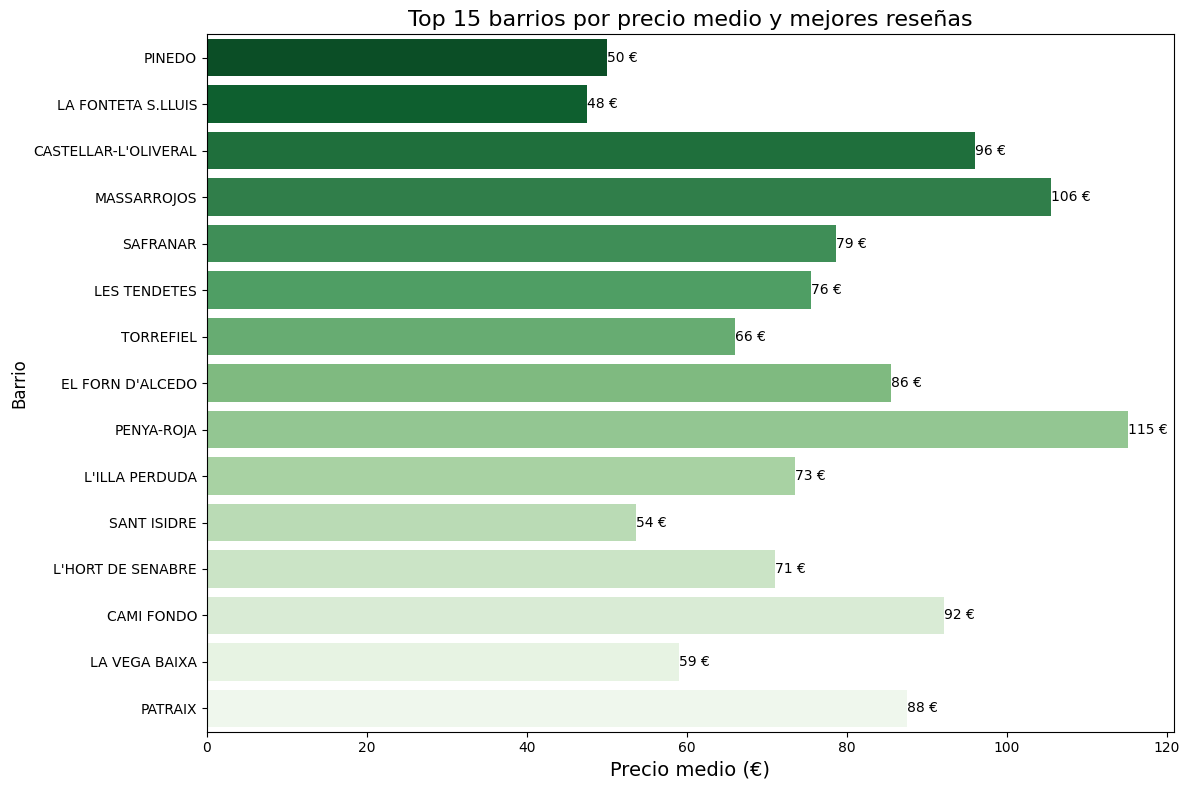

In [43]:
# precio con mejores reseñas
barrio_precios_resenas = df.groupby('neighbourhood').agg({
    'price': 'mean',
    'review_scores_value': 'mean'
}).reset_index()
barrio_precios_resenas = barrio_precios_resenas.sort_values(by=['review_scores_value', 'price'], ascending=[False, False]).head(15)
plt.figure(figsize=(12, 8))
ax = sns.barplot(
    y=barrio_precios_resenas['neighbourhood'],
    x=barrio_precios_resenas['price'],
    palette='Greens_r'
)
plt.title("Top 15 barrios por precio medio y mejores reseñas", fontsize=16)
plt.xlabel("Precio medio (€)", fontsize=14)
plt.ylabel("Barrio", fontsize=12)
plt.tight_layout()
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f €')
plt.show()

El gráfico muestra los 15 barrios de Valencia con el precio medio más alto y mejores valoraciones de los huéspedes. Se observa que las zonas con precios de alquiler más elevados suelen coincidir con aquellas que obtienen mejores reseñas, lo que indica una relación positiva entre calidad percibida y valor de mercado. Invertir en estos barrios puede resultar atractivo para propietarios que buscan maximizar ingresos y mantener altos niveles de satisfacción de los huéspedes, aunque también implica una mayor exigencia en la calidad del alojamiento y los servicios ofrecidos.

          neighbourhood  number_of_reviews
9   CABANYAL-CANYAMELAR               7749
69              RUSSAFA               5063
24            EL MERCAT               3721
21             EL CARME               3351
0                 AIORA               3115
31             EN CORTS               2136
72        SANT FRANCESC               2131
60          MONT-OLIVET               2110
51               LA SEU               1931
2           ARRANCAPINS               1854
23              EL GRAU               1654
46        LA MALVA-ROSA               1639
61             MORVEDRE               1507
54             LA XEREA               1373
65              PATRAIX               1283


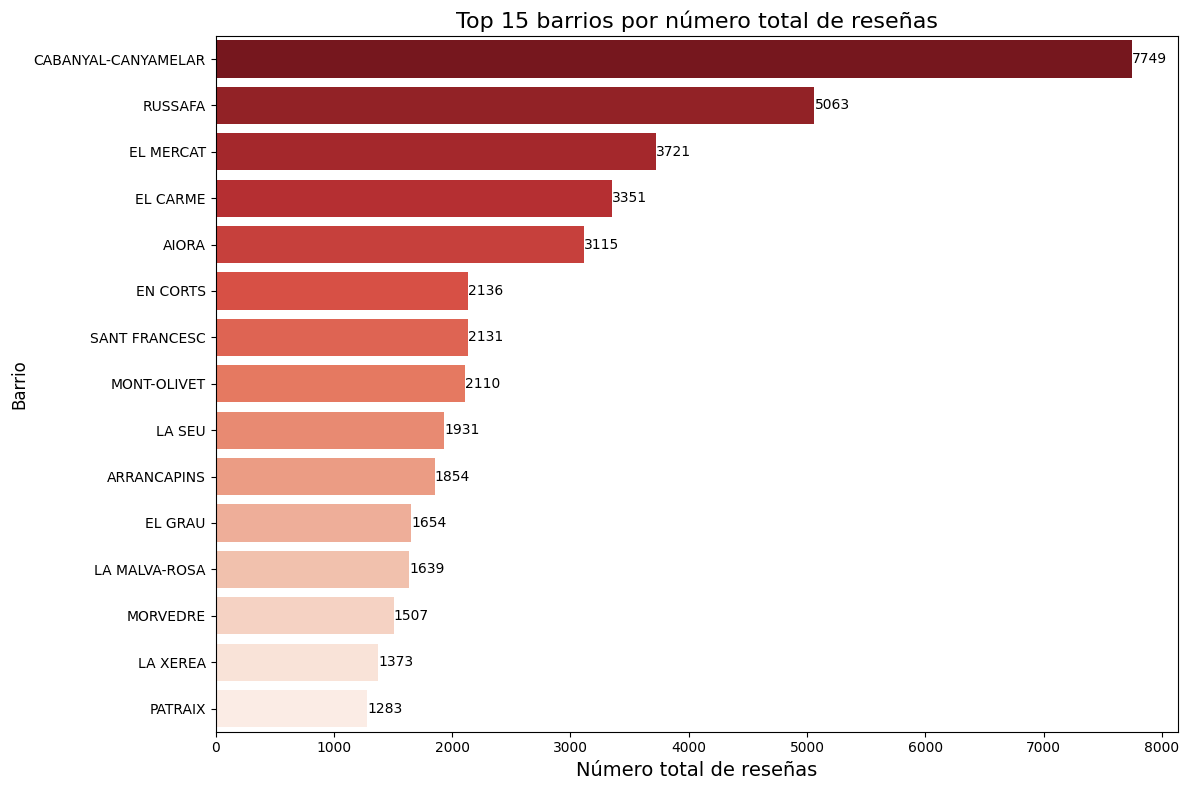

In [44]:
#barrio con mas reseñas
barrio_mas_resenas = df.groupby('neighbourhood')['number_of_reviews'].sum().reset_index()
barrio_mas_resenas = barrio_mas_resenas.sort_values(by='number_of_reviews', ascending=False)
print(barrio_mas_resenas.head(15))
plt.figure(figsize=(12, 8))
ax = sns.barplot(
    y=barrio_mas_resenas['neighbourhood'].head(15),
    x=barrio_mas_resenas['number_of_reviews'].head(15),
    palette='Reds_r'
)
plt.title("Top 15 barrios por número total de reseñas", fontsize=16)
plt.xlabel("Número total de reseñas", fontsize=14)
plt.ylabel("Barrio", fontsize=12)
plt.tight_layout()
for container in ax.containers:
    ax.bar_label(container, fmt='%d')
plt.show()

El gráfico muestra los 15 barrios de Valencia con mayor número total de reseñas en alojamientos turísticos. Se observa que zonas como Cabanyal-Canyamelar, Russafa y El Mercat lideran en volumen de reseñas, lo que indica una alta demanda y actividad turística sostenida. Estos barrios destacan por su popularidad entre los huéspedes y su dinamismo en el mercado de alquiler turístico. Para inversores y anfitriones, una mayor cantidad de reseñas suele asociarse a mayor visibilidad, confianza y potencial de ingresos, aunque también puede implicar una competencia más intensa. En resumen, los barrios con más reseñas representan oportunidades atractivas para captar huéspedes, siempre considerando el equilibrio entre demanda y competencia.

        neighbourhood  reviews_per_month
22   EL FORN D'ALCEDO           3.595000
63           NATZARET           2.170278
82      VARA DE QUART           1.930000
75     SANT MARCEL.LI           1.894615
76           SANT PAU           1.875000
37  L'HORT DE SENABRE           1.696316
60        MONT-OLIVET           1.688830
55       LES TENDETES           1.619167
8             BORBOTO           1.580000
17       CIUTAT JARDI           1.563333
13           CAMPANAR           1.515714
32          EXPOSICIO           1.458333
44        LA GRAN VIA           1.454118
61           MORVEDRE           1.450154
12          CAMI REAL           1.443636


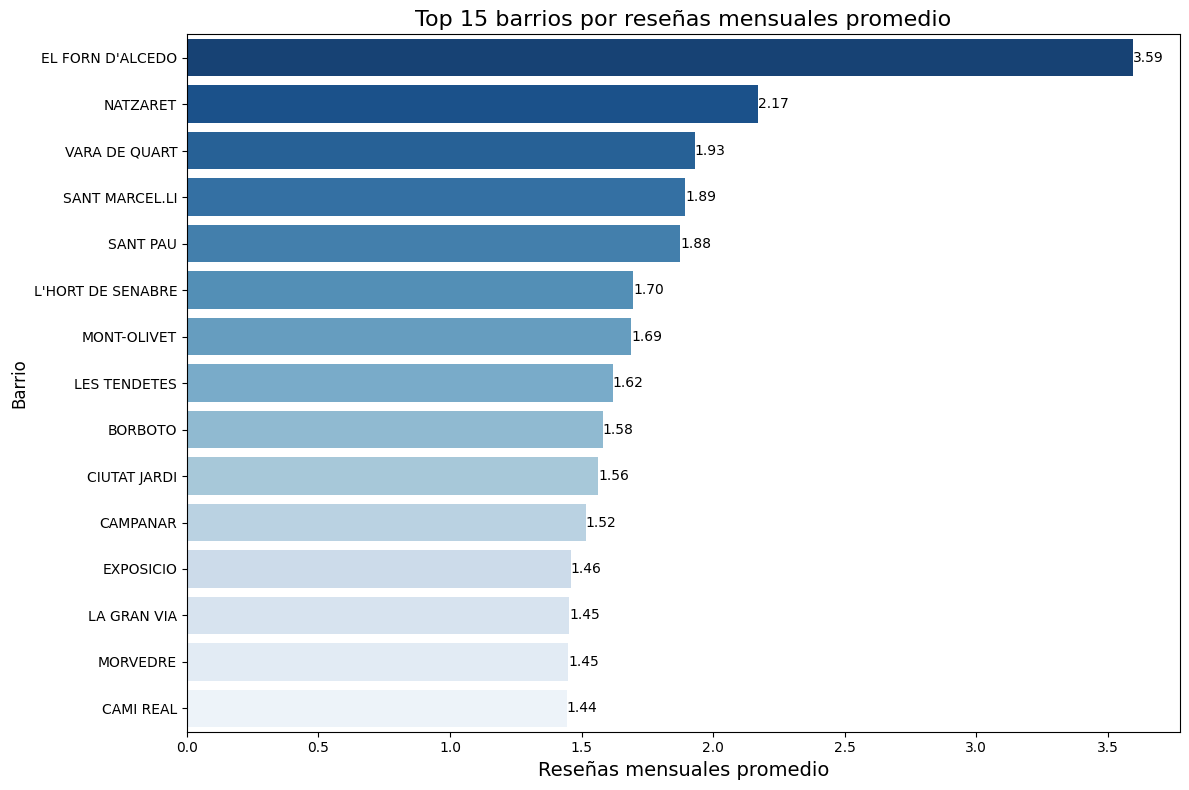

In [45]:
# mayor reviwes_per_month
barrio_reviews_per_month = df.groupby('neighbourhood')['reviews_per_month'].mean().reset_index()
barrio_reviews_per_month = barrio_reviews_per_month.sort_values(by='reviews_per_month', ascending=False)
print(barrio_reviews_per_month.head(15))
plt.figure(figsize=(12, 8))
ax = sns.barplot(
    y=barrio_reviews_per_month['neighbourhood'].head(15),
    x=barrio_reviews_per_month['reviews_per_month'].head(15),
    palette='Blues_r'
)
plt.title("Top 15 barrios por reseñas mensuales promedio", fontsize=16)
plt.xlabel("Reseñas mensuales promedio", fontsize=14)
plt.ylabel("Barrio", fontsize=12)
plt.tight_layout()
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f')
plt.show()

El gráfico muestra los 15 barrios de Valencia con mayor promedio de reseñas mensuales por alojamiento. Se observa que zonas como Cabanyal-Canyamelar, Russafa, El Mercat y El Carme destacan por su alta actividad turística, reflejada en un mayor flujo constante de huéspedes y opiniones. Estos barrios combinan una fuerte demanda con una rotación elevada, lo que los convierte en áreas especialmente atractivas para inversores y anfitriones que buscan maximizar la ocupación y la visibilidad de sus alojamientos. En resumen, invertir en barrios con altos valores de reseñas mensuales puede ser una estrategia efectiva para asegurar ingresos recurrentes y una presencia destacada en el mercado de alquiler turístico.

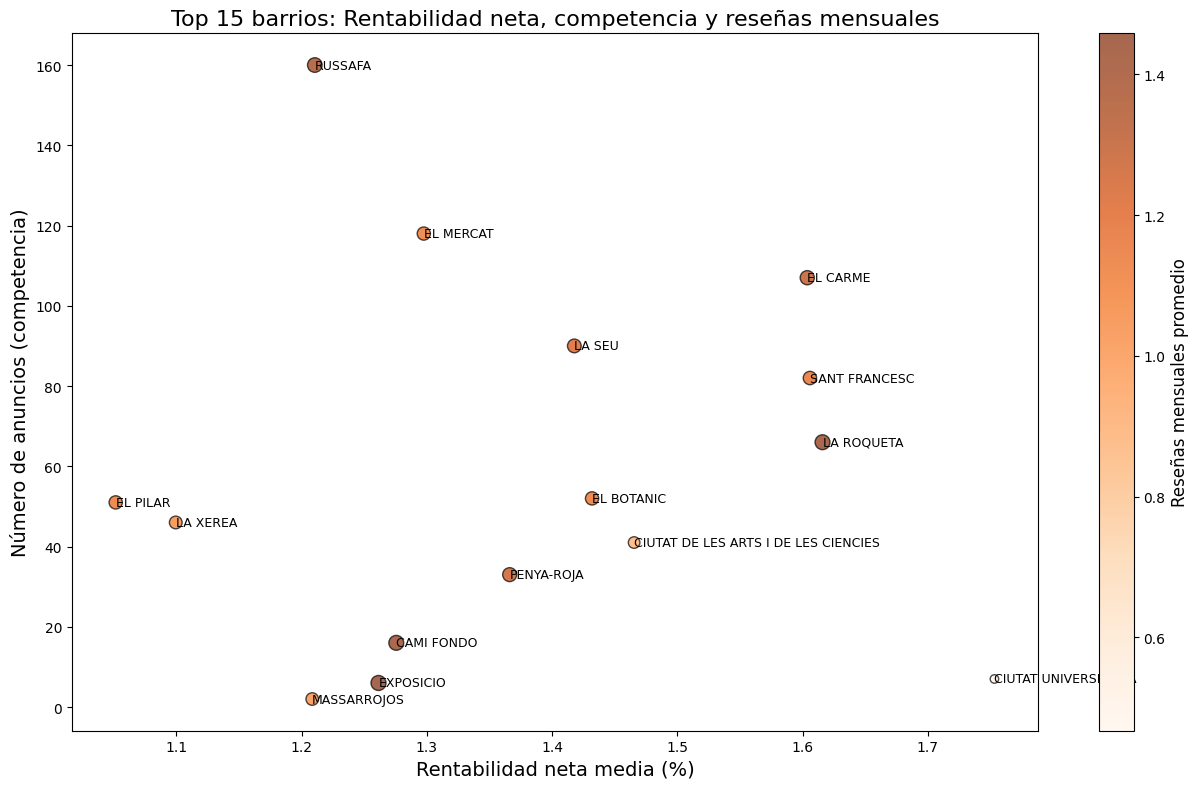

In [46]:
# Añadir reviews_per_month y Net ROI (%) a zona_stats y mostrar solo el top 15 por Net ROI (%)
comparacion = zona_stats.merge(
    barrio_reviews_per_month, on='neighbourhood', how='left'
).merge(
    barrio_rentabilidad_neta, on='neighbourhood', how='left'
)

comparacion = comparacion[['neighbourhood', 'n_anuncios', 'reviews_per_month', 'Net ROI (%)']].dropna()
comparacion = comparacion.sort_values(by='Net ROI (%)', ascending=False).head(15)

plt.figure(figsize=(13, 8))
scatter = plt.scatter(
    comparacion['Net ROI (%)'],
    comparacion['n_anuncios'],
    s=comparacion['reviews_per_month'] * 80,
    c=comparacion['reviews_per_month'],
    cmap='Oranges',
    alpha=0.7,
    edgecolor='k'
)
for i, row in comparacion.iterrows():
    plt.text(row['Net ROI (%)'], row['n_anuncios'], row['neighbourhood'], fontsize=9, va='center', ha='left')

plt.xlabel('Rentabilidad neta media (%)', fontsize=14)
plt.ylabel('Número de anuncios (competencia)', fontsize=14)
plt.title('Top 15 barrios: Rentabilidad neta, competencia y reseñas mensuales', fontsize=16)
cbar = plt.colorbar(scatter)
cbar.set_label('Reseñas mensuales promedio', fontsize=12)
plt.tight_layout()
plt.show()


El gráfico visualiza la relación entre la rentabilidad neta media (%), el número de anuncios (competencia) y las reseñas mensuales promedio en los 15 barrios más destacados de Valencia. Se observa que los barrios con mayor rentabilidad neta tienden a mantener un equilibrio entre alta demanda (reflejada en más reseñas mensuales) y un nivel de competencia moderado. Esto sugiere que invertir en zonas con buena rentabilidad y actividad constante de huéspedes puede ser una estrategia efectiva, siempre considerando el impacto de la competencia en la sostenibilidad de los retornos. Los barrios que combinan alta rentabilidad neta, muchas reseñas mensuales y competencia controlada se posicionan como las mejores oportunidades para inversores en alquiler turístico.

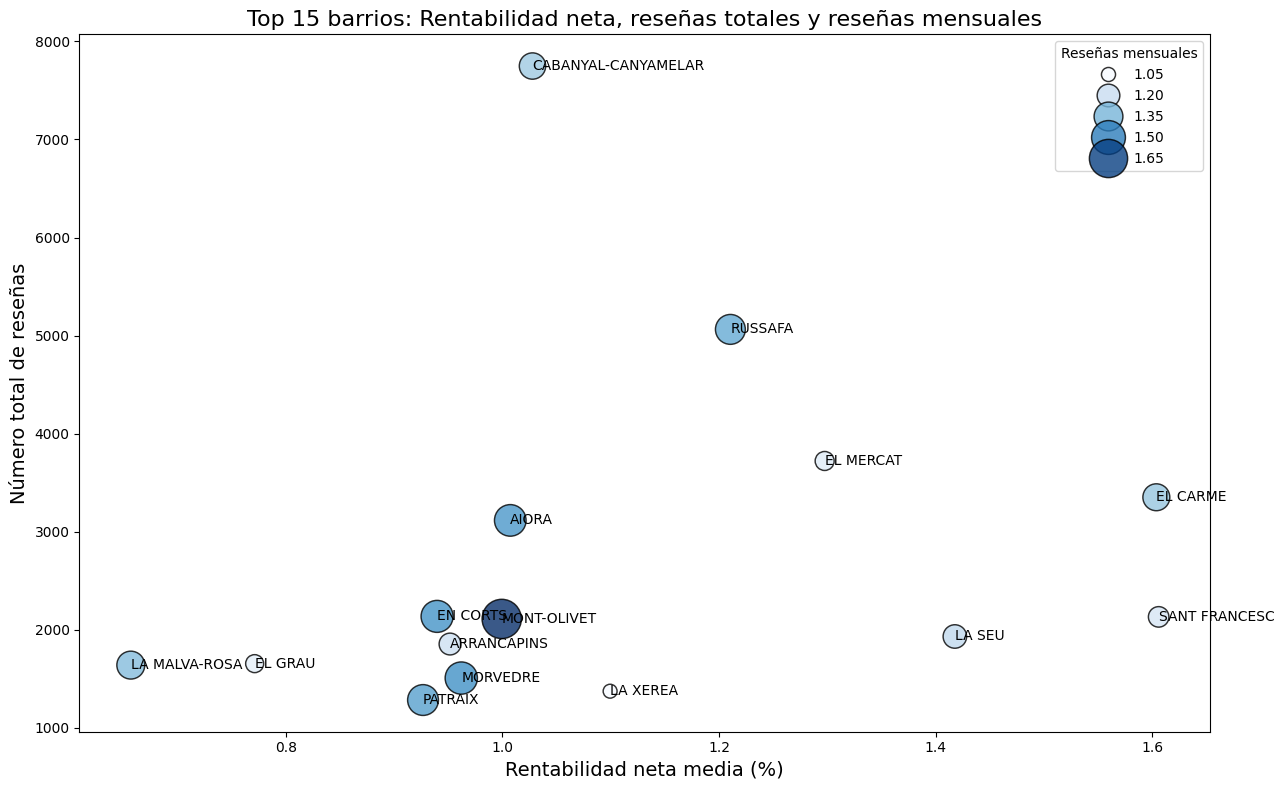

In [47]:
# Crear el DataFrame barrio_plot con las métricas necesarias
barrio_plot = barrio_rentabilidad_neta.merge(
    barrio_mas_resenas[['neighbourhood', 'number_of_reviews']],
    on='neighbourhood',
    how='left'
).merge(
    barrio_reviews_per_month[['neighbourhood', 'reviews_per_month']],
    on='neighbourhood',
    how='left'
)

# Seleccionar los 15 barrios con más reseñas
top_barrio_plot = barrio_plot.sort_values(by='number_of_reviews', ascending=False).head(15)

plt.figure(figsize=(13, 8))
scatter = sns.scatterplot(
    data=top_barrio_plot,
    x='Net ROI (%)',
    y='number_of_reviews',
    size='reviews_per_month',
    hue='reviews_per_month',
    palette='Blues',
    sizes=(100, 800),
    legend='brief',
    alpha=0.8,
    edgecolor='k'
)

# Etiquetas para cada punto
for i, row in top_barrio_plot.iterrows():
    plt.text(row['Net ROI (%)'], row['number_of_reviews'], row['neighbourhood'],
             fontsize=10, va='center', ha='left')

plt.xlabel('Rentabilidad neta media (%)', fontsize=14)
plt.ylabel('Número total de reseñas', fontsize=14)
plt.title('Top 15 barrios: Rentabilidad neta, reseñas totales y reseñas mensuales', fontsize=16)
plt.legend(title='Reseñas mensuales', loc='best')
plt.tight_layout()
plt.show()

El gráfico muestra los 15 barrios de Valencia con mayor número total de reseñas, rentabilidad neta media (%) y reseñas mensuales promedio. Se observa que los barrios con más reseñas suelen coincidir con aquellos que presentan una rentabilidad neta competitiva y una alta actividad mensual de huéspedes. Esto indica que invertir en zonas con alta demanda y buena reputación puede traducirse en mayores retornos y ocupación sostenida. Además, la combinación de un elevado volumen de reseñas y una rentabilidad neta sólida convierte a estos barrios en opciones especialmente atractivas para inversores que buscan maximizar visibilidad, ingresos y sostenibilidad en el mercado de alquiler turístico.

        neighbourhood  reviews_per_month  Net ROI (%)  relacion_resenas
14          CAMI REAL           1.443636     0.064769         22.289035
29          BENIFERRI           1.293333     0.088663         14.587014
3      SANT MARCEL.LI           1.894615     0.181931         10.413904
35       TRES FORQUES           1.237778     0.224261          5.519366
70             FAVARA           0.887000     0.192929          4.597543
31       LA FONTSANTA           1.280000     0.286414          4.469060
4            SANT PAU           1.875000     0.444235          4.220740
1            NATZARET           2.170278     0.644248          3.368700
5   L'HORT DE SENABRE           1.696316     0.548027          3.095313
75    LA CREU COBERTA           0.832000     0.284441          2.925036
71     CIUTAT FALLERA           0.882222     0.307142          2.872362
8             BORBOTO           1.580000     0.578260          2.732333
20      LA VEGA BAIXA           1.426923     0.527473          2

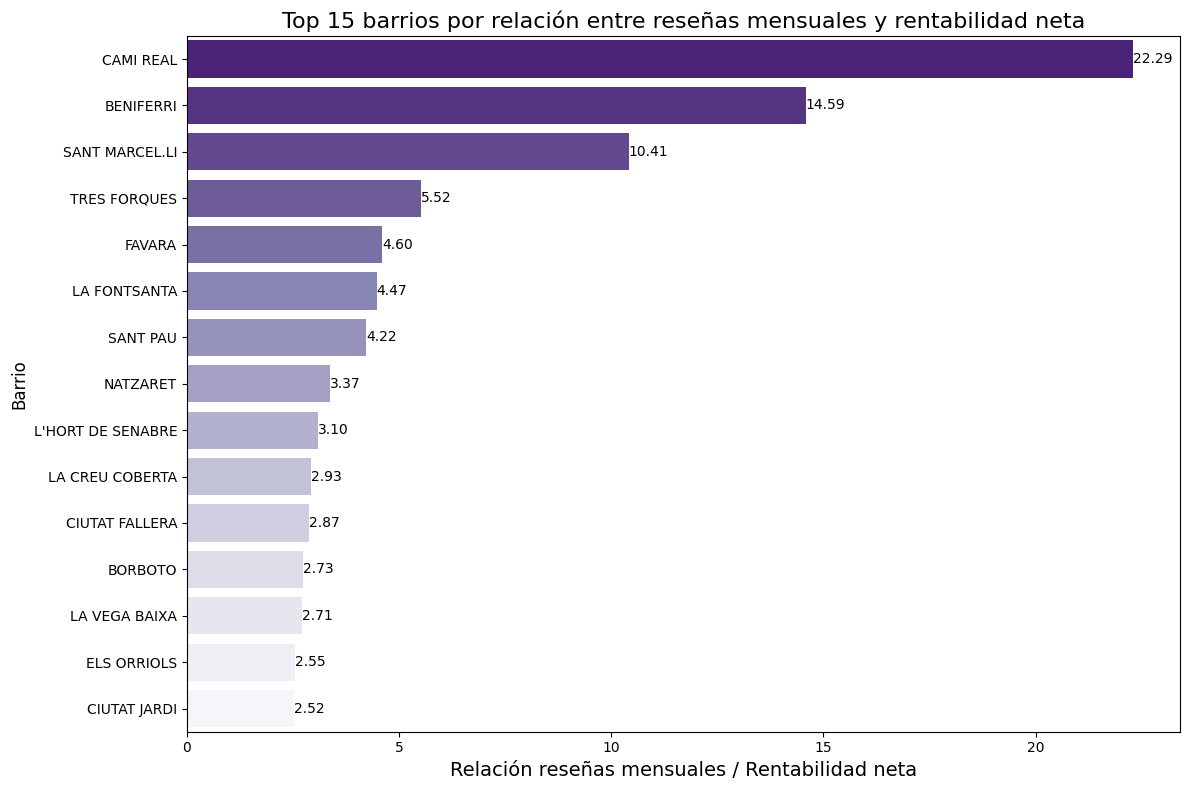

In [48]:
#calcular barrio con mejor relación entre reseñas mensuales y rentabilidad neta
barrio_relacion_resenas = barrio_reviews_per_month.merge(barrio_rentabilidad_neta, on='neighbourhood', how='left')
barrio_relacion_resenas['relacion_resenas'] = barrio_relacion_resenas['reviews_per_month'] / barrio_relacion_resenas['Net ROI (%)']
barrio_relacion_resenas = barrio_relacion_resenas.sort_values(by='relacion_resenas', ascending=False)
print(barrio_relacion_resenas.head(15))
plt.figure(figsize=(12, 8))
ax = sns.barplot(
    y=barrio_relacion_resenas['neighbourhood'].head(15),
    x=barrio_relacion_resenas['relacion_resenas'].head(15),
    palette='Purples_r'
)   
plt.title("Top 15 barrios por relación entre reseñas mensuales y rentabilidad neta", fontsize=16)
plt.xlabel("Relación reseñas mensuales / Rentabilidad neta", fontsize=14)
plt.ylabel("Barrio", fontsize=12)
plt.tight_layout()
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f')
plt.show()

Conclusiones sobre la relación entre reseñas mensuales y rentabilidad neta
El análisis de la relación entre las reseñas mensuales promedio y la rentabilidad neta media por barrio permite identificar zonas donde la alta actividad de huéspedes (reflejada en más reseñas mensuales) se traduce en una rentabilidad eficiente para los inversores. Los barrios que encabezan el ranking combinan una demanda turística activa con una buena capacidad para convertir esa demanda en retornos económicos.

Principales observaciones:

Los barrios con mayor relación entre reseñas mensuales y rentabilidad neta suelen ser zonas con alta rotación de huéspedes y buena percepción de valor.
Una relación elevada indica que, por cada punto de rentabilidad neta, se obtiene un flujo constante de opiniones, lo que puede favorecer la visibilidad y reputación de los alojamientos.
Estos barrios pueden ser especialmente atractivos para inversores que buscan maximizar tanto la ocupación como la rentabilidad, aprovechando la dinámica positiva entre demanda y retorno.
Sin embargo, es importante considerar también el nivel de competencia y la sostenibilidad de la demanda para asegurar que los altos niveles de reseñas se mantengan en el tiempo.
En resumen, priorizar barrios con una buena relación entre reseñas mensuales y rentabilidad neta puede ser una estrategia efectiva para optimizar la inversión en alquiler turístico, siempre evaluando el contexto competitivo y la estabilidad de la demanda.

In [49]:
# Calcular el número medio de habitaciones y baños por barrio
barrio_habitaciones_banos = df.groupby('neighbourhood').agg({
    'bedrooms': 'mean',
    'bathrooms': 'mean'
}).reset_index()

# Mostrar los 15 barrios con mayor número medio de habitaciones
barrio_habitaciones_banos = barrio_habitaciones_banos.sort_values(by='bedrooms', ascending=False).head(15)
print(barrio_habitaciones_banos)


           neighbourhood  bedrooms  bathrooms
0                  AIORA       1.0   1.005848
1                 ALBORS       1.0   1.019479
2            ARRANCAPINS       1.0   1.008727
3              BENICALAP       1.0   1.012391
4              BENIFERRI       1.0   1.000000
5             BENIMACLET       1.0   1.009142
6              BENIMAMET       1.0   1.010121
7                 BETERO       1.0   1.007123
8                BORBOTO       1.0   1.000000
9    CABANYAL-CANYAMELAR       1.0   1.007043
10          CAMI DE VERA       1.0   1.000000
11            CAMI FONDO       1.0   1.012019
12             CAMI REAL       1.0   1.021258
13              CAMPANAR       1.0   1.015545
14  CASTELLAR-L'OLIVERAL       1.0   1.000000


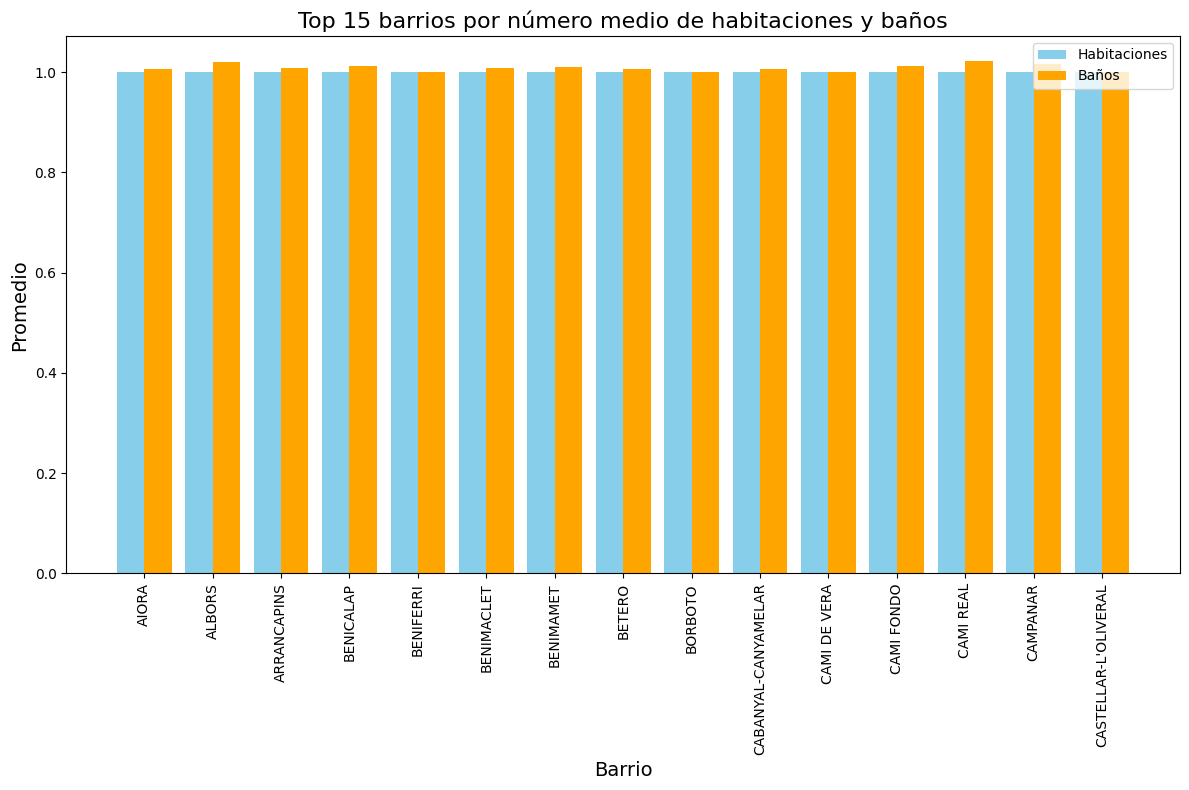

In [50]:


plt.figure(figsize=(12, 8))
bar_width = 0.4
x = range(len(barrio_habitaciones_banos))

plt.bar(x, barrio_habitaciones_banos['bedrooms'], width=bar_width, label='Habitaciones', color='skyblue')
plt.bar([i + bar_width for i in x], barrio_habitaciones_banos['bathrooms'], width=bar_width, label='Baños', color='orange')

plt.xlabel('Barrio', fontsize=14)
plt.ylabel('Promedio', fontsize=14)
plt.title('Top 15 barrios por número medio de habitaciones y baños', fontsize=16)
plt.xticks([i + bar_width/2 for i in x], barrio_habitaciones_banos['neighbourhood'], rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

***Conclusiones sobre el número medio de habitaciones y baños por barrio***

El análisis del número medio de habitaciones y baños por barrio en Valencia revela que la mayoría de los barrios presentan alojamientos con una media de 1 habitación y 1 baño, lo que sugiere una oferta predominante de apartamentos pequeños o estudios, ideales para parejas o viajeros individuales. Sin embargo, algunos barrios destacan por ofrecer viviendas ligeramente más espaciosas, lo que puede atraer a grupos más grandes o familias.

La relación entre el número medio de habitaciones y el volumen de reseñas indica que los barrios con viviendas más grandes tienden a recibir un mayor número de opiniones, posiblemente debido a una mayor capacidad de alojamiento y rotación de huéspedes. No obstante, la correlación no es perfecta, ya que factores como la ubicación, el precio y la calidad del alojamiento también influyen en la demanda y popularidad de los anuncios.

En resumen, invertir en barrios con viviendas más espaciosas puede ofrecer ventajas competitivas en el mercado de alquiler turístico, especialmente si se combinan con una buena ubicación y servicios de calidad. Sin embargo, es fundamental considerar el perfil de la demanda local y las preferencias de los viajeros para maximizar la ocupación y la rentabilidad.


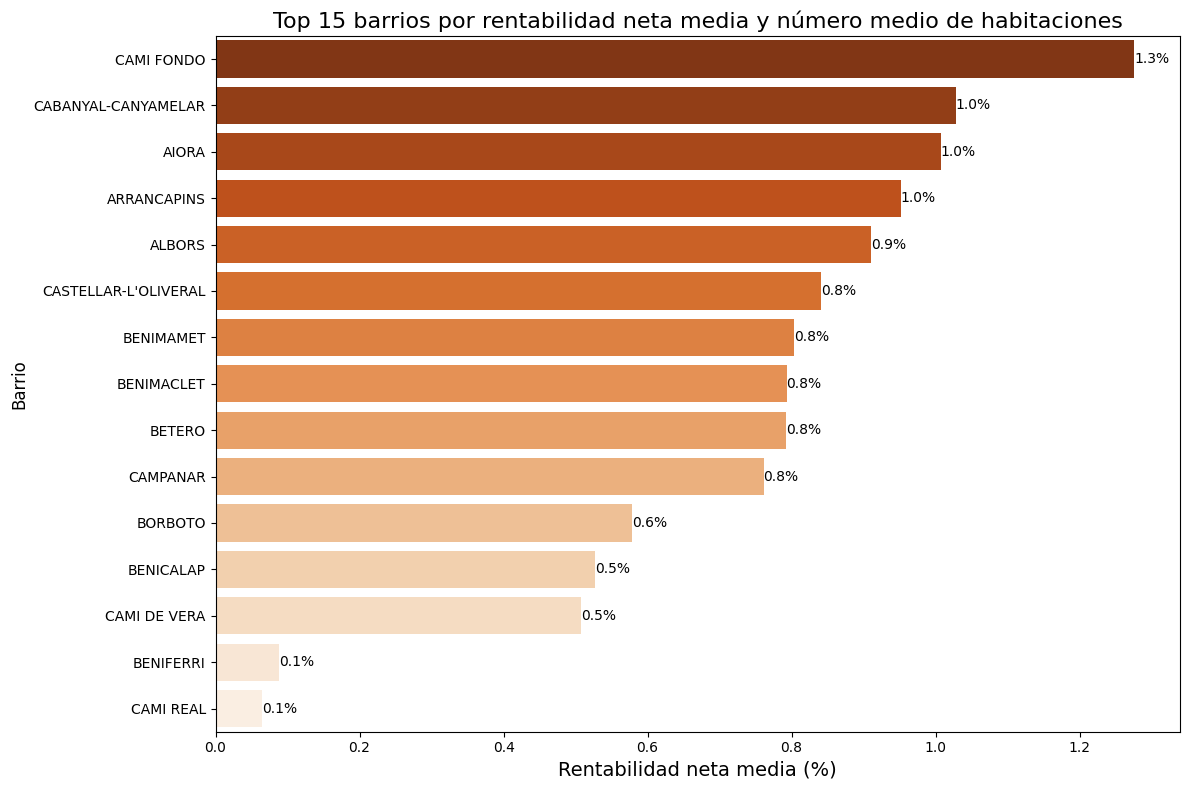

In [51]:
#comparar numeros de habitaciones con rentabilidad neta
barrio_habitaciones_rentabilidad = barrio_habitaciones_banos.merge(barrio_rentabilidad_neta, on='neighbourhood', how='left')
barrio_habitaciones_rentabilidad = barrio_habitaciones_rentabilidad.sort_values(by='Net ROI (%)', ascending=False).head(15)
plt.figure(figsize=(12, 8))
ax = sns.barplot(
    y=barrio_habitaciones_rentabilidad['neighbourhood'],
    x=barrio_habitaciones_rentabilidad['Net ROI (%)'],
    palette='Oranges_r'
)
plt.title("Top 15 barrios por rentabilidad neta media y número medio de habitaciones", fontsize=16)
plt.xlabel("Rentabilidad neta media (%)", fontsize=14)
plt.ylabel("Barrio", fontsize=12)
plt.tight_layout()
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%')
plt.show()


***Conclusiones sobre la relación entre número medio de habitaciones y rentabilidad neta por barrio***

El gráfico muestra los 15 barrios de Valencia con mayor rentabilidad neta media y su número medio de habitaciones. Se observa que los barrios con mayor rentabilidad neta no siempre coinciden con los que tienen viviendas más grandes; en muchos casos, la rentabilidad está asociada a una combinación de buena ubicación, alta demanda y una oferta ajustada al perfil turístico (apartamentos de 1-2 habitaciones). 

En resumen, invertir en barrios con alta rentabilidad neta es más relevante que centrarse únicamente en el tamaño medio de las viviendas. Sin embargo, ofrecer alojamientos con más habitaciones puede ser una ventaja competitiva en zonas donde la demanda de grupos o familias es significativa. La clave está en adaptar la oferta al perfil de los huéspedes y a la dinámica de cada barrio para maximizar la rentabilidad.


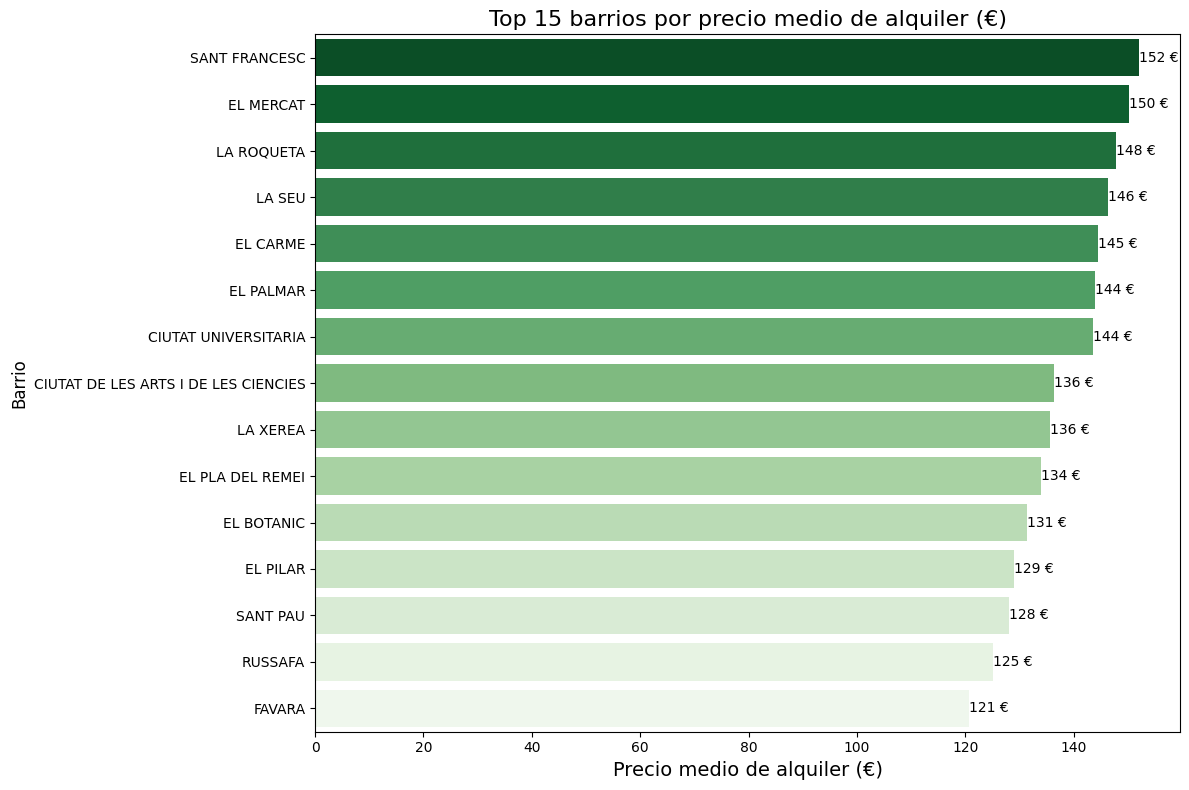

In [52]:
#comparar barrios con price
barrio_price = df.groupby('neighbourhood')['price'].mean().reset_index()
barrio_price = barrio_price.sort_values(by='price', ascending=False).head(15
)
plt.figure(figsize=(12, 8))
ax = sns.barplot(
    y=barrio_price['neighbourhood'],
    x=barrio_price['price'],
    palette='Greens_r'
)
plt.title("Top 15 barrios por precio medio de alquiler (€)", fontsize=16)
plt.xlabel("Precio medio de alquiler (€)", fontsize=14)
plt.ylabel("Barrio", fontsize=12)
plt.tight_layout()
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f €')
plt.show()

El gráfico muestra los 15 barrios de Valencia con el precio medio de alquiler más alto. Se observa que los barrios líderes en precio suelen coincidir con zonas céntricas o de alta demanda turística, como Ciutat Universitaria, La Roqueta, Sant Francesc y El Carme. Estos barrios destacan por su atractivo para inquilinos dispuestos a pagar más por ubicación, servicios o prestigio. Sin embargo, un precio medio elevado no siempre implica mayor rentabilidad, ya que también puede estar asociado a mayores costes de adquisición o competencia. Para inversores, es clave analizar el equilibrio entre precio de alquiler, demanda, competencia y rentabilidad neta antes de tomar decisiones de inversión en estas zonas.

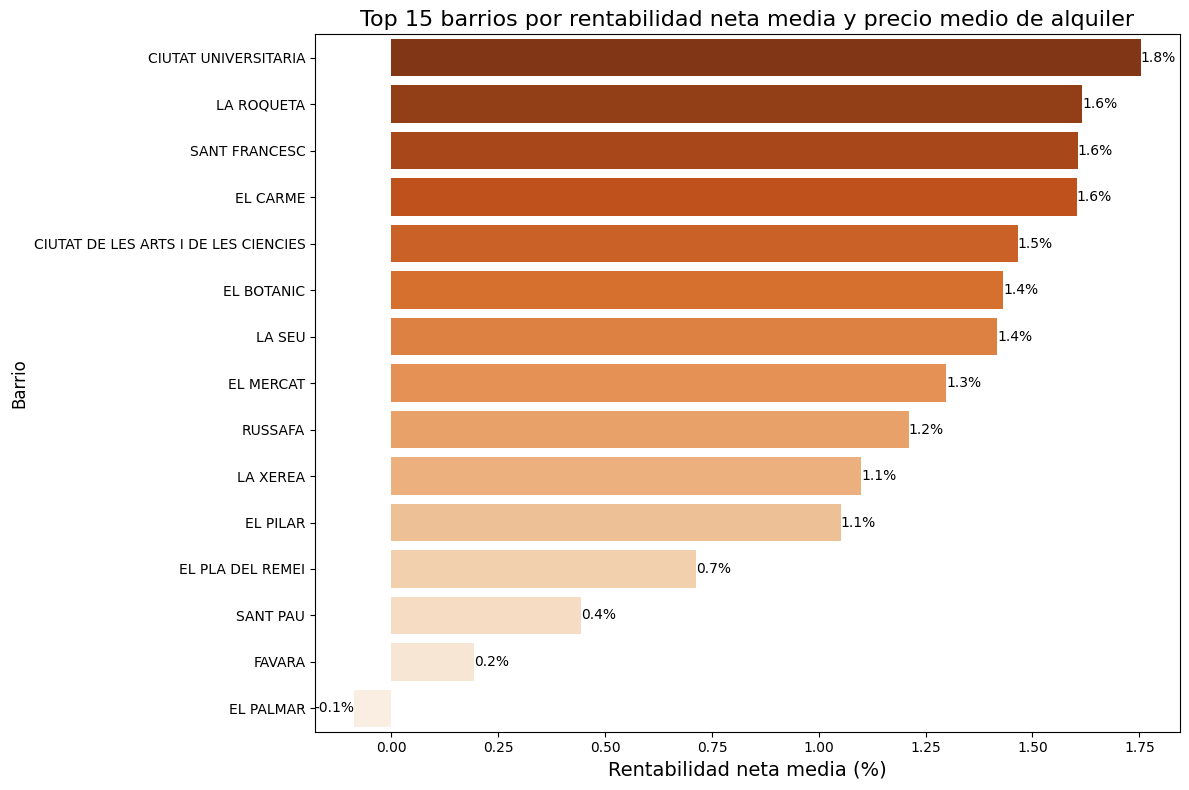

In [53]:
#comparar precio noche con rentabilidad neta
barrio_price_rentabilidad = barrio_price.merge(barrio_rentabilidad_neta, on='neighbourhood', how='left')
barrio_price_rentabilidad = barrio_price_rentabilidad.sort_values(by='Net ROI (%)', ascending=False).head(15)
plt.figure(figsize=(12, 8))
ax = sns.barplot(
    y=barrio_price_rentabilidad['neighbourhood'],
    x=barrio_price_rentabilidad['Net ROI (%)'],
    palette='Oranges_r'
)
plt.title("Top 15 barrios por rentabilidad neta media y precio medio de alquiler", fontsize=16)
plt.xlabel("Rentabilidad neta media (%)", fontsize=14)
plt.ylabel("Barrio", fontsize=12)
plt.tight_layout()
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%')
plt.show()
# Comparar barrios por precio medio de alquiler y número de anuncios
barrio_price_anuncios = barrio_price.merge(
    competencia_por_barrio[['neighbourhood', 'n_anuncios']],
    on='neighbourhood',
    how='left'
)

Conclusiones sobre la relación entre precio medio de alquiler, rentabilidad neta y competencia por barrio
El análisis de los barrios de Valencia muestra que los barrios con mayor rentabilidad neta media no siempre son los que presentan el precio medio de alquiler más alto. En muchos casos, la rentabilidad neta está asociada a un equilibrio entre precios competitivos, alta demanda y un nivel de competencia moderado.

Rentabilidad neta: Los barrios líderes en rentabilidad neta, como Ciutat Universitaria, La Roqueta y Sant Francesc, logran combinar ingresos anuales elevados con precios de compra relativamente competitivos, lo que maximiza el retorno de la inversión.
Precio medio de alquiler: Un precio de alquiler alto puede indicar zonas de alta demanda, pero también puede estar asociado a mayores costes de adquisición y competencia, lo que puede reducir la rentabilidad final.
Competencia: Los barrios con menor número de anuncios suelen ofrecer mejores oportunidades para captar huéspedes y mantener altos niveles de ocupación, favoreciendo la sostenibilidad de la inversión.
Estrategia de inversión: Para futuros inversores, es clave priorizar barrios con alta rentabilidad neta y competencia controlada, en lugar de centrarse únicamente en el precio de alquiler. Analizar el equilibrio entre estos factores permite identificar las zonas más atractivas y sostenibles para invertir en alquiler turístico en Valencia.
En resumen, la rentabilidad óptima se alcanza en barrios donde se combinan precios de alquiler competitivos, demanda sostenida y un nivel de competencia que permita diferenciar la oferta y captar una mayor cuota de mercado.

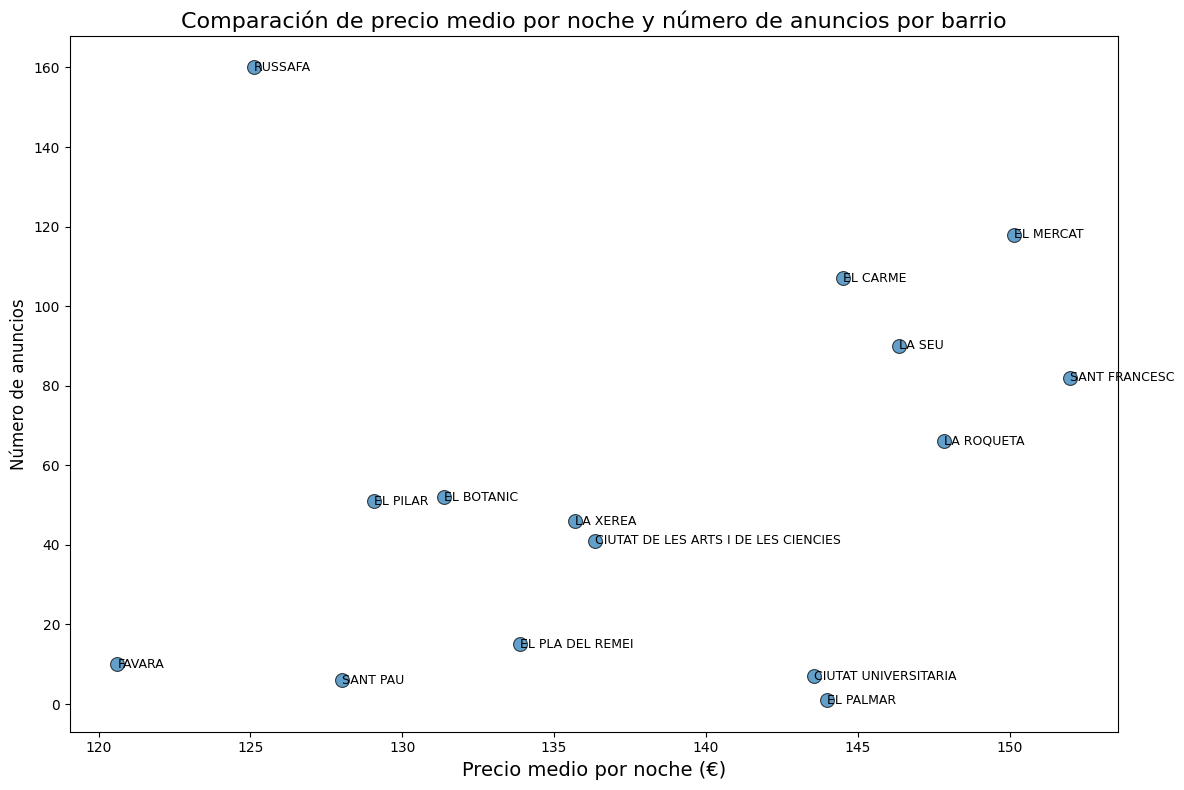

In [54]:
plt.figure(figsize=(12, 8))
ax = sns.scatterplot(
    data=barrio_price_anuncios,
    x='price',
    y='n_anuncios',
    s=100,
    alpha=0.7,
    edgecolor='k'
)
plt.title("Comparación de precio medio por noche y número de anuncios por barrio", fontsize=16)
plt.xlabel("Precio medio por noche (€)", fontsize=14)
plt.ylabel("Número de anuncios", fontsize=12)

# Etiquetas de barrio para cada punto
for i, row in barrio_price_anuncios.iterrows():
    plt.text(row['price'], row['n_anuncios'], row['neighbourhood'], fontsize=9, va='center', ha='left')

plt.tight_layout()
plt.show()

**Conclusiones mejoradas sobre la relación entre precio medio de alquiler y competencia por barrio**

El análisis del gráfico revela que los barrios de Valencia con precios medios de alquiler turístico más altos suelen concentrar también un mayor número de anuncios, lo que refleja una fuerte competencia en las zonas más demandadas. Esta dinámica puede deberse a la alta popularidad de estos barrios entre turistas y propietarios, lo que incrementa tanto la demanda como la oferta.

Sin embargo, el gráfico también permite identificar barrios con precios elevados pero menor competencia relativa. Estas zonas pueden representar oportunidades especialmente atractivas para inversores, ya que permiten maximizar los ingresos potenciales sin enfrentarse a una saturación excesiva del mercado. Invertir en barrios con alta demanda y menor número de competidores puede facilitar la captación de huéspedes y mejorar la ocupación a lo largo del año.

Por otro lado, los barrios con precios medios más bajos y menor competencia pueden ser interesantes para inversores con menor presupuesto o para quienes buscan diversificar su cartera, aunque es importante analizar si la demanda en estas zonas es suficiente para garantizar una rentabilidad sostenible.

En resumen, el equilibrio entre precio de alquiler y nivel de competencia es clave para identificar las zonas más atractivas y sostenibles para invertir en alquiler turístico en Valencia. Una estrategia informada debe considerar tanto el potencial de ingresos como la saturación del mercado, priorizando barrios donde la demanda sea sólida y la competencia permita diferenciar la oferta.

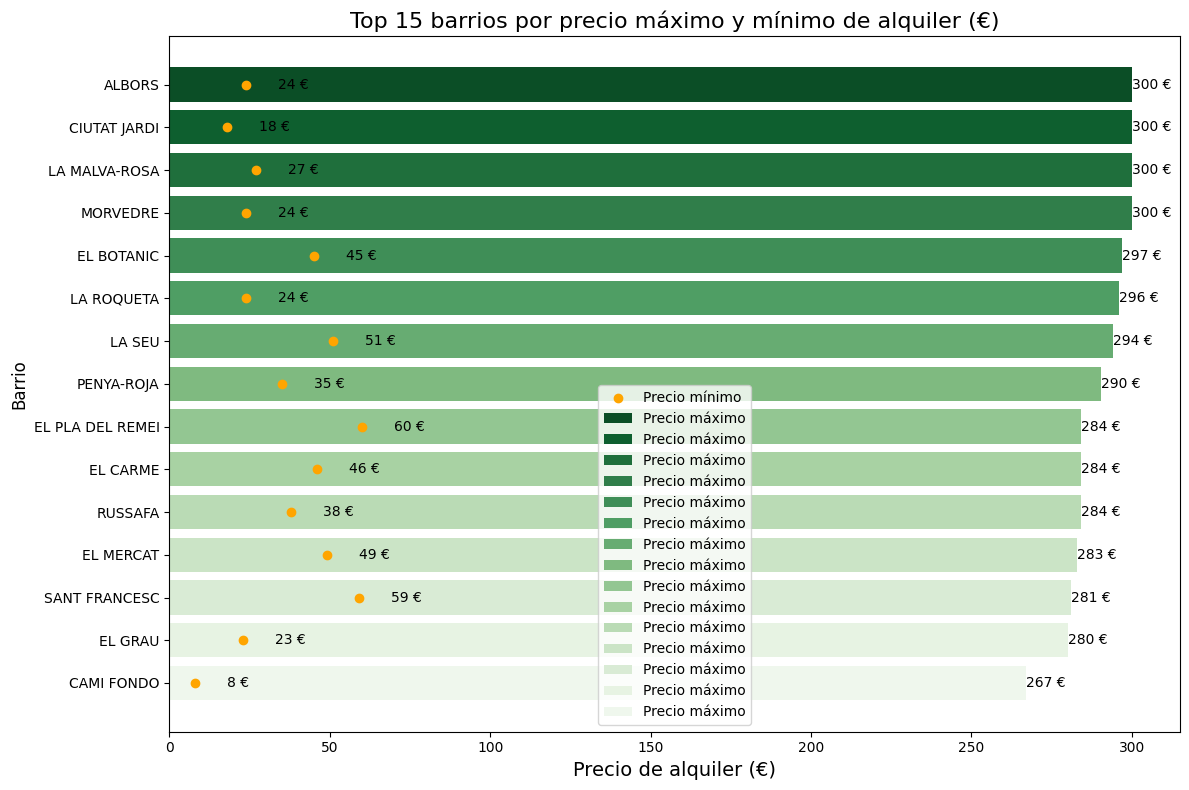

In [55]:
# Comparativa máximo y mínimo precio por barrio
barrio_price_min_max = df.groupby('neighbourhood')['price'].agg(['min', 'max']).reset_index()
barrio_price_min_max = barrio_price_min_max.sort_values(by='max', ascending=False).head(15)

plt.figure(figsize=(12, 8))
ax = sns.barplot(
    y=barrio_price_min_max['neighbourhood'],
    x=barrio_price_min_max['max'],
    palette='Greens_r',
    label='Precio máximo'
)
plt.scatter(
    barrio_price_min_max['min'],
    barrio_price_min_max['neighbourhood'],
    color='orange',
    label='Precio mínimo',
    zorder=10
)
plt.title("Top 15 barrios por precio máximo y mínimo de alquiler (€)", fontsize=16)
plt.xlabel("Precio de alquiler (€)", fontsize=14)
plt.ylabel("Barrio", fontsize=12)
plt.tight_layout()
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f €')

# Añadir etiquetas de precio mínimo en negro al final de la barra
for i, (y, x_min) in enumerate(zip(
    barrio_price_min_max['neighbourhood'],
    barrio_price_min_max['min'])):
    label_min = f'{x_min:.0f} €'
    ax.text(x_min + 10, i, label_min, va='center', ha='left', fontsize=10, color='black')

plt.legend()
plt.show()


Conclusiones sobre la comparativa de precios máximos y mínimos de alquiler por barrio

El gráfico permite visualizar la dispersión de precios de alquiler en los 15 barrios más caros de Valencia. Se observa que:

Existe una gran diferencia entre los precios máximos y mínimos dentro de cada barrio, lo que refleja una oferta muy heterogénea en cuanto a tipo de vivienda, tamaño, ubicación y nivel de equipamiento.
Los barrios con precios máximos más elevados suelen ser zonas céntricas o de alta demanda turística, donde la exclusividad y los servicios premium incrementan el valor de ciertos inmuebles.
La presencia de precios mínimos relativamente bajos en estos mismos barrios indica que aún es posible encontrar oportunidades de alquiler más asequibles, aunque probablemente asociadas a viviendas más pequeñas o con menos prestaciones.
Esta variabilidad de precios dentro de un mismo barrio puede ser aprovechada tanto por inversores que buscan rentas altas como por inquilinos con presupuestos más ajustados.
Para los inversores, es clave analizar no solo el precio medio, sino también el rango de precios disponible, ya que una mayor dispersión puede ofrecer más flexibilidad para adaptar la oferta a diferentes perfiles de demanda.
En resumen, la comparativa de precios máximos y mínimos por barrio evidencia la diversidad del mercado de alquiler en Valencia y la importancia de segmentar la oferta para maximizar la rentabilidad y la ocupación.


In [56]:
# cargar csv calendar_valencia

'''df_calendar_valencia = pd.read_csv('data/calendar_valencia.csv', sep=',')
df_calendar_valencia.head(2)'''


"df_calendar_valencia = pd.read_csv('data/calendar_valencia.csv', sep=',')\ndf_calendar_valencia.head(2)"

In [57]:
import plotly.express as px
'''
# Ya tienes df_calendar_valencia cargado en la celda 58, no es necesario volver a cargarlo

# Eliminar filas con NaN en 'maximum_nights', 'price' o 'minimum_nights'
df_calendar_plot = df_calendar_valencia.dropna(subset=['maximum_nights', 'price', 'minimum_nights'])

# Convertir 'date' a tipo datetime para mejor manejo en el eje x
df_calendar_plot['date'] = pd.to_datetime(df_calendar_plot['date'])

# Normalizar el tamaño de los puntos para mejor visualización
max_size = 40
min_size = 10
sizes = ((df_calendar_plot['maximum_nights'] - df_calendar_plot['maximum_nights'].min()) /
         (df_calendar_plot['maximum_nights'].max() - df_calendar_plot['maximum_nights'].min()) * (max_size - min_size) + min_size)

fig = px.scatter(
    df_calendar_plot,
    x='date',
    y='price',
    color='minimum_nights',
    size=sizes,
    hover_data=['listing_id', 'maximum_nights'],
    color_continuous_scale='Plasma',
    title='Precio por fecha, noches mínimas y máximas (interactivo)'
)
fig.update_traces(marker=dict(opacity=0.7, line=dict(width=0.5, color='DarkSlateGrey')))
fig.update_layout(
    xaxis_title='Fecha',
    yaxis_title='Precio (€)',
    legend_title='Noches mínimas',
    height=600,
    width=1100,
    plot_bgcolor='white'
)
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey')
fig.show()'''



"\n# Ya tienes df_calendar_valencia cargado en la celda 58, no es necesario volver a cargarlo\n\n# Eliminar filas con NaN en 'maximum_nights', 'price' o 'minimum_nights'\ndf_calendar_plot = df_calendar_valencia.dropna(subset=['maximum_nights', 'price', 'minimum_nights'])\n\n# Convertir 'date' a tipo datetime para mejor manejo en el eje x\ndf_calendar_plot['date'] = pd.to_datetime(df_calendar_plot['date'])\n\n# Normalizar el tamaño de los puntos para mejor visualización\nmax_size = 40\nmin_size = 10\nsizes = ((df_calendar_plot['maximum_nights'] - df_calendar_plot['maximum_nights'].min()) /\n         (df_calendar_plot['maximum_nights'].max() - df_calendar_plot['maximum_nights'].min()) * (max_size - min_size) + min_size)\n\nfig = px.scatter(\n    df_calendar_plot,\n    x='date',\n    y='price',\n    color='minimum_nights',\n    size=sizes,\n    hover_data=['listing_id', 'maximum_nights'],\n    color_continuous_scale='Plasma',\n    title='Precio por fecha, noches mínimas y máximas (interac

In [58]:
#comparativa calendar noches minimas y maximas
'''fig = px.scatter(
    df_calendar_valencia,
    x='date',
    y='minimum_nights',
    color='maximum_nights',
    hover_data=['listing_id'],
    color_continuous_scale='Viridis',
    title='Comparativa interactiva: Fecha, Noches mínimas y Noches máximas'
)   
fig.update_layout(
    xaxis_title='Fecha',
    yaxis_title='Noches mínimas',
    legend_title='Noches máximas',
    height=600,
    width=1100
)
fig.show()'''

"fig = px.scatter(\n    df_calendar_valencia,\n    x='date',\n    y='minimum_nights',\n    color='maximum_nights',\n    hover_data=['listing_id'],\n    color_continuous_scale='Viridis',\n    title='Comparativa interactiva: Fecha, Noches mínimas y Noches máximas'\n)   \nfig.update_layout(\n    xaxis_title='Fecha',\n    yaxis_title='Noches mínimas',\n    legend_title='Noches máximas',\n    height=600,\n    width=1100\n)\nfig.show()"

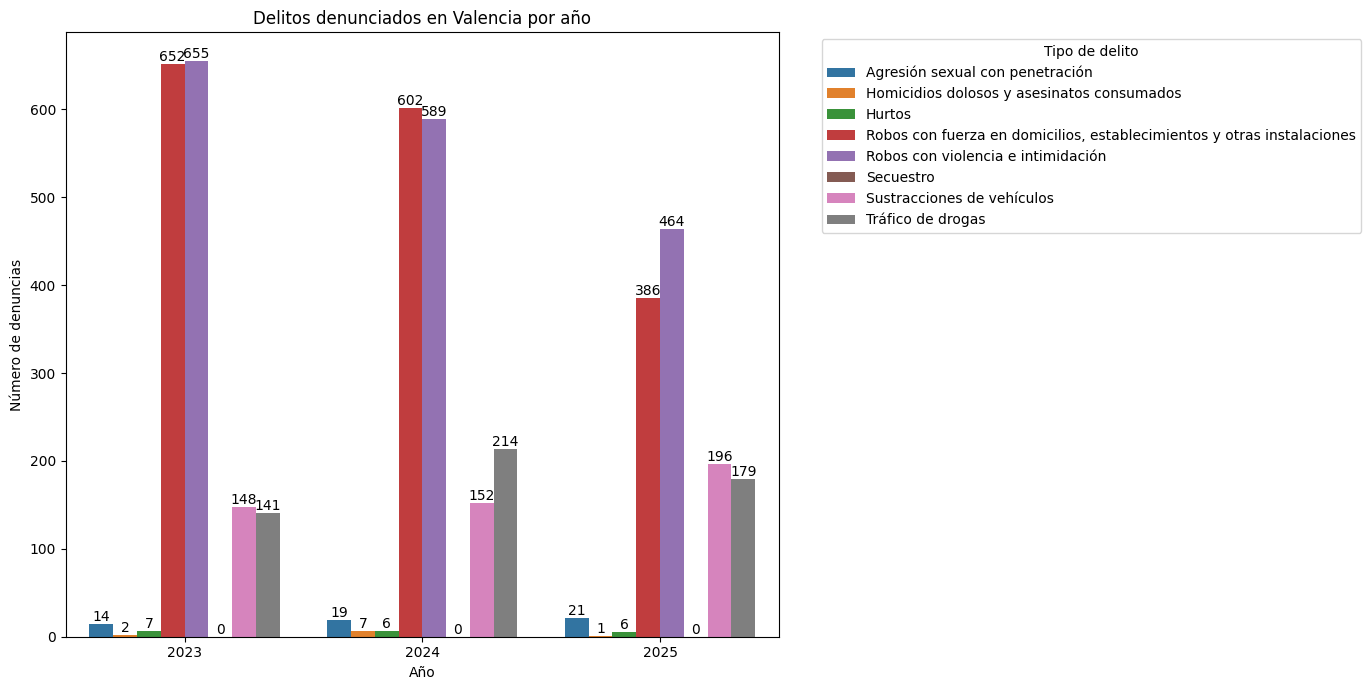

In [59]:
plt.figure(figsize=(14, 7))
# Filtrar filas que no sean 'Total'
df_delincuencia_filtrado = df_delincuencia[df_delincuencia['Parámetro'] != 'Total']

# Crear gráfico de barras agrupadas
ax = sns.barplot(
    data=df_delincuencia_filtrado,
    x='Año',
    y='Denuncias',
    hue='Parámetro'
)
plt.title('Delitos denunciados en Valencia por año')
plt.ylabel('Número de denuncias')
plt.xlabel('Año')
plt.legend(title='Tipo de delito', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Añadir etiquetas en cada barra
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f')

plt.show()

La imagen muestra la localización y el valor mínimo de alquiler en los barrios analizados de Valencia. El marcador indica el barrio con el precio de alquiler más bajo, que es de 18 €. Esto sugiere que, aunque existen zonas con alta rentabilidad y demanda, también hay barrios donde el coste de entrada para alquilar es significativamente menor. Estos barrios pueden representar oportunidades para inversores con menor presupuesto o para quienes buscan maximizar la rentabilidad relativa, aunque es importante considerar que precios bajos pueden estar asociados a menor demanda, menor calidad de la vivienda o mayor competencia. En resumen, la diversidad de precios en los barrios de Valencia permite adaptar la estrategia de inversión según el perfil y los objetivos del inversor.

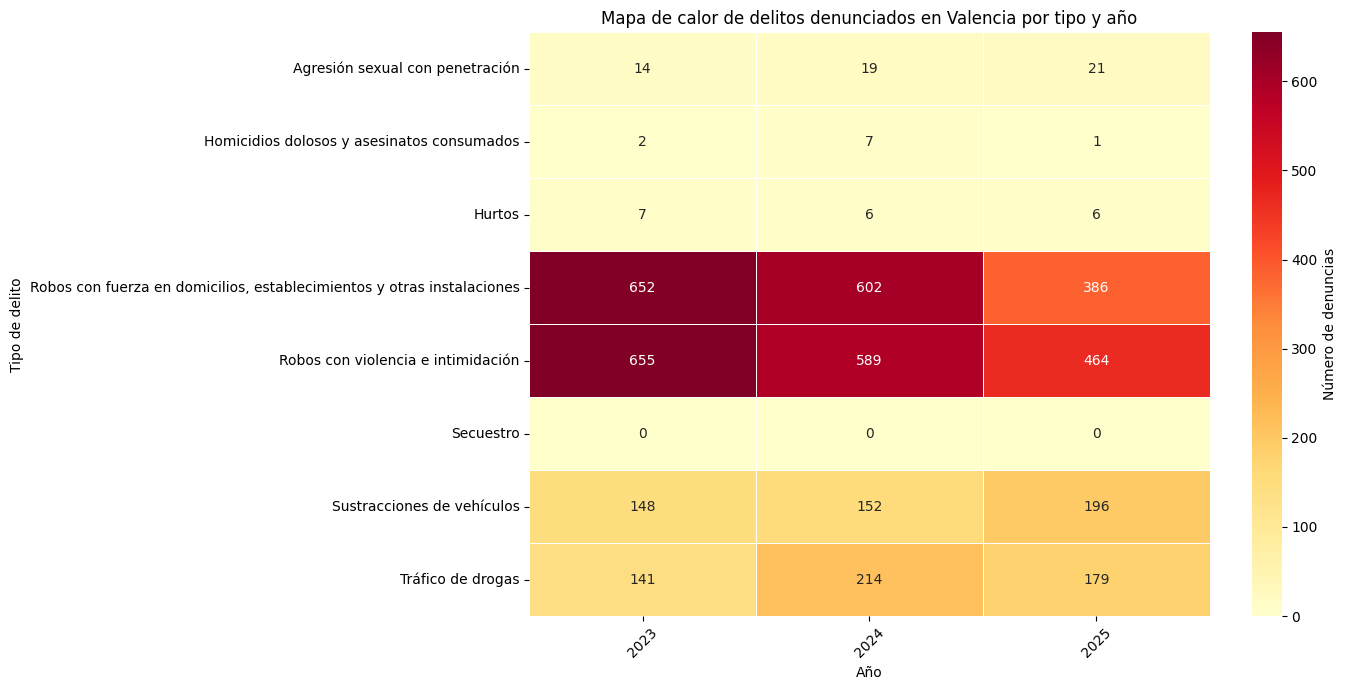

In [60]:
plt.figure(figsize=(14, 7))
heatmap_data = df_delincuencia_filtrado.pivot_table(
    index='Parámetro',
    columns='Año',
    values='Denuncias',
    aggfunc='sum'
).fillna(0)
sns.heatmap(
    heatmap_data,
    cmap='YlOrRd',
    annot=True,
    fmt='.0f',
    linewidths=.5,
    cbar_kws={'label': 'Número de denuncias'},
    annot_kws={"size": 10}
)
plt.title('Mapa de calor de delitos denunciados en Valencia por tipo y año')
plt.xlabel('Año')
plt.ylabel('Tipo de delito')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


La imagen muestra la localización y el valor mínimo de alquiler en los barrios analizados de Valencia. El marcador indica el barrio con el precio de alquiler más bajo, que es de 18 €. Esto sugiere que, aunque existen zonas con alta rentabilidad y demanda, también hay barrios donde el coste de entrada para alquilar es significativamente menor. Estos barrios pueden representar oportunidades para inversores con menor presupuesto o para quienes buscan maximizar la rentabilidad relativa, aunque es importante considerar que precios bajos pueden estar asociados a menor demanda, menor calidad de la vivienda o mayor competencia. En resumen, la diversidad de precios en los barrios de Valencia permite adaptar la estrategia de inversión según el perfil y los objetivos del inversor.

In [61]:
import folium
import json

# Cargar archivo GeoJSON
with open(r"data\neighbourhoods.geojson", encoding='utf-8') as f:
    geojson_data = json.load(f)

# Asegurarte de que los nombres de barrios coinciden en formato
barrio_rentabilidad_neta['neighbourhood'] = barrio_rentabilidad_neta['neighbourhood'].str.upper().str.strip()
for feature in geojson_data["features"]:
    feature["properties"]["neighbourhood"] = feature["properties"]["neighbourhood"].upper().strip()

# Asegúrate de que la columna 'ROI (%)' esté en barrio_rentabilidad_neta
if 'ROI (%)' not in barrio_rentabilidad_neta.columns:
    barrio_rentabilidad_neta = barrio_rentabilidad_neta.merge(
        roi_por_barrio['ROI (%)'].reset_index(),
        on='neighbourhood',
        how='left'
    )

# Crear un diccionario para acceso rápido a los valores de ROI por barrio
roi_map = barrio_rentabilidad_neta.set_index('neighbourhood').to_dict(orient='index')

# Añadir los valores de Net ROI (%) y ROI (%) a las propiedades de cada feature
for feature in geojson_data["features"]:
    barrio = feature["properties"]["neighbourhood"]
    roi_info = roi_map.get(barrio, {})
    feature["properties"]["Net ROI (%)"] = roi_info.get("Net ROI (%)")
    feature["properties"]["ROI (%)"] = roi_info.get("ROI (%)")

# Crear mapa base centrado en Valencia
mapa = folium.Map(location=[39.4699, -0.3763], zoom_start=12, tiles='cartodbpositron')

# Capa de coropletas para ROI Neto
folium.Choropleth(
    geo_data=geojson_data,
    name="choropleth_neto",
    data=barrio_rentabilidad_neta,
    columns=["neighbourhood", "Net ROI (%)"],
    key_on="feature.properties.neighbourhood",
    fill_color="YlOrRd",
    fill_opacity=0.7,
    line_opacity=0.3,
    legend_name="Rentabilidad Neta (%)",
    nan_fill_color="lightgray"
).add_to(mapa)

# Capa de coropletas para ROI Bruto (opcional, diferente color)
if 'ROI (%)' in barrio_rentabilidad_neta.columns:
    folium.Choropleth(
        geo_data=geojson_data,
        name="choropleth_bruto",
        data=barrio_rentabilidad_neta,
        columns=["neighbourhood", "ROI (%)"],
        key_on="feature.properties.neighbourhood",
        fill_color="Blues",
        fill_opacity=0.4,
        line_opacity=0.1,
        legend_name="Rentabilidad Bruta (%)",
        nan_fill_color="lightgray",
        show=False
    ).add_to(mapa)

# Tooltip para mostrar el nombre del barrio y ambos ROI al pasar el ratón
tooltip_fields = ["neighbourhood"]
tooltip_aliases = ["Barrio:"]
if 'Net ROI (%)' in barrio_rentabilidad_neta.columns:
    tooltip_fields.append("Net ROI (%)")
    tooltip_aliases.append("ROI Neto (%):")
if 'ROI (%)' in barrio_rentabilidad_neta.columns:
    tooltip_fields.append("ROI (%)")
    tooltip_aliases.append("ROI Bruto (%):")

folium.GeoJson(
    geojson_data,
    name="labels",
    style_function=lambda x: {"fillOpacity": 0, "color": "transparent"},
    tooltip=folium.GeoJsonTooltip(
        fields=tooltip_fields,
        aliases=tooltip_aliases,
        localize=True
    )
).add_to(mapa)

folium.LayerControl().add_to(mapa)
mapa


***Conclusiones finales mejoradas para empresas interesadas en invertir en alquiler turístico en Valencia (AirBnB)***

El análisis exhaustivo de los datos de rentabilidad, competencia, demanda, precios y características de los barrios de Valencia permite extraer recomendaciones más precisas y accionables para empresas que buscan invertir en el mercado de alquiler turístico:

Rentabilidad y retorno de inversión: Los barrios líderes en rentabilidad neta y bruta, como Ciutat Universitaria, Cami Fondo, Penya-Roja y La Roqueta, ofrecen retornos superiores al promedio de la ciudad. Sin embargo, la diferencia entre rentabilidad bruta y neta es relativamente baja en los barrios más rentables, lo que indica una estructura de costes eficiente y un mercado consolidado.

Demanda sostenida y visibilidad: Barrios como Cabanyal-Canyamelar, Russafa y El Mercat destacan por su alto volumen de reseñas totales y mensuales, reflejando una demanda turística constante y una elevada rotación de huéspedes. Invertir en estas zonas garantiza visibilidad y ocupación, aunque implica enfrentarse a una competencia intensa.

Competencia y saturación: La saturación de anuncios es especialmente alta en barrios turísticos y céntricos. Para destacar en estos mercados, es fundamental apostar por la diferenciación, la calidad del alojamiento y la experiencia del huésped. Por otro lado, existen barrios con alta rentabilidad y baja competencia (menor número de anuncios), que representan oportunidades para captar reservas con menor riesgo de saturación.

Calidad, amenities y tamaño de la vivienda: Los barrios con mayor número medio de amenities y viviendas más espaciosas tienden a lograr mejores valoraciones y mayor rentabilidad. La inversión en equipamiento y servicios adicionales puede ser clave para maximizar ingresos y diferenciarse en mercados competitivos.

Diversidad de precios y accesibilidad: Valencia presenta una amplia dispersión de precios de alquiler y compra por metro cuadrado, tanto entre barrios como dentro de cada uno. Esto permite adaptar la estrategia de inversión según el presupuesto y el perfil de riesgo, desde zonas premium hasta barrios emergentes con potencial de revalorización.

Relación entre precio y competencia: Los barrios con precios de alquiler más altos suelen concentrar también mayor competencia. Sin embargo, existen zonas con precios elevados y menor saturación, que pueden ser especialmente atractivas para inversores que buscan maximizar ingresos sin enfrentarse a una oferta excesiva.

Factores adicionales: Es imprescindible monitorizar la evolución de la normativa local, la estacionalidad de la demanda, la seguridad y otros factores externos que pueden impactar la rentabilidad y la sostenibilidad de la inversión.

Recomendación estratégica:
La mejor estrategia combina la selección de barrios con alta rentabilidad neta, demanda sostenida y competencia controlada, junto con una apuesta por la calidad, el equipamiento y la diferenciación. Diversificar la cartera en diferentes zonas y perfiles de barrio permite equilibrar riesgo y retorno. Además, es clave realizar un seguimiento continuo de los indicadores clave del mercado y adaptar la oferta a las tendencias y preferencias de los huéspedes.

En resumen, Valencia ofrece un mercado dinámico y diverso, con grandes oportunidades para empresas de alquiler turístico. El éxito dependerá de una toma de decisiones basada en datos, una gestión activa y una visión integral que combine rentabilidad, demanda, competencia y calidad.